In [1]:
"""
Necessary modules
"""
import sys, os
%load_ext autoreload
%autoreload 2 # autoreload to debug/modify modules
import numpy as np
from graphs.my_graph import * # my custom module for plots
%matplotlib inline
import pprint

analysis_file = 'analysis.npz'
STUDY_OUTPUT = {} # we will write a dictionary on disk storing all the quantities reported in the paper
def update_study_output(key, value, with_unit='', space=' '):
    study_output = dict(np.load(analysis_file))
    if with_unit=='':
        study_output[key] = str(value)
    else:
        study_output[key] = str(value)+space+with_unit
    np.savez(analysis_file, **study_output)

def print_study_output():
    study_output = dict(np.load(analysis_file))
    pprint.pprint(study_output)

def get_value_from_stored(key, dtype=None):
    study_output = dict(np.load(analysis_file))
    if dtype==int:
        return int(study_output[key])
    else:
        return float(study_output[key])
        

# Extra- and Intracellular recordings in awake mice

## Loading raw data

In [2]:
## UNCOMMENT TO PRODUCE THE "REDUCED" DATA (subsampled, ...) FROM THE RAW DATA

## LOAD ALL DATASET
%run cortical_arousal_index/exp_data.py
DATASET = get_one_dataset('../sparse_vs_balanced/sparse_vs_balanced/data/Wild_Type')
# ANALYZE ALL DATASET
DATA = []
for i in range(len(DATASET)):
    DATA.append(load_data(DATASET[i]['files'][0], args, full_processing=True))
    functions.compute_Network_State_Index(DATA[i],
                                          key='sbsmpl_Vm',
                                          target_key='Vm_NSI',
                                          p0_key='p0_Vm',
                                          freqs=np.linspace(args.delta_band[0], args.delta_band[1], 8), # freqs in delta band
                                          Tstate=args.Tstate,
                                          Var_criteria=1000, # NOT USED, WE USE THE VALIDATION OF pLFP !!
                                          alpha=args.alpha,
                                          T_sliding_mean=args.T_sliding_mean)
    DATA[i]['Vm_sliding_mean'] = gaussian_smoothing(DATA[i]['sbsmpl_Vm'], int(args.T_sliding_mean/DATA[i]['sbsmpl_dt']))
    DATA[i]['cc-Vm-LFP'] = np.corrcoef(DATA[i]['sbsmpl_Vm'], DATA[i]['sbsmpl_Extra'])[0,1]
    DATA[i]['cc-Vm-pLFP'] = np.corrcoef(DATA[i]['sbsmpl_Vm'], DATA[i]['pLFP'])[0,1]
ccVext_array = [np.abs(DATA[i]['cc-Vm-LFP']) for i in range(len(DATA))]
ccpLFP_array = [DATA[i]['cc-Vm-pLFP'] for i in range(len(DATA))]
for n, i in enumerate(np.argsort(ccVext_array)):
    DATA[i]['ccVext_rank'] = n
for n, i in enumerate(np.argsort(ccpLFP_array)):
    DATA[i]['ccpLFP_rank'] = n
## SAVING A REDUCED DATASET PER CELL FOR THE ANALYSIS
for i, data in enumerate(DATA):
    reduced_data = {}
    for key, val in data.items():
        if key not in ['Extra', 'Vm', 'W', 'MUA', 't',
                       'sbsmpl_Vm_W_low_freqs', 'pLFP_W_low_freqs', 'NSI_unvalidated']: # removing the large data components
            reduced_data[key] = val
    np.savez('cortical_arousal_index/data/reduced_data_cell_'+str(i+1)+'.npz', **reduced_data)

## Loading the reduced dataset

In [2]:
%run cortical_arousal_index/exp_data.py
# loading a reduced dataset per cell
DATA = []
for i in np.arange(1, 15):
    data = dict(np.load('cortical_arousal_index/data/reduced_data_cell_'+str(i)+'.npz'))
    DATA.append(data)

In [3]:
update_study_output('N_recordings', str(len(DATA)))
update_study_output('N_mice', str(4))
# recording durations
duration = np.array([DATA[i]['sbsmpl_t'][-1]-DATA[i]['sbsmpl_t'][0] for i in range(len(DATA))])
update_study_output('duration', str(round(duration.mean()/60,1))+'$\pm$'+str(round(duration.std()/60.,1)), with_unit='min')

## Sorting recordings by correlation levels

In [4]:
# order them by the amount of Vext-Vm correlation
cc_ordered = np.argsort([np.abs(DATA[i]['cc-Vm-LFP']) for i in range(len(DATA))])
ccpLFP_ordered = np.argsort([np.abs(DATA[i]['cc-Vm-pLFP']) for i in range(len(DATA))])
ccVext_ordered = np.argsort([np.abs(DATA[i]['cc-Vm-LFP']) for i in range(len(DATA))])

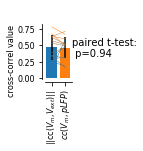

In [5]:
from graphs.bar_plots import related_samples_two_conditions_comparison

cc_Vext = [np.abs(DATA[i]['cc-Vm-LFP']) for i in cc_ordered]
cc_pLFP = [DATA[i]['cc-Vm-pLFP'] for i in cc_ordered]

fig, ax, pval = related_samples_two_conditions_comparison(cc_Vext, cc_pLFP,
                                                          colormap=get_linear_colormap(Blue, Orange), xticks_rotation=90,
                                                          ylabel='cross-correl value       ',
                                                          xticks_labels=['$\||$cc($V_m$,$V_{ext}$)$\||$', '$cc(V_m,pLFP)$'])

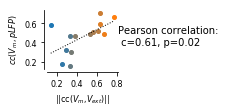

In [248]:
from graphs.scatter_plots import two_variable_analysis
fig, ax, c, pval = two_variable_analysis(cc_Vext, cc_pLFP,
                                         xlabel='$\||$cc($V_m$,$V_{ext}$)$\||$', ylabel='$cc(V_m,pLFP)$',
                                         colormap=get_linear_colormap(Blue, Orange))
update_study_output('stat_test_link_between_ccVextVm_and_ccpLFPVm',  'c=%.2f, p=%.2f, Pearson correlation' % (c, pval))
#fig.savefig(desktop+'fig.png', dpi=300)    

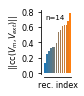

In [70]:
cell_colormap = get_linear_colormap(Blue, Orange)
# value of correlations to classify network states
#from cortical_arousal_index.plots import cell_colormap
fig_cc, ax = figure(figsize=(.6,1.1))
for i, c in enumerate(cc_ordered):
    ax.bar([i+.5], np.abs(DATA[c]['cc-Vm-LFP']), color=cell_colormap(i/(len(DATA)-1)), width=.9)
ax.annotate('n='+str(len(DATA)), (1,.7), fontsize=FONTSIZE-1)
set_plot(ax, xticks=[], ylabel=r'$\||$cc($V_m$,$V_{ext}$)$\||$', yticks=np.arange(5)*0.2, xlabel='rec. index', xlim=[0, len(DATA)], xlabelpad=3)
fig_cc.savefig(desktop+'fig.png', dpi=300)

## Delta band activity

In [ ]:
#############################################################
### Looking at the delta band activity
#############################################################
from cortical_arousal_index.functions import my_cwt
low_freqs = np.linspace(1, 7, 30)
pop_pow = np.zeros((len(low_freqs), len(DATA)))
peak_freq = np.zeros(len(DATA))
for i, data in enumerate(DATA):
    data['Vm_W_low_freqs'] = my_cwt(data['sbsmpl_Vm'].flatten(), low_freqs, data['sbsmpl_dt']) # wavelet transform
    pop_pow[:,i] = np.abs(data['Vm_W_low_freqs']).mean(axis=1)
    low_freqs = np.linspace(1, 7, 30)
    peak_freq[i] = low_freqs[np.argmax(pop_pow[:,i])]
update_study_output('delta_band_peak', '%.1f $\pm$ %.1f' % (np.mean(peak_freq), np.std(peak_freq)), with_unit='Hz')

In [98]:
update_study_output('delta_band', '[%i,%i]' % (args.delta_band[0], args.delta_band[1]), with_unit='Hz')
update_study_output('gamma_band', '[%i,%i]' % (args.gamma_band[0], args.gamma_band[1]), with_unit='Hz')

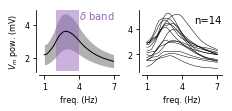

In [42]:
fig, [ax, ax1] = figure(axes=(1,2))
plot(low_freqs, y=pop_pow.mean(axis=1), sy=pop_pow.std(axis=1), ax=ax)
ax.fill_between([2,4], np.ones(2)*ax.get_ylim()[0], np.ones(2)*ax.get_ylim()[1], color=Purple, alpha=.5, lw=0)
ax.annotate('$\delta$ band', (4,ax.get_ylim()[1]-.5), color=Purple)
set_plot(ax, ylabel='$V_m$ pow. (mV)', xlabel='freq. (Hz)', xticks=[1,4,7], yticks=[2,4])
for i, data in enumerate(DATA):
   ax1.plot(low_freqs, pop_pow[:,i], 'k-', lw=0.5)
ax1.annotate('n=14', (5,ax.get_ylim()[1]-.5), color='k')
set_plot(ax1, xlabel='freq. (Hz)', xticks=[1,4,7], yticks=[2,4])

### Now using Fourier analysis

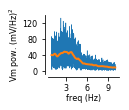

In [148]:
###################################################                                
###### Example Fourier analysis 
###################################################                                
from data_analysis.freq_analysis import fourier_for_real as fourier
fig, ax = figure()                                
Vm_pow_low_freqs = np.abs(fourier.FT(data['sbsmpl_Vm'], len(data['sbsmpl_Vm']), data['sbsmpl_dt']))
freqs = fourier.time_to_freq(len(data['sbsmpl_Vm']), data['sbsmpl_dt'])
cond = (freqs>1) & (freqs<10)
plt.plot(freqs[cond], Vm_pow_low_freqs[cond], lw=.5)
pow_smoothed = gaussian_smoothing(Vm_pow_low_freqs[cond], 30)
plt.plot(freqs[cond], pow_smoothed, lw=2)
set_plot(ax, xlabel='freq (Hz)', ylabel='Vm pow. (mV/Hz)$^2$')

In [165]:
#############################################################
### Population analysis
#############################################################
from cortical_arousal_index.functions import my_cwt
pop_pow, pop_freq = [], []
for i, data in enumerate(DATA):
    Vm_pow_low_freqs = np.abs(fourier.FT(data['sbsmpl_Vm'], len(data['sbsmpl_Vm']), data['sbsmpl_dt']))
    freqs = fourier.time_to_freq(len(data['sbsmpl_Vm']), data['sbsmpl_dt'])
    cond = (freqs>2) & (freqs<10)
    pow_smoothed = gaussian_smoothing(Vm_pow_low_freqs, 10)[cond]
    pop_pow.append(pow_smoothed)
    pop_freq.append(freqs[cond])                 

2.7 $\pm$ 0.4


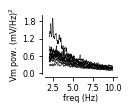

In [166]:
peak_freq = []
fig, ax = figure()
for freqs, power in zip(pop_freq, pop_pow):
    ax.plot(freqs, power, 'k-', lw=0.5)
    peak_freq.append(freqs[np.argmax(power)])
print('%.1f $\pm$ %.1f' % (np.mean(peak_freq), np.std(peak_freq)))
update_study_output('delta_band_peak_fourier', '%.1f $\pm$ %.1f' % (np.mean(peak_freq), np.std(peak_freq)), with_unit='Hz')
#set_plot(ax, xlabel='freq (Hz)', ylabel='Vm pow. (mV/Hz)$^2$', xscale='log', yscale='log')
set_plot(ax, xlabel='freq (Hz)', ylabel='Vm pow. (mV/Hz)$^2$')

## Gamma over Delta index

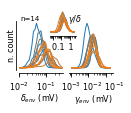

In [59]:
fig_pow, [ax, ax2] = figure(axes=(1,2), figsize=(.6,1), wspace=0.3, top=3.)
delta_bins = np.logspace(np.log10(1e-2), np.log10(0.4), 30)
gamma_bins = np.logspace(np.log10(1e-3), np.log10(0.2), 30)
ratio_bins = np.logspace(np.log10(6e-3), np.log10(4), 30)
ax3 = add_inset(ax, [.7,.75,.6,.45])

for i, c in enumerate(cc_ordered):
    hist, be = np.histogram(DATA[c]['Extra_delta_power'], bins=delta_bins, normed=True)
    x = 
.5*(be[1:]+be[:-1])
    ax.plot(x, hist, '-', color=cell_colormap(i/(len(DATA)-1)), lw=1)
    hist, be = np.histogram(DATA[c]['Extra_gamma_power'], bins=gamma_bins, normed=True)
    x = .5*(be[1:]+be[:-1])
    ax2.plot(x, hist, '-', color=cell_colormap(i/(len(DATA)-1)), lw=1)
    hist, be = np.histogram(DATA[c]['Extra_gamma_power']/DATA[c]['Extra_delta_power'], bins=ratio_bins, normed=True)
    x = .5*(be[1:]+be[:-1])
    ax3.plot(x, hist, '-', color=cell_colormap(i/(len(DATA)-1)), lw=1)
    
ax.annotate('n='+str(len(DATA)), (0.02,1.), fontsize=FONTSIZE-1, xycoords='axes fraction')
set_plot(ax3, ['bottom'], xscale='log', xticks=[0.01, 0.1, 1], xticks_labels=['', '0.1  ', ' 1'])
ax3.annotate(r'$\gamma$/$\delta$', (.7,.5), xycoords='axes fraction', fontsize=FONTSIZE)
set_plot(ax, xscale='log',xlim=[1e-2,0.4], xlabel=r'$\delta_{env}$ (mV)  ', yticks=[], ylabel='n. count')
set_plot(ax2, ['bottom'], xscale='log',xlabel=r'  $\gamma_{env}$ (mV)',
         xticks=[0.001, 0.01, 0.1], xticks_labels=['$10^{-3}$', '   $10^{-2}$', '       $10^{-1}$'])

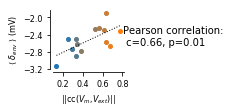

In [150]:
fig, ax, c, pval = two_variable_analysis(cc_Vext,
                                         # [np.mean(DATA[c]['Extra_delta_power']) for c in cc_ordered],
                                         [np.mean(np.log(DATA[c]['Extra_delta_power'])) for c in cc_ordered],
                                         xlabel=r'$\||$cc($V_m$,$V_{ext}$)$\||$',
                                         ylabel=r'$\langle$ $\delta_{env}$ $\rangle$ (mV)',
                                         colormap=get_linear_colormap(Blue, Orange))
update_study_output('stat_test_link_between_cc_and_log_delta_pow',  'c=%.2f, p=%.2f, Pearson correlation' % (c, pval))

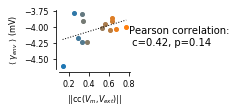

In [135]:
fig, ax, c, pval = two_variable_analysis(cc_Vext,
                                         # [np.mean(DATA[c]['Extra_gamma_power']) for c in cc_ordered],
                                         [np.mean(np.log(DATA[c]['Extra_gamma_power'])) for c in cc_ordered],
                                         xlabel=r'$\||$cc($V_m$,$V_{ext}$)$\||$',
                                         ylabel=r'$\langle$ $\gamma_{env}$ $\rangle$ (mV)',
                                         colormap=get_linear_colormap(Blue, Orange))
update_study_output('stat_test_link_between_cc_and_log_gamma_pow',  'c=%.2f, p=%.2f, Pearson correlation' % (c, pval))

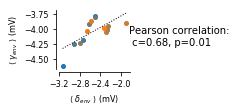

In [136]:
fig, ax, c, pval = two_variable_analysis([np.mean(np.log(DATA[c]['Extra_delta_power'])) for c in cc_ordered],
                                         [np.mean(np.log(DATA[c]['Extra_gamma_power'])) for c in cc_ordered],
                                         xlabel=r'$\langle$ $\delta_{env}$ $\rangle$ (mV)',
                                         ylabel=r'$\langle$ $\gamma_{env}$ $\rangle$ (mV)',
                                         colormap=get_linear_colormap(Blue, Orange))
update_study_output('stat_test_link_between_log_delta_and_log_gamma_pow',  'c=%.2f, p=%.2f, Pearson correlation' % (c, pval))

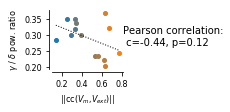

In [132]:
fig, ax, c, pval = two_variable_analysis(cc_Vext,
                                         [np.mean(DATA[c]['Extra_gamma_power']/DATA[c]['Extra_delta_power']) for c in cc_ordered],
                                         xlabel=r'$\||$cc($V_m$,$V_{ext}$)$\||$',
                                         ylabel=r'$\gamma$ / $\delta$ pow. ratio',
                                         colormap=get_linear_colormap(Blue, Orange))
update_study_output('stat_test_link_between_cc_and_gamma_to_delta',  'c=%.2f, p=%.2f, Pearson correlation' % (c, pval))

In [34]:
# %run cortical_arousal_index/exp_data.py
# data = load_data('../sparse_vs_balanced/sparse_vs_balanced/data/Wild_Type/Cell14/17o27001.abf',
#                  args,
#                  chosen_window_only=True, full_processing=False)
# To get a subsampled version of the 
# data2 = {'Extra':data['sbsmpl_Extra'], 'dt':data['sbsmpl_dt']}
# np.savez('/Users/yzerlaut/work/Waking_State_index/data/sample_data.npz', **data2)

In [36]:
# to get "args"
%run cortical_arousal_index/exp_data.py
from cortical_arousal_index.plots import * # and plot function

<Figure size 432x288 with 0 Axes>

In [5]:
# loading the cell with the globally desynchonized behavior
example1_index = 1
desynch_data = load_data(str(DATA[cc_ordered[example1_index]]['filename']),
                         args,
                         chosen_window_only=True, full_processing=True)

In [6]:
# loading the cell with all the different states
example2_index = 10
nice_cell_data = load_data(str(DATA[cc_ordered[example2_index]]['filename']),
                           args,
                           chosen_window_only=True, full_processing=True)

In [35]:
def show_raw_data_Vm_Vext(data,
                          tstart=0, twidth=180,
                          highlighted_episodes=[],
                          highlighted_episodes_labels = None,
                          Vext_loc=0., # in mV
                          Vm_scale=10, # in mV
                          Vext_scale=0.1, # in mV
                          Vm_color='k', Vext_color=Grey,
                          nospike=False,
                          spike_threshold=-35,
                          bar_loc = None,
                          colormap=get_linear_colormap(Blue, Orange),
                          Tscale=5.,
                          subsampling=10):
    
    fig, ax = figure(axes_extents=[[[4,1]]], figsize=(1.07, 1.))
    
    cond = (data['sbsmpl_t']>tstart) & (data['sbsmpl_t']<tstart+twidth)

    ######### Vext plot ##########
    ax.plot(data['sbsmpl_t'][cond][::subsampling],
            data['sbsmpl_Extra'][cond][::subsampling]*Vm_scale/Vext_scale+Vext_loc,
            color=Vext_color, lw=1)
    ax.plot([tstart, tstart+twidth], np.zeros(2), ':', color=Vext_color, lw=1)
    
    ######### Vm plot ##########
    t_for_plot, Vm_for_plot = data['sbsmpl_t'][cond][::subsampling], data['sbsmpl_Vm'][cond][::subsampling]
    # dealing with spikes
    if nospike:
        Vm_for_plot[Vm_for_plot>spike_threshold] = spike_threshold
    else:
        condS = (data['tspikes']>tstart) & (data['tspikes']<tstart+twidth)
        for tspike, vspike in zip(data['tspikes'][condS], data['Vpeak_spikes'][condS]):
            ispike = np.argmin((tspike-t_for_plot)**2)
            ax.plot([tspike, tspike], [Vm_for_plot[ispike], vspike], color=Vm_color, lw=1)
            # Vm_for_plot[ispike] = vspike # we replace the data at spike time by the peak value in the non-subsampled data
    # subthreshold, we subsample
    ax.plot(t_for_plot, Vm_for_plot, color=Vm_color, lw=1)
    ax.plot([tstart, tstart+twidth], np.ones(2)*data['p0_Vm'], ':', color=Vm_color, lw=1)

    ylim = ax.get_ylim()

    # bar scales with annotations
    if bar_loc is None:
        t0, y0 = tstart+twidth/10., 0.99*ylim[1]
    else:
        t0, y0 = bar_loc
        
    ax.plot([t0,t0-Tscale], np.ones(2)*y0, 'k-', lw=1)
    ax.annotate(str(int(Tscale))+'s', (t0-Tscale/1.3, y0), color=Vm_color, fontsize=FONTSIZE)
    ax.plot([t0,t0], y0-np.arange(2)*Vm_scale, 'k-', lw=1)
    ax.annotate(str(int(Vm_scale))+'mV', (t0+Tscale/10., y0-Vm_scale/3.), color=Vm_color, fontsize=FONTSIZE)
    ax.annotate(str(int(1e3*Vext_scale))+'$\mu$V',(t0+Tscale/10., y0-Vm_scale), color=Vext_color, fontsize=FONTSIZE)

    if highlighted_episodes_labels is None:
        highlighted_episodes_labels = ['(%i)'%(n+1) for n in range(len(highlighted_episodes))]
    for n, interval in enumerate(highlighted_episodes):
        ax.annotate(highlighted_episodes_labels[n], (interval[0], ylim[1]), color=Grey, fontsize=FONTSIZE-1, ha='center')
        ax.fill_between(interval, np.ones(2)*ylim[0], np.ones(2)*ylim[1], alpha=.1, color='k', lw=0)

    ax.annotate('$V_m$', (-0.03, .15), color=Vm_color, xycoords='axes fraction', fontsize=FONTSIZE)
    ax.annotate('$V_{ext}$', (-0.04, 0.65), color=Vext_color, xycoords='axes fraction', fontsize=FONTSIZE)
    set_plot(ax, [], xlim=[tstart, tstart+twidth], ylim=ylim)

    ax.annotate('rec.#%i' % (data['ccVext_rank']+1), (.5, .99),
                color=colormap(data['ccVext_rank']/(len(DATA)-1)),\
                xycoords='axes fraction', fontsize=FONTSIZE)    
    return fig, ax

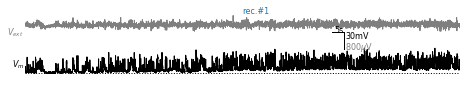

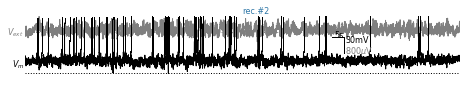

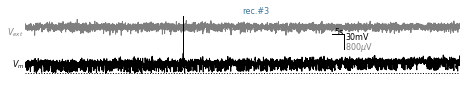

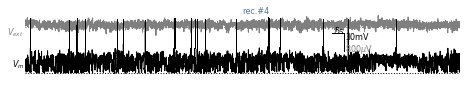

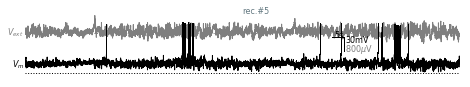

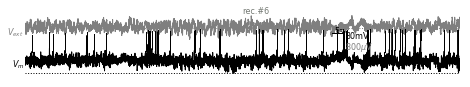

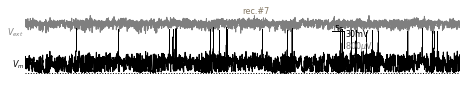

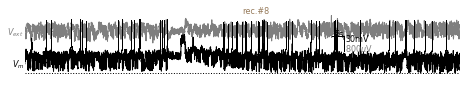

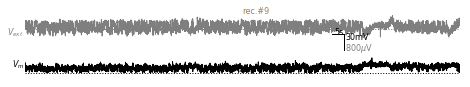

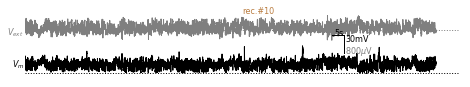

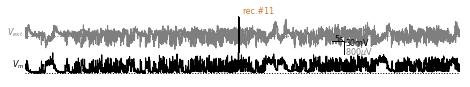

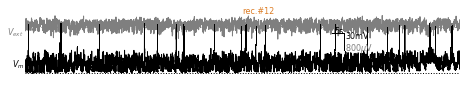

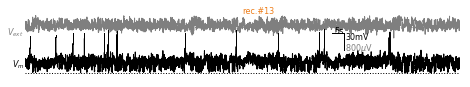

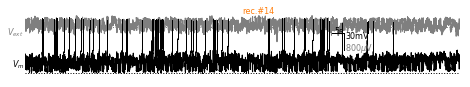

In [10]:
#########################################################
##     Let's have a look at all the recordings      #####
#########################################################
for i, icell in enumerate(cc_ordered):
    fig_cell1, ax = show_raw_data_Vm_Vext(DATA[icell],
                                      tstart=0, twidth=180,
                                      Vext_scale=0.8, Vm_scale=30, bar_loc=(132, -10))

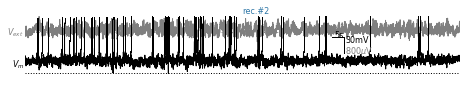

In [36]:
# we pick the first cell:
### ------> showing mostly desynchronized activity
icell = 12                                        
fig_cell1, ax = show_raw_data_Vm_Vext(DATA[icell],
                                      tstart=0, twidth=180,
                                      Vext_scale=0.8, Vm_scale=30, bar_loc=(132, -10))

In [11]:
#########################
### TO KEEP, some history of the previous zooms

# Zooms=[x-70+np.arange(2)*2 for x in [154.5, 90.2, 115.5, 127.9, 189.8, 216.6]]
# Zooms=[x+np.arange(2)*1.5 for x in [84.5, 20.5, 6.5, 18.3, 45.5, 58.1, 49.8, 182.8, 119.9, 146.6]]
# Zooms=[x+np.arange(2)*1.5 for x in [84.9, 20.5, 6.7, 18.3, 45.5, 58.1, 49.8, 182.8, 119.9, 146.6]]
# Zooms=[x+np.arange(2)*1.5 for x in [84.9, 20.5, 37.9, 18.3, 45.5, 58.1, 182.8, 119.9, 146.6]]
# Zooms=[x+np.arange(2)*1.5 for x in [84.9, 20.5, 18.3, 45.5, 58.1, 119.9, 146.6]]


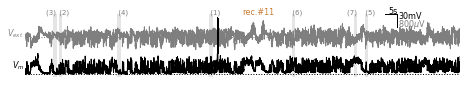

In [41]:
Zooms=[x+np.arange(2)*1.5 for x in [84.9, 20.5, 18.3, 45.5, 151.3, 120.1, 146.6]]
highlighted_episodes_labels = ['     (%i)'%(n+1) for n in range(len(Zooms))]
highlighted_episodes_labels[2] = '(3)  '
highlighted_episodes_labels[6] = '(7)  '
icell = 5
fig_cell2, ax = show_raw_data_Vm_Vext(DATA[icell],
                                      tstart=6, twidth=186,
                                      highlighted_episodes=Zooms,
                                      highlighted_episodes_labels = highlighted_episodes_labels,
                                      Vext_scale=0.8, Vm_scale=30, bar_loc=(165, 55))

In [3]:
# so we load the raw un-subsampled data of this cell
icell = 5
nice_cell_data = load_data(str(DATA[icell]['filename']),
                           args,
                           chosen_window_only=True,
                           full_processing=True,
                           with_Vm_low_freq=True)

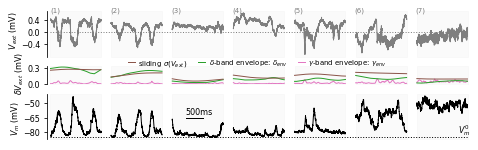

In [71]:
def zoom_over_episodes0(data,
                        highlighted_episodes=[],
                        tspace=.3,
                        tstart=12, twidth=168,
                        Vm_color='k', Vext_color=Grey,
                        Vm_ticks=[-80, -65, -50],
                        Vext_ticks=[0., 0.3],
                        Tbar_loc=(4, -65),                    
                        Vext_scale=0.8, Vm_scale=30,
                        Tscale=0.5):

    if 'Extra_sliding_std_smooth' not in data:
        data['Vm_sliding_mean'] = gaussian_smoothing(data['sbsmpl_Vm'], int(args.T_sliding_mean/data['sbsmpl_dt']))
        i0 = int(args.T_sliding_mean/data['sbsmpl_dt']/2)
        data['Extra_sliding_std'] = 0*data['sbsmpl_Extra']
        for ii in range(i0, len(data['Extra_sliding_std'])-i0):
            data['Extra_sliding_std'][ii] = data['sbsmpl_Extra'][ii-i0:ii+i0].std()
        data['Extra_sliding_std_smooth'] = gaussian_smoothing(data['Extra_sliding_std'], int(args.T_sliding_mean/data['sbsmpl_dt']))

    fig, AX = figure(axes_extents=[[[4,2]], [[4,1]], [[4,2]]], figsize=(1.,.33), hspace=.5)

    DELTA, GAMMA, DEPOL, STD_LFP = [], [], [], []

    YLIMS = [[np.inf,-np.inf] for i in range(4)]
    for n, interval in enumerate(highlighted_episodes):
        if 't' in data:
            tkey, extrakey, vmkey = 't', 'Extra', 'Vm'
        else:
            tkey, extrakey, vmkey = 'sbsmpl_t', 'sbsmpl_Extra', 'sbsmpl_Vm' # 
        cond = (data[tkey]>interval[0]) & (data[tkey]<interval[1])
        new_t = data[tkey][cond]-data[tkey][cond][0]+n*(interval[1]-interval[0]+tspace)
        AX[0].plot(new_t, data[extrakey][cond], color=Vext_color, lw=1)
        AX[2].plot(new_t, data[vmkey][cond], color=Vm_color, lw=1)
        AX[0].annotate('(%i)'%(n+1), (n/len(highlighted_episodes)*1.02,.99), color=Grey, xycoords='axes fraction', fontsize=FONTSIZE-1)
        
        cond = (data['sbsmpl_t']>interval[0]) & (data['sbsmpl_t']<interval[1])
        new_st = data['sbsmpl_t'][cond]-data['sbsmpl_t'][cond][0]+n*(interval[1]-interval[0]+tspace)
        a3, = AX[1].plot(new_st, data['Extra_gamma_power'][cond], color=Pink, lw=1, label='$\\delta$ pow.')
        a2, = AX[1].plot(new_st, data['Extra_delta_power'][cond], color=Green, lw=1)
        a1, = AX[1].plot(new_st, data['Extra_sliding_std_smooth'][cond], color=Brown, lw=1, label='sliding $\sigma_{V_ext}$')

        cond2 = cond #(data['sbsmpl_t']>(interval[0]+interval[1])/2.-.25) & (data['sbsmpl_t']<(interval[0]+interval[1])/2.+.25)
        DELTA.append(np.mean(data['Extra_delta_power'][cond2]))
        GAMMA.append(np.mean(data['Extra_gamma_power'][cond2]))
        DEPOL.append(np.mean(data['Vm_sliding_mean'][cond2]))
        STD_LFP.append(np.mean(data['Extra_sliding_std_smooth'][cond2]))

    YLIMS = [[np.min([AX[i].get_ylim()[0],YLIMS[i][0]]),np.max([AX[i].get_ylim()[1],YLIMS[i][1]])] for i in range(len(AX))]

    for n, interval in enumerate(highlighted_episodes):
        for i in range(len(AX)):
            AX[i].fill_between(n*(interval[1]-interval[0]+tspace)+np.arange(2)*(interval[1]-interval[0]),
                               YLIMS[i][0]*np.ones(2), YLIMS[i][1]*np.ones(2), color='lightgray', alpha=0.1)
        

    AX[2].plot([0, (n+1)*(interval[1]-interval[0])+n*tspace], data['p0_Vm']*np.ones(2), ':', color=Vm_color, lw=1)
    AX[0].plot([0, (n+1)*(interval[1]-interval[0])+n*tspace], np.zeros(2), ':', color=Vext_color, lw=1)
    AX[1].plot([0, (n+1)*(interval[1]-interval[0])+n*tspace], np.zeros(2), ':', color=Vext_color, lw=1)
    
    set_plot(AX[0], ['left'], xlim=[0, (n+1)*(interval[1]-interval[0])+n*tspace], ylim=YLIMS[0], ylabel='   $V_{ext}$ (mV)',
             yticks=[-.4,0.,.4])
    set_plot(AX[1], ['left'], xlim=[0, (n+1)*(interval[1]-interval[0])+n*tspace],
             ylim=[1e-3, YLIMS[1][1]], ylabel='  $\delta V_{ext}$ (mV)',
             num_yticks=2, yticks=Vext_ticks)
    set_plot(AX[2], ['left'],
             yticks=[-80, -65, -50],
             xlim=[0, (n+1)*(interval[1]-interval[0])+n*tspace], ylim=YLIMS[2], ylabel='$V_{m}$ (mV)  ')

    AX[2].annotate('$V_m^0$', ((n+1)*(interval[1]-interval[0])+n*tspace-tspace, data['p0_Vm']+5), color=Vm_color, fontsize=FONTSIZE)
    
    AX[2].plot([Tbar_loc[0], Tbar_loc[0]+Tscale], Tbar_loc[1]*np.ones(2), 'k-', lw=1)
    AX[2].annotate(str(int(1e3*Tscale))+'ms', (Tbar_loc[0], Tbar_loc[1]+3), fontsize=FONTSIZE)
    AX[1].legend([a1, a2, a3],
                 ['sliding $\sigma(V_{ext})$', '$\\delta$-band envelope: $\\delta_{env}$', '$\\gamma$-band envelope: $\gamma_{env}$'],
                 columnspacing=1.5,
                 handletextpad=.5,
                 handlelength=1.,
                 ncol=3, loc=(.18,.73), frameon=False, fontsize=FONTSIZE-1)
        
    return fig, AX, np.array(DELTA), np.array(GAMMA), np.array(DEPOL), np.array(STD_LFP)
    

fig_episodes, AX, DELTA, GAMMA, DEPOL, STD_LFP = zoom_over_episodes0(nice_cell_data,
                                                                     highlighted_episodes=Zooms)

In [61]:
print(DELTA/STD_LFP)
update_study_output('criteria_for_rhythmic_episodes_1st_Fig_under', '80\%')
update_study_output('criteria_for_rhythmic_episodes_1st_Fig_over', '95\%')

[1.00844605 1.13997014 0.59969525 0.74596039 0.48170282 0.53639496
 0.48553733]


In [526]:
"""
time freq plot for the slow oscillation
"""
from graphs.surface_plots import twoD_plot

def add_time_freq_Vm_plot_over_specific_episodes(data, interval):

    cond = (data['sbsmpl_t']>interval[0]-.5) & (data['sbsmpl_t']<interval[1]+.5)
    new_st = data['sbsmpl_t'][cond]-data['sbsmpl_t'][cond][0]
    x, y = np.meshgrid(new_st, data['low_freqs'])
    ax, acb = twoD_plot(x.flatten(), y.flatten(), np.abs(data['pLFP_W_low_freqs'][:,cond].flatten()))
    set_plot(ax, xlabel='time (s)', ylabel='freq (Hz)')
    acb.set_label('pow. (mV)')

#add_time_freq_Vm_plot_over_specific_episodes(nice_cell_data, Zooms[1])

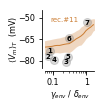

In [69]:

def single_cell_example_pow_ratio(data, index, GAMMA, DELTA, DEPOL):
    fig, ax = figure(figsize=(.8,1.))

    bins = np.logspace(np.log10(0.04), np.log10(2), 25)
    xbins = np.digitize(data['Extra_gamma_power']/data['Extra_delta_power'], bins=bins)
    cbins = .5*(bins[1:]+bins[:-1]) # center of bins
    depol_hist_mean, depol_hist_std = 0*cbins, 0*cbins
    for i in range(len(cbins)):
        cond = (xbins==i)
        if np.sum(cond)>1:
            # depol_hist_mean[i] = np.mean(data['Vm_sliding_mean'][cond]-data['p0_Vm'])
            depol_hist_mean[i] = np.mean(data['Vm_sliding_mean'][cond])
            depol_hist_std[i] = np.std(data['Vm_sliding_mean'][cond])


    def plot_numbered_dot(x, y, i, ax, size=1500):
        ax.plot([x], [y], 'o', color=Grey, ms=8, alpha=.3)
        ax.annotate(str(i), (x, y), fontsize=FONTSIZE-1, color='k', ha='center', va='center', fontweight='bold')

    for i in range(len(DEPOL)):
        plot_numbered_dot(GAMMA[i]/DELTA[i], DEPOL[i], str(i+1), ax)

    plot(cbins[depol_hist_std>0], depol_hist_mean[depol_hist_std>0], sy=depol_hist_std[depol_hist_std>0], ax=ax,
         color=cell_colormap(example2_index/(len(DATA)-1)))

    ax.annotate('rec.#'+str(example2_index+1), (.1, .8), color=cell_colormap(example2_index/(len(DATA)-1)),
                xycoords='axes fraction', fontsize=FONTSIZE-1)
    set_plot(ax,
             xscale='log',
             # yscale='log',
             ylabel=r'$ \langle V_m \rangle_T$  (mV)',
             yticks=[-80, -65, -50],
             ylim=[-85, -45],
             xlim=[0.06,1.7],
             xlabel='$\gamma_{env}$ / $\\delta_{env}$',
             xticks=[0.1, 1], xticks_labels=['0.1', '1'], ylabelpad=-1)
    return fig, ax

example2_index = 10
fig_single_example_pow_ratio, ax = single_cell_example_pow_ratio(nice_cell_data, example2_index, GAMMA, DELTA, DEPOL)
#fig.savefig(desktop+'fig.svg')

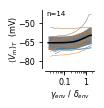

In [76]:
# same on all data
fig_all_pow_ratio, ax = figure(figsize=(.8,1))

bins = np.logspace(np.log10(0.015), np.log10(2), 20)
cbins = .5*(bins[1:]+bins[:-1]) # center of bins

pop_hist = [[] for i in range(len(cbins))]
num_hist = [[] for i in range(len(cbins))]
for c, data in enumerate(DATA):
    xbins = np.digitize(data['Extra_gamma_power']/data['Extra_delta_power'], bins=bins)
    depol_hist_mean = 0*cbins
    for i in range(len(cbins)):
        cond = (xbins==i)
        if np.sum(cond)>10:
            depol_hist_mean[i] = np.mean(data['Vm_sliding_mean'][cond])
            pop_hist[i].append(depol_hist_mean[i])
            num_hist[i].append(1)
    ax.plot(cbins[depol_hist_mean<0], depol_hist_mean[depol_hist_mean<0], '-', lw=0.5,\
                    color=cell_colormap(cc_ordered[c]/(len(DATA)-1)))

from cortical_arousal_index.plots import compute_relationship_smooth_and_plot    
compute_relationship_smooth_and_plot(cbins, pop_hist, num_hist, ax)

ax.annotate('n='+str(len(DATA)), (.02, .9), xycoords='axes fraction', fontsize=FONTSIZE-1)
set_plot(ax,
         xscale='log',
         # yscale='log',
         ylabel=r'$ \langle V_m \rangle_T$  (mV)',
         ylim=[-85, -40],
         yticks=[-80, -65, -50],
         # ylim=[0,38], yticks=[0,10,20,30],
         xlabel='$\gamma_{env}$ / $\\delta_{env}$',
         xticks=[0.1, 1], xticks_labels=['0.1', '1'], ylabelpad=-1)
fig_all_pow_ratio.savefig(desktop+'fig.png', dpi=300)

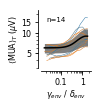

In [75]:
# same on all data
fig_all_mua_pow_ratio, ax = figure(figsize=(.8,1))

bins = np.logspace(np.log10(0.015), np.log10(2), 20)
cbins = .5*(bins[1:]+bins[:-1]) # center of bins

pop_hist = [[] for i in range(len(cbins))]
num_hist = [[] for i in range(len(cbins))]
for c, data in enumerate(DATA):
    xbins = np.digitize(data['Extra_gamma_power']/data['Extra_delta_power'], bins=bins)
    depol_hist_mean = 0*cbins
    for i in range(len(cbins)):
        cond = (xbins==i)
        if np.sum(cond)>10:
            depol_hist_mean[i] = np.mean(1e6*data['sbsmpl_MUA'][cond])
            pop_hist[i].append(depol_hist_mean[i])
            num_hist[i].append(1)
    ax.plot(cbins[depol_hist_mean>0], depol_hist_mean[depol_hist_mean>0], '-', lw=0.5,
                    color=cell_colormap(cc_ordered[c]/(len(DATA)-1)))

compute_relationship_smooth_and_plot(cbins, pop_hist, num_hist, ax)

ax.annotate('n='+str(len(DATA)), (.1, .8), xycoords='axes fraction', fontsize=FONTSIZE-1)
set_plot(ax,
         xscale='log',
         yscale='log',
         ylabel=r'$ \langle$MUA$ \rangle_T$ ($\mu$V)',
         yticks=[5, 10, 15], yticks_labels=['5', '10', '15'],
         xlabel='$\gamma_{env}$ / $\\delta_{env}$',
         xticks=[0.1, 1], xticks_labels=['0.1', '1'])
fig_all_mua_pow_ratio.savefig(desktop+'fig.png', dpi=300)

In [77]:
from graphs.plot_export import put_list_of_figs_to_svg_fig, export_as_png
put_list_of_figs_to_svg_fig([fig_cell1, fig_cell2, fig_episodes, fig_cc, fig_pow,
                             fig_single_example_pow_ratio, fig_all_pow_ratio, fig_all_mua_pow_ratio],
                            fig_name='Figures/Fig_Dataset.svg',
                            figsize=(0.593,0.261),
                            fontsize=FONTSIZE+1,
                            Props={'XCOORD':[-20, -20, 0, 0, 53, 185, 280, 370],
                                   'YCOORD':[0, 75, 155, 298]+list(np.ones(4)*295),
                                   'XCOORD_LABELS':list(np.ones(4)*-5)+[62, 172, 267, 362],
                                   'YCOORD_LABELS':[-10, 0, 145]+list(np.ones(5)*290),
                                   'LABELS':['a','', 'b', 'c', 'd', 'e', 'f', 'g']},
                            visualize=False)
export_as_png(os.getcwd()+'/Figures/Fig_Dataset.svg', dpi=200)

# Computing the pLFP signal

In [4]:
data = load_data('../sparse_vs_balanced/sparse_vs_balanced/data/Wild_Type/Cell14/17o27001.abf',
                 args,
                 chosen_window_only=True,
                 full_processing=True,
                 with_Vm_low_freq=True)

In [5]:
f0, w0, T0 = get_pLFP_parameters_from_scan(datafile1='cortical_arousal_index/data/final_wvl_scan.npz',
                                           datafile2='cortical_arousal_index/data/final_smooth.npz')

wavelet pack in band: [ 39.7 , 133.6 ]Hz
with smoothing time constant  42.2 ms


In [6]:
f0, w0, T0 = get_pLFP_parameters_from_scan(datafile1='cortical_arousal_index/data/final_wvl_scan.npz',
                                           datafile2='cortical_arousal_index/data/final_smooth.npz')
functions.preprocess_LFP(data,
                         freqs=np.linspace(f0/w0, f0*w0, args.wavelet_number),
                         new_dt=args.subsampling_period,
                         smoothing=0) # HERE NO SMOOTHING YET !!
data['pLFP0'] = data['pLFP'] # storing the pLFP value
functions.preprocess_LFP(data,
                         freqs=np.linspace(f0/w0, f0*w0, args.wavelet_number),
                         new_dt=args.subsampling_period,
                         smoothing=T0) # HERE NO SMOOTHING YET !!

wavelet pack in band: [ 39.7 , 133.6 ]Hz
with smoothing time constant  42.2 ms


In [9]:
%run cortical_arousal_index/exp_data.py
# storing the quantities for the paper
update_study_output('Tstate', int(1e3*2*args.Tstate)) # in ms, # twice the value, because window is 2*Tstate and update is Tstate here (see paper)
update_study_output('Tstate_update', int(1e3*args.Tstate)) # in ms,
update_study_output('T_sliding_mean', int(1e3*args.T_sliding_mean)) # in ms
update_study_output('wavelet_number', args.wavelet_number)
update_study_output('Tsmooth', round(1e3*T0,1)) # in ms
update_study_output('f0', round(f0,1))
update_study_output('w0', round(w0,2))
update_study_output('F_band_min', round(f0/w0,1))
update_study_output('F_band_max', round(f0*w0,1))
update_study_output('pLFP_subsampling', int(1e3*args.subsampling_period))
if args.percentile_for_p0==0.01:
    update_study_output('percentile_for_p0', 'first percentile')
else:
    update_study_output('percentile_for_p0',str(100*args.percentile_for_p0)+'% fraction')

<Figure size 432x288 with 0 Axes>

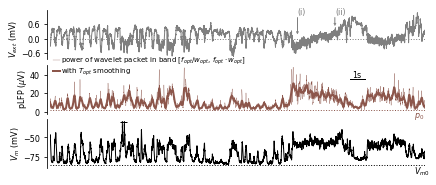

In [57]:
t0, width = 83.5, 25
spikes=-30
vm_color=Grey
LFP_color='k'
T_bar=1.
subsampling = 1 # put to 1 for final figure !!

fig_raw, [ax1, ax2, ax3] = figure(axes_extents=[[[4,1]],[[4,1]],[[4,1]]], figsize=(.9,.65), hspace=.2)
                                 
                                 
# time bar
ax2.plot(t0+width-5+np.arange(2), np.ones(2)*35, 'k-', lw=1)
ax2.annotate('1s', (t0+width-5+.15, 37), fontsize=FONTSIZE)
tn1, tn2 = t0+width-8.5, t0+width-6. 
ax1.arrow(tn1, 0.9, 0., -.6, head_width=0.15, head_length=0.1, fc=Grey, ec=Grey, lw=0.5)
ax1.arrow(tn2, 0.9, 0., -.25, head_width=0.15, head_length=0.1, fc=Grey, ec=Grey, lw=0.5)
ax1.annotate('(i)', (tn1, 1.), fontsize=FONTSIZE, color=Grey)
ax1.annotate('(ii)', (tn2, 1.), fontsize=FONTSIZE, color=Grey)

cond = (data['sbsmpl_t']>t0) & (data['sbsmpl_t']<t0+width)
ax1.plot(data['sbsmpl_t'][cond][::subsampling], data['sbsmpl_Extra'][cond][::subsampling], '-', lw=1, color=Grey)
ax1.plot([t0, t0+width], np.zeros(2), ':', lw=1, color=Grey)
ax2.plot(data['sbsmpl_t'][cond][::subsampling], data['pLFP0'][cond][::subsampling],
         '-', color=Brown, lw=0.3,
         label='power of wavelet packet in band [$f_{opt}$/$w_{opt}$, $f_{opt} \cdot w_{opt}$]')
ax2.plot(data['sbsmpl_t'][cond][::subsampling], data['pLFP'][cond][::subsampling], '-', color=Brown,
         lw=2, label='with $T_{opt}$ smoothing')
ax2.legend(loc=(0,.68), frameon=False, fontsize=FONTSIZE-1, labelspacing=-0.05, handlelength=1, handletextpad=0.2)
ax2.plot([t0, t0+width], data['p0']*np.ones(2), ':', color=Brown, lw=1)
ax2.annotate('$p_{0}$', (.97, -0.07), color=Brown, xycoords='axes fraction', fontsize=FONTSIZE)
# Vm
ax3.plot(data['sbsmpl_t'][cond & (data['sbsmpl_Vm']<spikes)][::subsampling],
         data['sbsmpl_Vm'][cond & (data['sbsmpl_Vm']<spikes)][::subsampling], 'k-', lw=1)
ax3.plot([t0, t0+width], data['p0_Vm']*np.ones(2), ':', color='k', lw=1)
ax3.annotate('$V_{m0}$', (.97, -0.13), color='k', xycoords='axes fraction', fontsize=FONTSIZE)
ispk = np.argwhere((data['Vm'][:-1]<=spikes) & (data['Vm'][1:]>spikes) & (data['t'][1:]>t0)).flatten()
for i in ispk:
    ax3.plot(data['t'][i-10:i], np.concatenate([data['Vm'][i-10:i-1], [spikes]]), 'k-', lw=1)
    ax3.plot([data['t'][i]], [spikes], 'k_', ms=5)
set_plot(ax1, ['left'], xlim=[t0, t0+width], ylabel='$V_{ext}$ (mV)    ', yticks=[-.6,0,.6])
set_plot(ax2, ['left'], xlim=[t0, t0+width], ylabel='pLFP ($\mu$V)', num_yticks=3)
set_plot(ax3, ['left'], xlim=[t0, t0+width], ylabel='$V_{m}$ (mV)', num_yticks=3)

== OPTIMIZATION RESULTS == 
72.78953843983146 1.8348275862068966
39.67105083170668 133.55625311667006


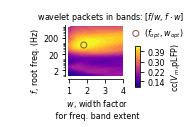

In [21]:
OUTPUT = dict(np.load('cortical_arousal_index/data/final_wvl_scan.npz'))

pCC = np.mean(OUTPUT['CROSS_CORRELS'], axis=-1)

i0, j0 = np.unravel_index(np.argmax(np.mean(OUTPUT['CROSS_CORRELS'], axis=-1), axis=None),
                          pCC.shape)
f0, w0 = OUTPUT['CENTER_FREQUENCIES'][i0], OUTPUT['BAND_LENGTH_FACTOR'][j0]

print('== OPTIMIZATION RESULTS == ')
print(f0, w0)
print(f0/w0, f0*w0)

fig_optimum, ax = figure(figsize=(.8,1.), right=.7, top=.9, bottom=1.2, left=.9)
p = plt.contourf(OUTPUT['BAND_LENGTH_FACTOR'],
                 OUTPUT['CENTER_FREQUENCIES'],
                 pCC,
                 levels=np.linspace(pCC.min(),pCC.max(),30),
                 cmap=plasma)
ax.scatter([w0], [f0], color=Brown, facecolor='None', label='($f_{opt}, w_{opt}$)')
ax.set_title('            wavelet packets in bands: [$f/w$, $f\cdot w$]', fontsize=FONTSIZE)
set_plot(ax,
         yscale='log',
         xlabel=' $w$, width factor\n for freq. band extent',
         ylabel=' $f$, root freq. (Hz)         ',
         yticks=[2, 20, 200], yticks_labels=['2', '20', '200'], xticks=np.arange(1, 5))
ax.legend(loc=(1.02, .65), handletextpad=0, frameon=False)
acb = add_inset(ax, [1.2,-.2,.1,.8])
build_bar_legend(np.unique(np.round(np.linspace(pCC.min(),pCC.max(),5),2)),
                 acb, plasma,
                 color_discretization=30,
                 label='cc($V_m$,pLFP)')

In [22]:
# to run from the script
# args.datafile_input = 'cortical_arousal_index/data/final_smooth.npz'
# [fig_smooth] = plot_test_different_smoothing(args)
OUTPUT = dict(np.load('cortical_arousal_index/data/final_smooth.npz'))

mean_Output = np.mean(OUTPUT['CROSS_CORRELS'], axis=-1)
NORM = np.zeros(OUTPUT['CROSS_CORRELS'].shape)
Tsmooth = 1e3*OUTPUT['T_SMOOTH']
order = np.argsort(np.mean(OUTPUT['CROSS_CORRELS'], axis=0))
for i in range(len(order)):
    NORM[:,order[i]] = (OUTPUT['CROSS_CORRELS'][:,order[i]]-OUTPUT['CROSS_CORRELS'][0,order[i]])/\
        (OUTPUT['CROSS_CORRELS'][:,order[i]].max()-OUTPUT['CROSS_CORRELS'][0,order[i]])
i0 = np.argmax(np.mean(NORM, axis=-1))

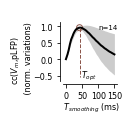

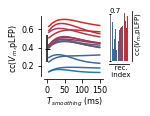

In [50]:
colormap = get_linear_colormap(Blue, Red)
fig_optimum1, ax = figure(right=3.)
fig_optimum2, ax1 = figure(figsize=(1.1, 1.), right=3.5)
for i, c in enumerate(ccVext_ordered):
    ax1.plot(Tsmooth[1:], OUTPUT['CROSS_CORRELS'][1:,order[i]], color=colormap(i/(len(order)-1)))
ax1.errorbar([0], [OUTPUT['CROSS_CORRELS'][0,:].mean()],
             [OUTPUT['CROSS_CORRELS'][0,:].std()], fmt='k_', ms=5)
ax.plot(Tsmooth, np.mean(NORM, axis=-1), color='k', lw=2)
ax.fill_between(Tsmooth,\
                 np.mean(NORM, axis=-1)+np.std(NORM, axis=-1),
                 np.mean(NORM, axis=-1)-np.std(NORM, axis=-1),
                lw=0, color='k', alpha=.2)
i0 = np.argmax(np.mean(NORM, axis=-1))
ax.scatter([1e3*OUTPUT['T_SMOOTH'][i0]], [np.mean(NORM, axis=-1)[i0]],
           marker='o', color=Brown, facecolor='None')
ax.annotate('$T_{opt}$', (Tsmooth[i0]+4, ax.get_ylim()[0]), fontsize=FONTSIZE)
ax.plot(np.array([Tsmooth[i0], Tsmooth[i0]]),
        [np.mean(NORM, axis=-1)[i0], ax.get_ylim()[0]], '--', color=Brown, lw=1)
ax.annotate('n=14', (100, .9), fontsize=FONTSIZE-1)
set_plot(ax, xlabel=' $T_{smoothing}$ (ms)',
         ylabel='cc($V_m$,pLFP)       \n (norm. variations)      ' )
set_plot(ax1, xlabel=' $T_{smoothing}$ (ms)',
         ylabel='cc($V_m$,pLFP)   ')

inset = plt.axes([.8,.5,.15,.5])
for i, c in enumerate(ccVext_ordered):
    inset.bar([i], [DATA[c]['cc-Vm-pLFP']],color=colormap(i/(len(order)-1)))
inset.plot([-1.5, -1.5], [0.,0.7], 'k-_',  lw=0.5, ms=2)
inset.annotate('0.7', (-2,0.72), fontsize=FONTSIZE-1)
set_plot(inset, ['bottom', 'right'], xlabel='  rec.\n index',
         fontsize=FONTSIZE-1, xticks=[], yticks=[], ylabel='  cc($V_m$,pLFP)')

In [58]:
from graphs.plot_export import put_list_of_figs_to_svg_fig, export_as_png
put_list_of_figs_to_svg_fig([fig_raw, fig_optimum, fig_optimum2, fig_optimum1],
                            fig_name='Figures/Fig_pLFP_design.svg',
                            figsize=(0.593,0.261),
                            fontsize=FONTSIZE+1,
                            Props={'XCOORD':[10, 15, 175, 335],
                                   'YCOORD':[-5]+list(np.ones(3)*170),
                                   'XCOORD_LABELS':[-10, -10, 170, 312],
                                   'YCOORD_LABELS':[-5]+list(np.ones(3)*165),
                                   'LABELS':['a','b', 'c', 'd']}, visualize=False)
export_as_png(os.getcwd()+'/Figures/Fig_pLFP_design.svg', dpi=200)

In [16]:
from IPython.display import Image
#Image(filename='paper/Figures/Fig_pLFP_design.png', width=30)

# Designing a Network States Index (NSI)

### Cell 1

In [10]:
nice_cell_data = load_data('../sparse_vs_balanced/sparse_vs_balanced/data/Wild_Type/Cell14/17o27001.abf',
                 args,
                 chosen_window_only=True,
                 full_processing=True,
                 with_Vm_low_freq=True)

In [18]:
#Zooms=[x-70+np.arange(2)*2 for x in [154.5, 90.2, 115.5, 128., 189.8, 216.6]]
# Zooms=[x+np.arange(2)*1.5 for x in [84.9, 20.5, 18.3, 45.5, 58.1, 119.9, 146.6]]
# Zooms=[x+np.arange(2)*1.5 for x in [84.9, 20.5, 18.3, 45.5, 108.1, 63.5, 120.1, 146.6]]
# Zooms=[x+np.arange(2)*1.5 for x in [84.9, 20.5, 18.3, 45.5, 58.1, 119.9, 146.6]]
# fig_large, _ = show_raw_data_large_scale(nice_cell_data, Zooms, tstart=12, twidth=168);
# fig_large.savefig(desktop+'0.svg')

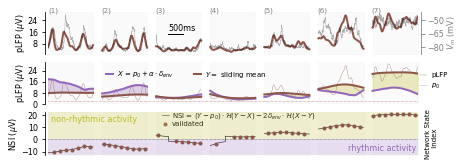

In [11]:
def zoom_over_episodes(data,
                       highlighted_episodes=[],
                       tspace=.3,
                       tstart=12, twidth=168,
                       Vm_color=Grey, pLFP_color=Brown,
                       Vm_ticks=[-80, -65, -50],
                       pLFP_ticks=[0., 0.3],
                       pLFP_scale=0.8, Vm_scale=30,
                       Tscale=0.5,
                       Tbar_loc=(4, -65)):

    fig, [ax1, ax2, ax3] = figure(axes_extents=[[[4,2]], [[4,2]], [[4,2]]], figsize=(.95,.3), hspace=.4, right=2.5)
    axVm = ax1.twinx()
    AX = [ax1, ax2, ax3]
    DELTA, GAMMA, DEPOL, STD_LFP, NSI = [], [], [], [], []

    low_freqs_pow = args.alpha*np.max(np.abs(nice_cell_data['pLFP_W_low_freqs']), axis=0)
    
    YLIMS = [[np.inf,-np.inf] for i in range(len(AX))]
    for n, interval in enumerate(highlighted_episodes):
        ax1.annotate('(%i)'%(n+1), (n/len(highlighted_episodes)*1.02,.99), color=Grey, xycoords='axes fraction', fontsize=FONTSIZE-1)
        
        cond = (data['t']>interval[0]) & (data['t']<interval[1])
        new_t = data['t'][cond]-data['t'][cond][0]+n*(interval[1]-interval[0]+tspace)
        axVm.plot(new_t[::5], data['Vm'][cond][::5], color='k', lw=0.5, alpha=.3)
        
        cond = (data['sbsmpl_t']>interval[0]) & (data['sbsmpl_t']<interval[1])
        new_t = data['sbsmpl_t'][cond]-data['sbsmpl_t'][cond][0]+n*(interval[1]-interval[0]+tspace)
        ax1.plot(new_t, data['pLFP'][cond], color=pLFP_color, lw=2)
        a1, = ax2.plot(new_t, data['pLFP'][cond], color=pLFP_color, lw=0.3)
        a2, = ax2.plot(new_t, low_freqs_pow[cond]+data['p0'], color=Purple, lw=2)
        a3, = ax2.plot(new_t, data['pLFP_sliding_mean'][cond], color=Brown, lw=2)
        a4, = ax3.plot(new_t, data['NSI'][cond], color='k', lw=0.5)
        x, y = low_freqs_pow[cond]+data['p0'], data['pLFP_sliding_mean'][cond]
        ax2.fill_between(new_t[x-y>0], x[x-y>0], y[x-y>0], color=Purple, alpha=.3)
        ax2.fill_between(new_t[x-y<0], x[x-y<0], y[x-y<0], color=Kaki, alpha=.3)
        cond2 = (data['sbsmpl_t'][data['NSI_validated']]>interval[0]) & (data['sbsmpl_t'][data['NSI_validated']]<interval[1])
        new_t = data['sbsmpl_t'][data['NSI_validated']][cond2]-data['sbsmpl_t'][cond][0]+\
            n*(interval[1]-interval[0]+tspace)
        a5, = ax3.plot(new_t, data['NSI'][data['NSI_validated']][cond2], 'o', color=Brown, ms=3)
        
        DEPOL.append(np.mean(data['Vm_sliding_mean'][cond]))
        NSI.append(data['NSI'][data['NSI_validated']][cond2][int(len(new_t)/2)])

    YLIMS = [[np.min([AX[i].get_ylim()[0],YLIMS[i][0]]),np.max([AX[i].get_ylim()[1],YLIMS[i][1]])] for i in range(len(AX))]

    for n, interval in enumerate(highlighted_episodes):
        for i in range(len(AX)):
            AX[i].fill_between(n*(interval[1]-interval[0]+tspace)+np.arange(2)*(interval[1]-interval[0]),
                               YLIMS[i][0]*np.ones(2), YLIMS[i][1]*np.ones(2), color='lightgray', alpha=0.1)
        
    set_plot(axVm, ['right'], xlim=[0, (n+1)*(interval[1]-interval[0])+n*tspace], yticks=[-80, -65, -50],
                     ycolor=Grey, ylabel='$V_m$ (mV)')
    
    set_plot(ax1, ['left'], xlim=[0, (n+1)*(interval[1]-interval[0])+n*tspace], ylim=YLIMS[0], ylabel='pLFP ($\mu$V)')
    set_plot(ax2, ['left'], xlim=[0, (n+1)*(interval[1]-interval[0])+n*tspace], ylim=[0,YLIMS[1][1]], ylabel='pLFP ($\mu$V)')
    ap0, = ax2.plot(ax2.get_xlim(), np.ones(2)*data['p0'], ':', color='Brown', lw=0.5)
    
    ax3.annotate('Network State \n     Index', (1.02, .85), xycoords='axes fraction', rotation=90, fontsize=FONTSIZE-1)
    set_plot(ax3, ['left'], xlim=[0, (n+1)*(interval[1]-interval[0])+n*tspace], ylim=YLIMS[2], ylabel='NSI ($\mu$V)')
    ax3.plot(ax3.get_xlim(), np.zeros(2), 'k:', lw=0.5)
    ax3.fill_between(ax3.get_xlim(), np.zeros(2), np.ones(2)*ax3.get_ylim()[1], lw=0, color=Kaki, alpha=0.2)
    ax3.fill_between(ax3.get_xlim(), np.zeros(2), np.ones(2)*ax3.get_ylim()[0], lw=0, color=Purple, alpha=0.2)
    ax3.annotate('rhythmic activity', (10, -9), color=Purple, fontsize=FONTSIZE)
    ax3.annotate('non-rhythmic activity', (0.1, 14), color=Kaki, fontsize=FONTSIZE)
    
    axVm.plot([Tbar_loc[0], Tbar_loc[0]+Tscale], Tbar_loc[1]*np.ones(2), 'k-', lw=1)
    axVm.annotate(str(int(1e3*Tscale))+'ms', (Tbar_loc[0], Tbar_loc[1]+3), fontsize=FONTSIZE)
    ax2.legend([a1, ap0], ['pLFP', '$p_0$'], columnspacing=1.5, handletextpad=.5, handlelength=1., ncol=1, loc=(1.,.25), frameon=False, fontsize=FONTSIZE-1)
    ax3.legend([a2, a3], [r'$X$ = $p_0+\alpha \cdot \delta_{env}$', '$Y=$ sliding mean'], columnspacing=3., handletextpad=.5, handlelength=1., ncol=2, loc=(0.15,1.7), frameon=False, fontsize=FONTSIZE-1)
    ax1.legend([a4, a5], [r'NSI = $(Y-p_0) \cdot \mathcal{H}(Y-X) - 2 \delta_{env} \cdot \mathcal{H}(X-Y) $', 'validated'], columnspacing=3., handletextpad=.5, handlelength=1., labelspacing=0.05, ncol=1, loc=(0.3,-1.8), frameon=False, fontsize=FONTSIZE-1)
        
    return fig, AX, np.array(DEPOL), np.array(NSI)
    
Zooms=[x+np.arange(2)*1.5 for x in [84.99, 20.3, 18.3, 45.5, 151.3, 120.1, 146.6]]
fig_episodes, AX, DEPOL, NSI = zoom_over_episodes(nice_cell_data,
                                                  highlighted_episodes=Zooms)
#fig_episodes.savefig(desktop+'fig.png', dpi=300)

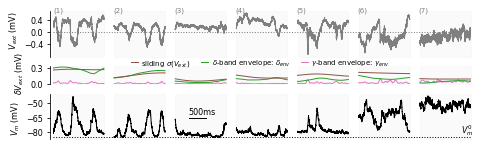

In [30]:
zoom_over_episodes0(nice_cell_data,
                    highlighted_episodes=Zooms);

In [124]:
%run cortical_arousal_index/exp_data.py
from data_analysis.processing.signanalysis import gaussian_smoothing
# saving a reduced dataset per cell
DATA = []
for i in np.arange(1, 15):
    data = dict(np.load('cortical_arousal_index/data/reduced_data_cell_'+str(i)+'.npz'))
    data['Vm_sliding_mean'] = gaussian_smoothing(data['sbsmpl_Vm'], int(args.T_sliding_mean/data['sbsmpl_dt']))
    DATA.append(data)

<Figure size 432x288 with 0 Axes>

In [12]:
cell_colormap = get_linear_colormap(Blue, Orange)

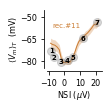

In [13]:
example2_index = 10
fig_single_example_nsi, ax = figure(figsize=(.85,1))

bins = np.linspace(-15, 25, 30)
xbins = np.digitize(nice_cell_data['NSI'], bins=bins)
cbins = .5*(bins[1:]+bins[:-1]) # center of bins
depol_hist_mean, depol_hist_std = 0*cbins, 0*cbins
for i in range(len(cbins)):
    cond = (xbins==i) & nice_cell_data['NSI_validated']
    if np.sum(cond)>8:
        depol_hist_mean[i] = np.mean(nice_cell_data['Vm_sliding_mean'][cond])
        depol_hist_std[i] = np.std(nice_cell_data['Vm_sliding_mean'][cond])

def plot_numbered_dot(x, y, i, ax, size=1500):
    ax.plot([x], [y], 'o', color=Grey, ms=8, alpha=.3)
    ax.annotate(str(i), (x, y), fontsize=FONTSIZE-1, color='k', ha='center', va='center', fontweight='bold')

plot(cbins[depol_hist_std>0], depol_hist_mean[depol_hist_std>0], sy=depol_hist_std[depol_hist_std>0], ax=ax,
     color=cell_colormap(example2_index/(len(DATA)-1)))
    
for i in range(len(DEPOL)):
    plot_numbered_dot(NSI[i], DEPOL[i], str(i+1), ax)

ax.annotate('rec.#'+str(example2_index+1), (.1, .7), color=cell_colormap(example2_index/(len(DATA)-1)),
            xycoords='axes fraction', fontsize=FONTSIZE-1)
set_plot(ax,
         ylabel=r'$ \langle V_m \rangle_T$  (mV)',
         yticks=[-80, -65, -50],
         ylim=[-85, -45],
         xticks=[-10, 0, 10, 20],
         xlabel='NSI ($\mu$V)')

In [14]:
# order them by the amount of Vext-Vm correlation
ccs = []
for i in range(len(DATA)):
    ccs.append(np.abs(DATA[i]['cc-Vm-LFP']))
cc_ordered = np.argsort(ccs)#[::-1]
cc_ordered                

array([ 1, 12,  2,  4, 11, 10,  3, 13,  7,  8,  5,  0,  9,  6])

In [15]:
def compute_relationship_smooth_and_plot(cbins, pop_hist, num_hist, ax,
                                         Nsmooth = 10):
    
    x, y, sy = [], [], []
    for xx, ph, N in zip(cbins, pop_hist, num_hist):
        if len(ph)>1:
            x.append(xx)
            y.append(np.sum(np.array(ph)*np.array(N)/np.sum(N)))
            sy.append(np.sqrt(np.sum((np.array(ph)-y[-1])**2*np.array(N)/np.sum(N))))
    
    xx, yy, ss = np.linspace(np.min(x), np.max(x), int(Nsmooth/2*len(x))), np.zeros(int(Nsmooth/2*len(x))), np.zeros(int(Nsmooth/2*len(x)))
    for i in range(len(xx)):
        i0 = np.argmin((xx[i]-x)**2)
        yy[i], ss[i] = y[i0], sy[i0]
    
    yy, ss = gaussian_smoothing(yy, Nsmooth), gaussian_smoothing(ss, Nsmooth)
    ax.plot(xx, yy, 'k-', lw=1.5)
    ax.fill_between(xx, yy+ss, yy-ss, color='k', alpha=.5, lw=0)


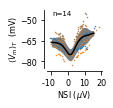

In [32]:
# same on all data
fig_all_nsi, ax = figure(figsize=(.85,1))
bins = np.linspace(-20, 25, 60)
cbins = .5*(bins[1:]+bins[:-1]) # center of bins
pop_hist = [[] for i in range(len(cbins))]
num_hist = [[] for i in range(len(cbins))]
for c, data in enumerate(DATA):
    xbins = np.digitize(data['NSI'], bins=bins)
    depol_hist_mean = 0*cbins
    for i in range(len(cbins)):
        cond = (xbins==i) & data['NSI_validated']
        if np.sum(cond)>10:
            depol_hist_mean[i] = np.mean(data['Vm_sliding_mean'][cond])
            pop_hist[i].append(depol_hist_mean[i])
            num_hist[i].append(1)#np.sum(cond))
            # num_hist[i].append(10)
    ax.plot(cbins[depol_hist_mean<0], depol_hist_mean[depol_hist_mean<0], 'o', ms=.5,\
                    color=cell_colormap(cc_ordered[c]/(len(DATA)-1)))

# smoothing this relationship
compute_relationship_smooth_and_plot(cbins, pop_hist, num_hist, ax)

ax.annotate('n=14', (0.1,.9), xycoords='axes fraction', fontsize=FONTSIZE-1)
set_plot(ax,
         ylabel=r'$ \langle V_m \rangle_T$  (mV)',
         yticks=[-80, -65, -50],
         xticks=[-10, 0, 10, 20],xticks_labels=['-10  ', '0', ' 10', '20'],
         xlabel='NSI ($\mu$V)')
#fig_all_nsi.savefig(desktop+'fig2.svg')
fig_all_nsi.savefig(desktop+'fig.png', dpi=300)


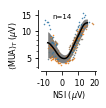

In [35]:

# same on all data
fig_all_mua, ax = figure(figsize=(.85,1))

bins = np.linspace(-16, 25, 60)
cbins = .5*(bins[1:]+bins[:-1]) # center of bins

pop_hist = [[] for i in range(len(cbins))]
num_hist = [[] for i in range(len(cbins))]
for c, data in enumerate(DATA):
    xbins = np.digitize(data['NSI'], bins=bins)
    depol_hist_mean = 0*cbins
    for i in range(len(cbins)):
        cond = (xbins==i) & data['NSI_validated']
        if np.sum(cond)>10:
            depol_hist_mean[i] = 1e6*np.mean(data['sbsmpl_MUA'][cond])
            pop_hist[i].append(depol_hist_mean[i])
            num_hist[i].append(1)
    ax.plot(cbins[depol_hist_mean>0], depol_hist_mean[depol_hist_mean>0], 'o', ms=0.5,\
                    color=cell_colormap(cc_ordered[c]/(len(DATA)-1)))
            
compute_relationship_smooth_and_plot(cbins, pop_hist, num_hist, ax)
        
ax.annotate('n=14', (0.2,.85), xycoords='axes fraction', fontsize=FONTSIZE-1)
set_plot(ax,
         yscale='log',
         ylabel=r'$\langle$MUA$\rangle_T$ ($\mu$V)     ',
         yticks=[5, 10, 15], yticks_labels=['5', '10', '15'],
         ylim=[3.9,17],
         xticks=[-10, 0, 10, 20],xticks_labels=['-10  ', '0', ' 10', '20'],
         xlabel='NSI ($\mu$V)')
fig_all_mua.savefig(desktop+'fig.png', dpi=300)


In [28]:
NSI_episodes, Depol_episodes  = [], []
cond = (data['pLFP']<data['p0'])
Vm0 = np.mean(data['sbsmpl_Vm'][cond])
                                    
for z in [Zooms[3], Zooms[0]]:                                    
   ii = np.argmin(np.abs(data['sbsmpl_t']-z.mean()))
   Depol_episodes.append(data['Vm_max_low_freqs_power'][ii]) # enveloppe of [2,5]Hz
   NSI_episodes.append(data['NSI'][ii])
for z in [Zooms[1], Zooms[2], Zooms[4], Zooms[5]]:                                    
   ii = np.argmin(np.abs(data['sbsmpl_t']-z.mean()))
   Depol_episodes.append(np.mean(data['sbsmpl_Vm'][ii-int(args.Tstate/data['sbsmpl_dt']/2):ii+int(args.Tstate/data['sbsmpl_dt']/2)])-Vm0)
   NSI_episodes.append(data['NSI'][ii])                                    

## Cell 3

In [240]:
data2 = load_data('../sparse_vs_balanced/sparse_vs_balanced/data/Wild_Type/Cell10/17o26001.abf',
                 args,
                 chosen_window_only=True,
                 full_processing=True,
                 with_Vm_low_freq=True)

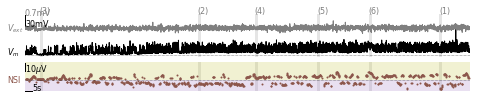

In [241]:
Zooms2=[x+np.arange(2)*2 for x in [279.2, 116.5, 10, 155, 197, 231.7]]
fig_large2, _ = show_raw_data_large_scale(data2, Zooms2, tstart=0, twidth=300);

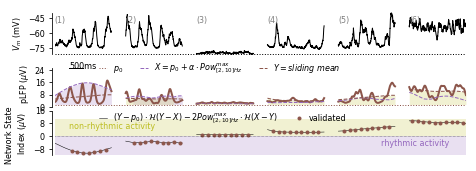

In [242]:
fig_zoom2 = show_raw_LFP_and_pLFP(data2, Zooms2, alpha=args.alpha, Tspace=0.5);

In [243]:
Zooms2=[x+np.arange(2)*2 for x in [279.2, 116.5, 10, 155, 197, 231.7]]
NSI_episodes2, Depol_episodes2  = [], []
cond2 = (data2['pLFP']<data2['p0'])
Vm0 = np.mean(data2['sbsmpl_Vm'][cond2])
                                    
for z in [Zooms2[3], Zooms2[0]]:                                    
   ii = np.argmin(np.abs(data2['sbsmpl_t']-z.mean()))
   Depol_episodes2.append(data2['Vm_max_low_freqs_power'][ii]) # enveloppe of [2,5]Hz
   NSI_episodes2.append(data2['NSI'][ii])
for z in [Zooms2[1], Zooms2[2], Zooms2[4], Zooms2[5]]:                                    
   ii = np.argmin(np.abs(data2['sbsmpl_t']-z.mean()))
   Depol_episodes2.append(np.mean(data2['sbsmpl_Vm'][ii-int(args.Tstate/data2['sbsmpl_dt']/2):ii+int(args.Tstate/data2['sbsmpl_dt']/2)])-Vm0)
   NSI_episodes2.append(data2['NSI'][ii])                                    

## Population analysis

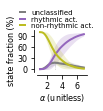

In [36]:
OUTPUT = dict(np.load('cortical_arousal_index/data/final_alpha.npz'))
fig_state, ax1 = figure(figsize=(.8, 1.), top=3.)
mean_synch, std_synch, mean_nc, std_nc,\
    mean_asynch, std_asynch, alpha = [], [], [], [], [], [], []
for i in range(OUTPUT['VM_LOW_FREQ_POWER'].shape[0]):
    mean_synch.append(np.mean(OUTPUT['N_LOW_FREQ'][i,:]/\
                              (OUTPUT['N_LOW_FREQ'][i,:]+OUTPUT['N_ASYNCH'][i,:]+OUTPUT['N_NC'][i,:])))
    std_synch.append(np.std(OUTPUT['N_LOW_FREQ'][i,:]/\
                            (OUTPUT['N_LOW_FREQ'][i,:]+OUTPUT['N_ASYNCH'][i,:]+OUTPUT['N_NC'][i,:])))
    mean_nc.append(np.mean(OUTPUT['N_NC'][i,:]/\
                              (OUTPUT['N_LOW_FREQ'][i,:]+OUTPUT['N_ASYNCH'][i,:]+OUTPUT['N_NC'][i,:])))
    std_nc.append(np.std(OUTPUT['N_NC'][i,:]/\
                            (OUTPUT['N_LOW_FREQ'][i,:]+OUTPUT['N_ASYNCH'][i,:]+OUTPUT['N_NC'][i,:])))
    mean_asynch.append(np.mean(OUTPUT['N_ASYNCH'][i,:]/\
                              (OUTPUT['N_LOW_FREQ'][i,:]+OUTPUT['N_ASYNCH'][i,:]+OUTPUT['N_NC'][i,:])))
    std_asynch.append(np.std(OUTPUT['N_ASYNCH'][i,:]/\
                            (OUTPUT['N_LOW_FREQ'][i,:]+OUTPUT['N_ASYNCH'][i,:]+OUTPUT['N_NC'][i,:])))
    # std.append(np.std(OUTPUT['VM_LOW_FREQ_POWER'][i,:][cond]))
    alpha.append(OUTPUT['ALPHA'][i])
for mean, std, color, label in zip([mean_nc, mean_synch, mean_asynch],\
                                   [std_nc, std_synch, std_asynch],\
                                   [Grey, Purple, Kaki],
                                   ['unclassified', 'rhythmic act.', 'non-rhythmic act.']):
    ax1.plot(alpha, 100.*np.array(mean), color=color, lw=2, label=label)
    ax1.fill_between(alpha, 100.*np.array(mean)+100.*np.array(std),
                     100.*np.array(mean)-100.*np.array(std), color=color, alpha=.2, lw=0)
aa = np.array(alpha)[np.argwhere(np.array(mean_nc)>=.9*max(mean_nc)).flatten()]
# update_study_output('alpha_opt_of_max_unclassified', str(round(alpha[np.argmax(mean_nc)],2)))
ax1.plot(alpha[np.argmax(mean_nc)]*np.ones(2), [0, 100*max(mean_nc)], ':', color=Grey, lw=0.5)
try:
    ax1.plot(alpha0*np.ones(2), [0, 100*max(mean_nc)], ':', color=Brown, lw=0.5)
    update_study_output('fraction_unclassified_for_alpha_opt', str(round(100*mean_nc[np.argmin(np.abs(alpha-alpha0))]/np.max(mean_nc),1)))
except NameError: # need to run the Cell below !
    pass
set_plot(ax1, xlabel='$\\alpha$ (unitless)', ylabel='state fraction (%)')
ax1.legend(loc=(-0.4,0.95), prop={'size':FONTSIZE-1}, frameon=False, labelspacing=0.1, handlelength=.7)

2.87


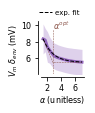

In [37]:
OUTPUT = dict(np.load('cortical_arousal_index/data/final_alpha.npz'))
fig_lf, ax2 = figure(figsize=(.75, 1.), top=1.5)
mean, std, alpha = [], [], []
for i in range(OUTPUT['VM_LOW_FREQ_POWER'].shape[0])[3::2]:
    cond = np.isfinite(OUTPUT['VM_LOW_FREQ_POWER'][i,:]) & (OUTPUT['N_LOW_FREQ'][i,:]>10)
    mean.append(np.mean(OUTPUT['VM_LOW_FREQ_POWER'][i,:][cond]))
    std.append(np.std(OUTPUT['VM_LOW_FREQ_POWER'][i,:][cond]))
    alpha.append(OUTPUT['ALPHA'][i])
ylim = [4.1,10.5]
color=Purple    
ax2.plot(alpha, np.array(mean), color=Purple, lw=3)
ax2.fill_between(alpha, np.array(mean)+np.array(std),
                 np.array(mean)-np.array(std), color=Purple, alpha=.3, lw=0)
# exponential fit
def exp(x, p):
    return p[2]+p[1]*np.exp(-np.array(x)/p[0])
def to_minimize(p):
    return np.sum(np.abs(mean-exp(np.array(alpha)-alpha[0], p)))
from scipy.optimize import minimize
plsq = minimize(to_minimize, [2., 5., 5.])
ax2.plot(np.ones(2)*(alpha[0]+plsq.x[0]), [ylim[0], ylim[1]-1], '--', color=Brown, lw=.5)
ax2.annotate('$\\alpha^{opt}$', (alpha[0]+plsq.x[0], ylim[1]-1), color=Brown, fontsize=FONTSIZE)
ax2.plot((alpha[0], alpha[0]+plsq.x[0], alpha[-1]), [mean[0], plsq.x[2], plsq.x[2]], '--', color=Brown, lw=.5)
ax2.plot(alpha, exp(alpha-alpha[0], plsq.x), '--', color='k', lw=1, label='exp. fit')
ax2.legend(loc=(-.1,1.05), frameon=False, prop={'size':FONTSIZE-1}, handlelength=1.8, handletextpad=0.5)
set_plot(ax2, xlabel='$\\alpha$ (unitless)', ylabel='$V_m$ $\delta_{env}$ (mV)   ', ylim=ylim)
alpha0 = alpha[0]+plsq.x[0]
print(round(alpha0,2))
update_study_output('alpha_opt', str(round(alpha0,2)))

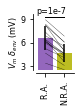

In [89]:
fig_pow, ax3 = figure(figsize=(.7, 1))

i0 = np.argmin(np.abs(OUTPUT['ALPHA']-alpha0))
bottom =2.5
for i in range(OUTPUT['VM_LOW_FREQ_POWER'].shape[1]):
    ax3.plot([0,1], [OUTPUT['VM_LOW_FREQ_POWER'][i0-1,i],OUTPUT['VM_LOW_FREQ_POWER_ASYNCH'][i0-1,i]], 'k-', lw=0.3)
ax3.bar([0], [np.mean(OUTPUT['VM_LOW_FREQ_POWER'][i0-1,:])-bottom], color=Purple,
        yerr=[np.std(OUTPUT['VM_LOW_FREQ_POWER'][i0-1,:])], bottom=bottom, lw=1)
ax3.bar([1], [np.mean(OUTPUT['VM_LOW_FREQ_POWER_ASYNCH'][i0-1,:])-bottom], color=Kaki,
        yerr=[np.std(OUTPUT['VM_LOW_FREQ_POWER_ASYNCH'][i0-1,:])], bottom=bottom, lw=1)
from scipy.stats import ttest_rel
ax3.plot([0,1], ax3.get_ylim()[1]*np.ones(2), 'k-', lw=1)
update_study_output('pvalue_decrease_in_slow_power_Vm_synch_to_asynch', sci_str(ttest_rel(OUTPUT['VM_LOW_FREQ_POWER'][i0-1,:],\
                                                                OUTPUT['VM_LOW_FREQ_POWER_ASYNCH'][i0-1,:]).pvalue, rounding=1))
ax3.annotate('p='+\
             sci_str(ttest_rel(OUTPUT['VM_LOW_FREQ_POWER'][i0-1,:],\
                               OUTPUT['VM_LOW_FREQ_POWER_ASYNCH'][i0-1,:]).pvalue, rounding=0),
             (0,1.),xycoords='axes fraction', fontsize=FONTSIZE)
set_plot(ax3, yticks=[3,6,9], ylabel='$V_m$ $\delta_{env}$ (mV)',
         xticks=[0,1], xticks_labels=['R.A. ','N.R.A.'], xticks_rotation=90)

In [38]:
from graphs.plot_export import put_list_of_figs_to_svg_fig, export_as_png
put_list_of_figs_to_svg_fig([fig_episodes, fig_state, fig_lf, fig_single_example_nsi, fig_all_nsi, fig_all_mua],
                            fig_name='Figures/Fig_NSI_design.svg',
                            figsize=(0.65,0.35),
                            Props={'XCOORD':[20, 0, 100, 185, 285, 385],
                                   'YCOORD':[0]+list(np.ones(5)*165),
                                   'XCOORD_LABELS':np.array([0, 0, 100, 185, 285, 385])-10,
                                   'YCOORD_LABELS':[0]+list(np.ones(5)*155),
                                   'LABELS':['a','b', 'c', 'd', 'e', 'f']}, visualize=False)
export_as_png(os.getcwd()+'/Figures/Fig_NSI_design.svg', dpi=200)

# NSI on all cells and NSI accuracy

In [606]:
def lin_func(x, p):
    return p*x
def affine_func(x, p):
    return p[1]*x+p[0]

from scipy.optimize import minimize
def get_accepted_samples(data, pLFP_tol=2.85, Vm_noise_tol=2.):
    """
    to find the best linear fit, we try it both with a linear (f=a*x) and affine (f=a*x+b) function
    """
    cond = data['NSI_validated']
    x,y = np.array(data['NSI'][cond]), np.array(data['Vm_NSI'][cond])
    # try with both linear and affine func
    def to_minimize1(p):
        return np.sum(np.abs(lin_func(x,p)-y))
    res1 = minimize(to_minimize1, [1.])
    correct_cond1 = (y+Vm_noise_tol>=lin_func(x-pLFP_tol, res1.x)) & (y-Vm_noise_tol<=lin_func(x+pLFP_tol, res1.x))
    def to_minimize2(p):
        return np.sum(np.abs(affine_func(x,p)-y))
    res2 = minimize(to_minimize2, [0., 1.])
    correct_cond2 = (y+Vm_noise_tol>=affine_func(x-pLFP_tol, res2.x)) & (y-Vm_noise_tol<=affine_func(x+pLFP_tol, res2.x))
    if len(x[correct_cond1])>len(x[correct_cond2]):
        return correct_cond1, lin_func, res1.x
    else:
        return correct_cond2, affine_func, res2.x
    
def get_correct_percentage(data, pLFP_tol=2.85, Vm_noise_tol=2.):
    correct_cond, func, p = get_accepted_samples(data, pLFP_tol=pLFP_tol, Vm_noise_tol=Vm_noise_tol)
    correct_percent = 100.*len(data['NSI'][data['NSI_validated']][correct_cond])/len(data['NSI'][data['NSI_validated']])
    return correct_percent, func, p

def make_check_plot(data, ax0, ax,
                    error_index=None,
                    xlim=[-15,20], ylim=[-25,35],
                    noise_factor=0,
                    pLFP_tol=2.85,
                    Vm_noise_tol=2):

    if noise_factor>0:
        pLFP_tol = noise_factor*data['p0'] # else given value
    x, y = np.array(data['NSI'][data['NSI_validated']]), np.array(data['Vm_NSI'][data['NSI_validated']])
    ax.plot(x[::2], y[::2], 'k.', ms=0.5)
    ax.plot(xlim, ylim, 'w.', ms=0.005) # just ot have the limits on all plots
    correct_percent, func, p = get_correct_percentage(data, pLFP_tol=pLFP_tol, Vm_noise_tol=Vm_noise_tol)       
    ax.plot(xlim, func(np.array(xlim), p), '-', lw=1, color=Green)
    ax.annotate('  correct:'+str(round(correct_percent,1))+'%', (-.4, 1.1), xycoords='axes fraction', fontsize=FONTSIZE-1)
    ax.fill_between([2*xlim[0], 2*xlim[1]],
                    func(np.array([2*xlim[0]-pLFP_tol, 2*xlim[1]-pLFP_tol]), p)-Vm_noise_tol,
                    func(np.array([2*xlim[0]+pLFP_tol, 2*xlim[1]+pLFP_tol]), p)+Vm_noise_tol,
                    color=Green, alpha=.2, lw=0)
    y1, y2 = ax.get_ylim()                             
    ax.fill_between([2*xlim[0]+pLFP_tol, 2*xlim[1]], y1*np.ones(2),
                    func(np.array([2*xlim[0], 2*xlim[1]-pLFP_tol]), p)-Vm_noise_tol,
                    color=Red, alpha=.2, lw=0)
    ax.fill_between([xlim[0]-pLFP_tol, xlim[1]], y2*np.ones(2),
                    func(np.array([xlim[0], xlim[1]+pLFP_tol]), p)+Vm_noise_tol,
                    color=Red, alpha=.2, lw=0)
    
    if error_index is not None:
        cond, _, _ = get_accepted_samples(data, pLFP_tol=pLFP_tol, Vm_noise_tol=Vm_noise_tol)
        error_cond = np.invert(cond)
        ax0.plot(data['sbsmpl_t'][data['NSI_validated']][error_cond][error_index],
                 data['NSI'][data['NSI_validated']][error_cond][error_index], 'rx', ms=5)
        ax.plot(data['NSI'][data['NSI_validated']][error_cond][error_index],
                data['Vm_NSI'][data['NSI_validated']][error_cond][error_index], 'rx', ms=5)

    
from graphs.scaling import cm2inch
def construct_fig():
    fig = plt.figure(figsize=cm2inch(17,3))
    plt.subplots_adjust(wspace=0., hspace=0, top=1., right=1., left=0, bottom=0)
    W1, W2, WS, H1, H2, H3 = 30, 3, 2, 7, 3, 5
    ax = plt.subplot2grid((H1+H2+3, W1+2*W2+3*WS), (0,0), colspan=W1, rowspan=H1)
    axNSI = plt.subplot2grid((H1+H2+3, W1+2*W2+3*WS), (H1,0), colspan=W1, rowspan=H2)
    axHist = plt.subplot2grid((H1+H2+3, W1+2*W2+3*WS), (1,W1+WS), colspan=W2, rowspan=H3)
    axCV = plt.subplot2grid((H1+H2+3, W1+2*W2+3*WS), (1,W1+W2+3*WS), colspan=W2, rowspan=H3)
    return fig, ax, axNSI, axHist, axCV
#construct_fig();

In [706]:

def show_raw_data_Vm_Vext_NSI(DATA, icell=0,
                              tstart=0, twidth=60,
                              Vext_loc=0., # in mV
                              Vm_scale=20, # in mV
                              Vext_scale=0.5, # in mV
                              NSI_scale=10, # in uV
                              Vm_color='k', Vext_color=Grey, NSI_color=Brown,
                              NSI_lim=[-16,23], NSIVm_lim=[-28,35],
                              nospike=False,
                              spike_threshold=-35,
                              bar_loc = (5,-20),
                              bar_loc2 = (10, -14),
                              colormap=get_linear_colormap(Blue, Red),
                              error_index = None,
                              bar_orientation='right-top',
                              Tscale=1.,
                              subsampling=10):

    data =DATA[icell]
    fig, ax, axNSI, axHist, axCV = construct_fig()
    
    cond = (data['sbsmpl_t']>tstart) & (data['sbsmpl_t']<tstart+twidth)
    ######### Vext plot ##########
    ax.plot(data['sbsmpl_t'][cond][::subsampling],
            data['sbsmpl_Extra'][cond][::subsampling]*Vm_scale/Vext_scale+Vext_loc,
            color=Vext_color, lw=1)
    ax.plot([tstart, tstart+twidth], np.zeros(2)+Vext_loc, ':', color=Vext_color, lw=1)
    ######### Vm plot ##########
    t_for_plot, Vm_for_plot = data['sbsmpl_t'][cond][::subsampling], data['sbsmpl_Vm'][cond][::subsampling]
    # dealing with spikes
    if nospike:
        Vm_for_plot[Vm_for_plot>spike_threshold] = spike_threshold
    else:
        condS = (data['tspikes']>tstart) & (data['tspikes']<tstart+twidth)
        for tspike, vspike in zip(data['tspikes'][condS], data['Vpeak_spikes'][condS]):
            ispike = np.argmin((tspike-t_for_plot)**2)
            ax.plot([tspike, tspike], [Vm_for_plot[ispike], vspike], color=Vm_color, lw=1)
    ax.plot(t_for_plot, Vm_for_plot, color=Vm_color, lw=1)
    ax.plot([tstart, tstart+twidth], np.ones(2)*data['p0_Vm'], ':', color=Vm_color, lw=1)

    # NSI plot
    axNSI.fill_between([tstart, tstart+twidth], np.zeros(2), np.ones(2)*NSI_lim[0], color=Purple, lw=0, alpha=.3)
    axNSI.fill_between([tstart, tstart+twidth], np.zeros(2), np.ones(2)*NSI_lim[1], color=Kaki, lw=0, alpha=.3)
    cond_nsi = data['NSI_validated'] & cond
    axNSI.plot(data['sbsmpl_t'][cond_nsi], data['NSI'][cond_nsi], 'o', color=Brown, ms=1)
    axHist.hist(data['NSI'][data['NSI_validated']],
                color=colormap(data['ccpLFP_rank']/(len(DATA)-1)), bins=np.linspace(*NSI_lim, 30))

    bar_loc = (bar_loc[0]+tstart, bar_loc[1])
    bar_loc2 = (bar_loc2[0]+tstart, bar_loc2[1])
        
    # draw_bar_scales(ax, bar_loc, Tscale, str(int(Tscale))+'s', Vm_scale, str(int(1e3*Vext_scale))+'$\mu$V',
    draw_bar_scales(ax, bar_loc, 0, '', Vm_scale, str(int(1e3*Vext_scale))+'$\mu$V ',
                        Ybar_label2=str(int(Vm_scale))+'mV ', ycolor=Grey, ycolor2='k', orientation=bar_orientation)
    draw_bar_scales(axNSI, bar_loc2, 0, '', NSI_scale, str(int(NSI_scale))+'$\mu$V ', orientation='right-bottom')
    
    draw_bar_scales(ax, (tstart+1,ax.get_ylim()[1]-3), Tscale, str(int(Tscale))+'s', 0, '')

    ax.annotate('$V_m$  ', (0., .15), color=Vm_color, xycoords='axes fraction', fontsize=FONTSIZE, ha='right')
    ax.annotate('$V_{ext}$ ', (0., 0.65), color=Vext_color, xycoords='axes fraction', fontsize=FONTSIZE, ha='right')
    axNSI.annotate('NSI ', (0., 0.3), color=NSI_color, xycoords='axes fraction', fontsize=FONTSIZE, ha='right')
    set_plot(ax, [], xlim=[tstart, tstart+twidth])
    set_plot(axHist, xlabel='NSI ($\mu$V)', xlim=NSI_lim, yticks=[], ylabel='occurrence     ',
             xticks=[-15,0,15], xticks_labels=['-15  ','0',' 15'], xlabelpad=1)

    make_check_plot(data, axNSI, axCV, xlim=NSI_lim, ylim=NSIVm_lim, error_index=error_index)
    set_plot(axCV, xlabel='NSI ($\mu$V)', ylabel='NSI$_{Vm}$ (mV)  ', ylabelpad=-1.,
             xlim=NSI_lim, yticks=[-25,0,25], ylim=NSIVm_lim, xticks=[-15,0,15], xticks_labels=['-15  ','0',' 15'], xlabelpad=1)
    set_plot(axNSI, [], xlim=[tstart, tstart+twidth], ylim=NSI_lim)

    ax.annotate('cc($V_m$, pLFP)=%.2f, rec.#%i' % (data['cc-Vm-pLFP'], data['ccVext_rank']+1), (.5, .99),
                color=colormap(data['ccpLFP_rank']/(len(DATA)-1)),\
                xycoords='axes fraction', fontsize=FONTSIZE, ha='center')
    
    return fig, ax, axCV

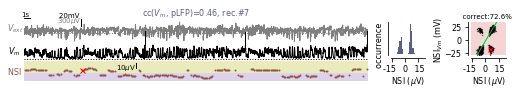

In [707]:
GRAPHS_PROPS = [{'icell':ccpLFP_ordered[13],'tstart':85,'error_index':78, 'bar_loc':(15,25), 'Vm_scale':30, 'bar_loc2':(18,-5), 'Vext_scale':0.7},
                {'icell':ccpLFP_ordered[12],'error_index':0, 'bar_loc':(59, 10), 'Vext_loc':-10, 'bar_loc2':(26.5,-5)},
                # {'icell':ccpLFP_ordered[11],'error_index':0, 'bar_loc':(8.5, 2), 'Vext_loc':-10, 'bar_loc2':(30.5,20)},
                {'icell':ccpLFP_ordered[10],'tstart':0,'error_index':15, 'bar_loc':(10,-30), 'Vext_loc':-40, 'bar_loc2':(30.5,21),'Vext_scale':0.3},
                {'icell':ccpLFP_ordered[9],'tstart':4.4,'error_index':23, 'bar_loc':(55.5,-52), 'Vext_loc':-10, 'bar_loc2':(48,-3)},
                # {'icell':ccpLFP_ordered[8],'tstart':190,'error_index':174, 'bar_loc':(16.5,-66), 'Vext_loc':-40, 'bar_loc2':(28,-3), 'Vm_scale':10},
                # {'icell':ccpLFP_ordered[7],'tstart':0,'error_index':0, 'bar_loc':(16.5,-66), 'Vext_scale':0.4, 'bar_loc2':(28,-3), 'Vm_scale':20},
                # {'icell':ccpLFP_ordered[6],'tstart':0,'error_index':0, 'bar_loc':(16.5,-66), 'Vext_scale':0.4, 'bar_loc2':(28,-3), 'Vm_scale':20},
                # {'icell':ccpLFP_ordered[5],'error_index':5, 'bar_loc':(10,10),'Vext_loc':-10,'Vext_scale':0.3,'bar_loc2':(19.5,20), 'Vm_scale':20},
                {'icell':ccpLFP_ordered[4],'error_index':5, 'bar_loc':(10,10),'Vext_loc':-10,'Vext_scale':0.3,'bar_loc2':(19.5,20), 'Vm_scale':20},
                # {'icell':ccpLFP_ordered[3],'tstart':0,'bar_loc':(10,10),'Vext_loc':-10,'Vext_scale':0.3,'bar_loc2':(19.5,20), 'Vm_scale':20},
                {'icell':ccpLFP_ordered[2],'error_index':0, 'bar_loc':(7,-10),'Vext_loc':-25,'Vext_scale':0.4,'bar_loc2':(19.5,20), 'Vm_scale':15},
                # {'icell':ccpLFP_ordered[1],'tstart':0,'bar_loc':(10,10),'Vext_loc':-10,'Vext_scale':0.3,'bar_loc2':(19.5,20), 'Vm_scale':20},
                {'icell':ccpLFP_ordered[0],'tstart':0,'error_index':0, 'bar_loc':(10,-40),'Vext_loc':-0,'Vext_scale':0.4,'bar_loc2':(19.5,-3)}]
fig, ax, axCV = show_raw_data_Vm_Vext_NSI(DATA, **GRAPHS_PROPS[4]);

[174 175 176 177 178 179 180]


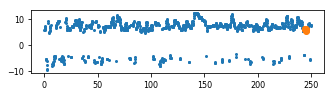

In [701]:
#####################################                      
## TO KEEP: this is how you find specific mismatches
#####################################                      
i0 = ccpLFP_ordered[8]
data = DATA[i0]    
cond0, _, _ = get_accepted_samples(data)
cond = data['NSI_validated'] & (data['NSI']>0) & (data['Vm_NSI']>0)
new_t = data['sbsmpl_t'][data['NSI_validated']][np.invert(cond0)]                      
new_nsi = data['NSI'][data['NSI_validated']][np.invert(cond0)]                      
new_vmnsi = data['Vm_NSI'][data['NSI_validated']][np.invert(cond0)]
fig, ax = figure(axes_extents=[[[3,1]]])                      
ax.plot(data['sbsmpl_t'][data['NSI_validated']], data['NSI'][data['NSI_validated']], 'o', ms=2)
ax.plot(new_t[(new_nsi>0) & (new_vmnsi>0)], new_nsi[(new_nsi>0) & (new_vmnsi>0)], 'o')
print(np.argwhere((new_nsi>0) & (new_vmnsi>0)).flatten())                     

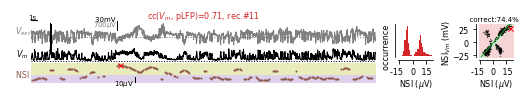

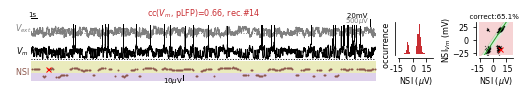

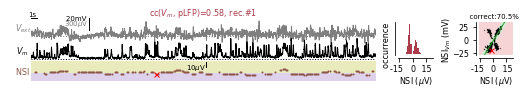

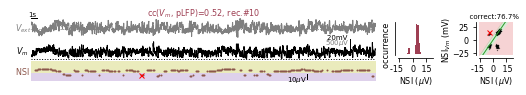

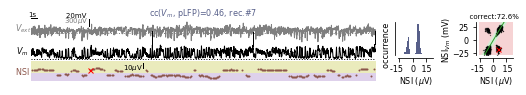

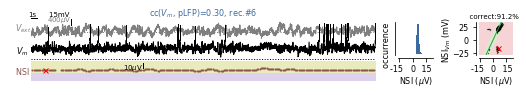

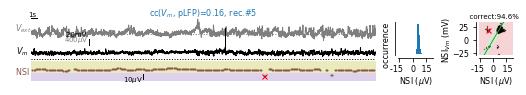

In [710]:
FIGS = []
for i, g in enumerate(GRAPHS_PROPS):
    fig, ax, axCV = show_raw_data_Vm_Vext_NSI(DATA, **g)
    if len(FIGS)==0:
        annotate('a', fig, -0.02, 1.05, fontweight='bold', fontsize=FONTSIZE+1)
        annotate('b', fig, .73, 1.05, fontweight='bold', fontsize=FONTSIZE+1)
        annotate('c', fig, .86, 1.05, fontweight='bold', fontsize=FONTSIZE+1)
    annotate('(%s)' % int_to_roman(i+1), fig, -.05, .97, fontsize=FONTSIZE)
    FIGS.append(fig)

In [711]:
from graphs.plot_export import put_list_of_figs_to_svg_fig, export_as_png
put_list_of_figs_to_svg_fig(FIGS,
                            fig_name='Figures/Fig_All_cells.svg',
                            figsize=(0.8,0.1*len(FIGS)),
                            Props={'XCOORD':[0 for i in range(len(FIGS))],
                                   'YCOORD':[80*i for i in range(len(FIGS))]},
                            visualize=False)
export_as_png(os.getcwd()+'/Figures/Fig_All_cells.svg', dpi=200)

# Link between pLFP-defined fluctuations and Vm-fluctuations

In [251]:
%run cortical_arousal_index/exp_data.py
from cortical_arousal_index.plots import *

In [5]:
cell_colormap = get_linear_colormap(Blue, Orange)
NEpisode_MIN = 5
NSI_max = 30
NSI_bin = 1
update_study_output('NEpisode_MIN_for_granularity_analysis', NEpisode_MIN)
update_study_output('NSI_Max_for_granularity_analysis', NSI_max)
update_study_output('NSI_bin_for_granularity_analysis', NSI_bin)

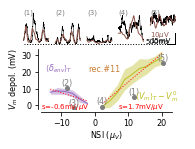

In [37]:
fig_single_cell1, ax = analyze_single_cell_granularity(cell=10,
                                                       NEpisode_MIN=NEpisode_MIN,
                                                       Zooms = Zooms,
                                                       NSI_episodes = NSI_episodes,
                                                       Depol_episodes=Depol_episodes,
                                                       Annot_episodes=Annot_episodes,
                                                       ylim=[-2,34],
                                                       xlim=[-16,23],
                                                       figure_options={'left':0.35, 'bottom':0.3, 'top':.8, 'figsize':(1.,1.)},
                                                       NSI_levels = np.linspace(1e-3, 20, 10))

In [36]:
data = DATA[5]
# NSI_episodes2, Depol_episodes2, Annot_episodes2  = [], [], ['       (4)', '(1)    ', '    (2)', '(3)   ', '(5)    ']
NSI_episodes, Depol_episodes, Annot_episodes  = [], [], ['(1)', '(2)', '(3)', '(4)', '(5)']
cond = (data['pLFP']<data['p0'])
Vm0 = np.mean(data['sbsmpl_Vm'][cond])
Zooms=[x+np.arange(2)*1.5 for x in [84.99, 20.3, 45.5, 120.1, 146.6]]
                                    
for z in [Zooms[3], Zooms[0]]:                                    
   ii = np.argmin(np.abs(data['sbsmpl_t']-z.mean()))
   Depol_episodes.append(data['sbsmpl_Vm_max_low_freqs_power'][ii]) # enveloppe of [2,5]Hz
   NSI_episodes.append(data['NSI'][ii])
for z in [Zooms[1], Zooms[2], Zooms[4]]:
   ii = np.argmin(np.abs(data['sbsmpl_t']-z.mean()))
   Depol_episodes.append(np.mean(data['sbsmpl_Vm'][ii-int(args.Tstate/data['sbsmpl_dt']/2):ii+int(args.Tstate/data['sbsmpl_dt']/2)])-Vm0)
   NSI_episodes.append(data['NSI'][ii])                                    

In [22]:
data2 = DATA[1]
Zooms2=[x+np.arange(2)*2 for x in [279.2, 116.5, 10, 155, 231.7]]
NSI_episodes2, Depol_episodes2, Annot_episodes2  = [], [], ['       (4)', '(1)    ', '    (2)', '(3)   ', '(5)    ']
cond2 = (data2['pLFP']<data2['p0'])
Vm0 = np.mean(data2['sbsmpl_Vm'][cond2])
for z in [Zooms2[3], Zooms2[0]]:                                    
   ii = np.argmin(np.abs(data2['sbsmpl_t']-z.mean()))
   Depol_episodes2.append(data2['sbsmpl_Vm_max_low_freqs_power'][ii]) # enveloppe of [2,5]Hz
   NSI_episodes2.append(data2['NSI'][ii])
for z in [Zooms2[1], Zooms2[2], Zooms2[4]]:                                    
   ii = np.argmin(np.abs(data2['sbsmpl_t']-z.mean()))
   Depol_episodes2.append(np.mean(data2['sbsmpl_Vm'][ii-int(args.Tstate/data2['sbsmpl_dt']/2):ii+int(args.Tstate/data2['sbsmpl_dt']/2)])-Vm0)
   NSI_episodes2.append(data2['NSI'][ii])                                    

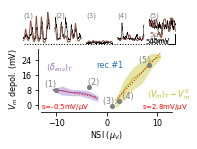

In [23]:
fig_single_cell2, ax = analyze_single_cell_granularity(cell=8,
                                                       NEpisode_MIN=NEpisode_MIN,
                                                       Zooms = Zooms2, NSI_episodes = NSI_episodes2, Depol_episodes=Depol_episodes2,
                                                       Annot_episodes=Annot_episodes2,
                                                       ylim=[-2,30],
                                                       xlim=[-13,13],
                                                       xticks=[-10,0,10],
                                                       pLFP_bar=5,
                                                       loc_Pow_annot=(-12,19),
                                                       loc_mean_annot=(8,4),
                                                       NSI_levels = np.linspace(1e-3, 16, 10),
                                                       figure_options={'left':0.35, 'bottom':0.3, 'top':.8, 'figsize':(1,1)})
#ax.set_xlim([-13,16])

In [18]:
from scipy.stats import ttest_rel, ttest_ind, pearsonr

def analyze_single_cell_granularity(filename='cortical_arousal_index/data/final_depol.npz',
                                    cell=0, 
                                    Zooms = [], NSI_episodes =[], Depol_episodes=[], Annot_episodes=[],
                                    cell_name = 'Cell 1',
                                    NEpisode_MIN=2,
                                    NSI_levels = np.linspace(1e-3, 18, 13),
                                    with_fig=True,
                                    xlim=[-10,20], ylim=[0,30.5], xticks=[-10, 0, 10, 20],
                                    figure_options={'left':0.3, 'bottom':0.3, 'figsize':(0.2,0.1)},
                                    Vm_bar = 15, pLFP_bar = 10,
                                    loc_Pow_annot=(-15,21),
                                    loc_mean_annot = (12,4),
                                    loc_stat_S=(-.1,.99), loc_annot_S=(-.01,.1),
                                    loc_annot_A=(0.7,.1),loc_stat_A=(0.6, 0.99),
                                    lw=1):
    
    OUTPUT = dict(np.load(filename))
    icell = np.argwhere(np.array(['../'+str(DATA[i]['filename']) for i in range(len(DATA))])==OUTPUT['FILENAMES'][cell])[0][0]
    data = DATA[icell]
                                                               
    if with_fig:
        fig_granularity, ax = figure(figsize=(1.5,1.4), top=8)

    Ncount, Depol, sDepol = [np.zeros(len(NSI_levels)) for k in range(3)]
    NSI, mean, std, CCs, Slopes = [], [], [], [], []
    FULL_INPUT, FULL_OUTPUT = np.empty(0), np.empty(0)

    V0 = OUTPUT['VM_ASYNCH_LEVELS'][cell][-1]
    cond = np.isfinite(OUTPUT['VM_ASYNCH_LEVELS'][cell][:-1])
    
    binned = np.digitize(OUTPUT['NSI_ASYNCH_LEVELS'][cell], bins=NSI_levels[:-1])
    for j in np.unique(binned):
        cond = (binned==j) & np.isfinite(OUTPUT['VM_ASYNCH_LEVELS'][cell])
        if len(OUTPUT['VM_ASYNCH_LEVELS'][cell][cond])>1:
            Ncount[j] = len(OUTPUT['VM_ASYNCH_LEVELS'][cell][cond])
            Depol[j] = np.mean(OUTPUT['VM_ASYNCH_LEVELS'][cell][cond]-V0)
            sDepol[j] = np.std(OUTPUT['VM_ASYNCH_LEVELS'][cell][cond]-V0)
    cond = (Ncount>NEpisode_MIN)
    NSI_asynch, Depol_asynch = NSI_levels[cond], Depol[cond]
    
    if with_fig:
        # extending NSI axis (we add the bin length), to account for the binning:
        # NSI_levels_plot = np.linspace(NSI_levels[0], NSI_levels[-1]+NSI_levels[1]-NSI_levels[0], len(NSI_levels)) 
        NSI_levels_plot = np.linspace(NSI_levels[0], NSI_levels[-1], len(NSI_levels)) 
        ax.plot(NSI_levels_plot[cond], Depol[cond], '-', lw=lw, color=Kaki)
        ax.fill_between(NSI_levels_plot[cond],
                    Depol[cond]+sDepol[cond], Depol[cond]-sDepol[cond],
                    color=Kaki, alpha=.4, lw=0)
        pol = np.polyfit(NSI_levels[cond], Depol[cond], 1)
        x = np.linspace(np.min(NSI_levels_plot[cond]), np.max(NSI_levels_plot[cond]), 3)
        ax.plot(x, np.polyval(pol, x), ':', lw=1, color='r')
        ax.annotate('s='+str(round(pol[0],1))+'mV/$\mu$V', (7, ylim[0]), color='r', fontsize=FONTSIZE-1)
    
    NSI_levels = -NSI_levels
    Ncount, Depol, sDepol = [np.zeros(len(NSI_levels)) for k in range(3)]
    
    for i in range(len(OUTPUT['FILENAMES'])):
        V0 = 0#OUTPUT['VM_ASYNCH_LEVELS'][cell][-1] # here this is the power + Vm0, so no need to add
    binned = np.digitize(OUTPUT['NSI_SYNCH_LEVELS'][cell], bins=NSI_levels[:-1])
    for j in np.unique(binned):
        cond = (binned==j) & np.isfinite(OUTPUT['VM_SYNCH_LEVELS'][cell])
        Ncount[j] = len(OUTPUT['VM_SYNCH_LEVELS'][cell][cond])
        val = OUTPUT['VM_SYNCH_LEVELS'][cell][cond]
        Depol[j] = np.mean(val[np.isfinite(val)])
        sDepol[j] = np.std(val[np.isfinite(val)])
    cond = (Ncount>NEpisode_MIN)
    NSI_synch, Depol_synch = NSI_levels[cond], Depol[cond]
    
    if with_fig:
        # NSI_levels_plot = np.linspace(NSI_levels[0], NSI_levels[-1]+NSI_levels[1]-NSI_levels[0], len(NSI_levels)) # extending NSI axis, to account for binning intervals
        NSI_levels_plot = np.linspace(NSI_levels[0], NSI_levels[-1], len(NSI_levels)) # extending NSI axis, to account for binning intervals
        ax.plot(NSI_levels_plot[cond], Depol[cond], '-', lw=lw, color=Purple)
        ax.fill_between(NSI_levels_plot[cond],
                    Depol[cond]+sDepol[cond], Depol[cond]-sDepol[cond],
                    color=Purple, alpha=.4, lw=0)
        pol = np.polyfit(NSI_levels[cond], Depol[cond], 1)
        x = np.linspace(np.min(NSI_levels_plot[cond]), np.max(NSI_levels_plot[cond]), 3)
        ax.plot(x, np.polyval(pol, x), ':', lw=1, color='r')
        ax.annotate('s='+str(round(pol[0],1))+'mV/$\mu$V', (xlim[0], ylim[0]), color='r', fontsize=FONTSIZE-1)
        ax.plot(xlim, ylim, 'w.')
        set_plot(ax, ylabel='$V_m$ depol. (mV)',
                 xlabel='NSI ($\mu_V$)', ylim=ylim, xticks=xticks, xlim=xlim)

        for ii, nsi, d in zip(Annot_episodes, NSI_episodes, Depol_episodes):
            ax.plot([nsi], [d], 'o', color=Grey, ms=4)
            ax.annotate(ii, (nsi, d+1.5), color=Grey, fontsize=FONTSIZE, ha='center')
        ax.annotate('rec.#%i'%(DATA[icell]['ccVext_rank']+1),
                    (-2,20), fontsize=FONTSIZE, color=cell_colormap(DATA[icell]['ccVext_rank']/(len(DATA)-1)))
        ax.annotate(r'$\langle \delta_{env} \rangle_T$', loc_Pow_annot, fontsize=FONTSIZE, color=Purple)
        ax.annotate(r'$\langle V_m \rangle_T - V_m^0$', loc_mean_annot, fontsize=FONTSIZE, color=Kaki)
        ax2 = plt.axes([0.07, 0.7, 0.95,0.25])
        tt, Tspace = 0, .4
        for i, (z1, z2) in enumerate(Zooms):
            ax2.annotate('('+str(i+1)+')', (tt, 40), color=Grey, fontsize=FONTSIZE-1)
            cond = (data['sbsmpl_t']>z1) & (data['sbsmpl_t']<z2)
            ax2.plot(data['sbsmpl_t'][cond]-z1+tt, data['sbsmpl_Vm'][cond]-data['p0_Vm'], 'k-', lw=0.5)
            ax2.plot(data['sbsmpl_t'][cond]-z1+tt, (data['pLFP'][cond]-data['p0'])/pLFP_bar*Vm_bar,
                     '-', lw=1, color=Brown)
            tt+=z2-z1+Tspace
        ax2.plot([0,tt-Tspace], np.zeros(2), 'k:', lw=1)
        ax2.plot((tt-Tspace)*np.ones(2), Vm_bar*np.arange(2), 'k-', lw=1)
        ax2.plot([tt-Tspace-0.5, tt-Tspace], np.zeros(2), 'k-', lw=1)
        ax2.annotate('500ms', (tt-Tspace-z2+z1-.3, 0), color='k', fontsize=FONTSIZE-1)
        ax2.annotate(str(Vm_bar)+'mV', (tt-Tspace-z2+z1, 2), color='k', fontsize=FONTSIZE-1)
        ax2.annotate(str(pLFP_bar)+'$\mu$V', (tt-Tspace-z2+z1, 10), color=Brown, fontsize=FONTSIZE-1)
        set_plot(ax2, [])        
        return fig_granularity, ax
    else:
        return NSI_asynch, Depol_asynch, NSI_synch, Depol_synch


-0.24347332572927413 0.314272187919946 0.1437592053652242 6 1.5225518263683047 0.7379058236990109 1.1680682902483172e-05 13


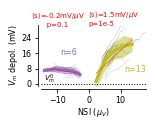

In [40]:
NEpisode_MIN = 5
NSI_max = 30.
NSI_bin = 1                                                               
update_study_output('NEpisode_MIN_for_granularity_analysis', NEpisode_MIN)
update_study_output('NSI_Max_for_granularity_analysis', NSI_max)
update_study_output('NSI_bin_for_granularity_analysis', NSI_bin)
fig_granularity, [cS, scS, pS, nS, cA, scA, pA, nA] = analyze_granularity(figure_options={'left':0.2, 'bottom':0.2, 'top':.95, 'figsize':(.2,0.07)},
                                                                          NSI_levels = np.arange(int(NSI_max/NSI_bin))*NSI_bin,
                                                                          NEpisode_MIN=NEpisode_MIN,
                                                                          Nlevel_MIN=5,
                                                                          NSI_levels_plot = np.linspace(0, 16, 6),
                                                                          xlim=[-15,18],
                                                                          loc_stat_S=(-.1,.99), loc_stat_A=(.45,1.01))
print(cS, scS, pS, nS, cA, scA, pA, nA)                                                               
update_study_output('value_of_slopes_for_rhythmic_granularity_analysis',str(round(cS,1))+'$\pm$'+str(round(scS,1)))
update_study_output('value_of_slopes_for_nonrhythmic_granularity_analysis',str(round(cA,1))+'$\pm$'+str(round(scA,1)))
update_study_output('pvalue_slopes_for_rhythmic_granularity_analysis',str(round(pS,2)))
update_study_output('pvalue_slopes_for_nonrhythmic_granularity_analysis', sci_str(pA,1))
update_study_output('n_slopes_for_rhythmic_granularity_analysis',str(nS))
update_study_output('n_slopes_for_nonrhythmic_granularity_analysis', str(nA))                                                               

In [39]:
from scipy.stats import ttest_rel, ttest_ind, pearsonr

def analyze_granularity(filename='cortical_arousal_index/data/final_depol.npz',
                        NEpisode_MIN=2,
                        Nlevel_MIN = 3,
                        xlim=[-13,20], ylim=[-1,30.5],
                        NSI_levels = np.linspace(1e-3, 20, 25),
                        NSI_levels_plot = np.linspace(1e-3, 18, 7),
                        xticks=[-10,0,10],
                        n_loc=None,
                        with_single_cell_traces=True,
                        with_fig=True, cell_by_cell_correl=False, cell_by_cell_slope=True,
                        figure_options={'left':0.3, 'bottom':0.3, 'figsize':(0.2,0.1)},
                        loc_stat_S=(-.1,.99),
                        loc_stat_A=(0.6, 0.99),
                        lw=0.1):
    
    OUTPUT = dict(np.load(filename))

    if with_fig:
        # fig_granularity, ax = figure(**figure_options)
        fig_granularity, ax = figure(figsize=(1.3,1.))
        cstring = 'c='

    NSI, mean, std, CCs_A, CCs_S, Slopes_A, Slopes_S = [], [], [], [], [], [], []
    # Ncount, Depol = [np.zeros((len(NSI_levels), len(OUTPUT['FILENAMES']))) for k in range(2)]
    FULL_INPUT_A, FULL_OUTPUT_A = np.empty(0), np.empty(0)
    FULL_INPUT_S, FULL_OUTPUT_S = np.empty(0), np.empty(0)
    
    for i in range(len(OUTPUT['FILENAMES'])):
        
        NSI_asynch, Depol_asynch,\
            NSI_synch, Depol_synch =\
            analyze_single_cell_granularity(filename=filename,
                                            cell=i,
                                            NEpisode_MIN=NEpisode_MIN,
                                            NSI_levels = NSI_levels,
                                            with_fig=False)
        
        FULL_INPUT_A = np.concatenate([FULL_INPUT_A, np.array(NSI_asynch)])
        FULL_OUTPUT_A = np.concatenate([FULL_OUTPUT_A, np.array(Depol_asynch)])
        FULL_INPUT_S = np.concatenate([FULL_INPUT_S, np.array(NSI_synch)])
        FULL_OUTPUT_S = np.concatenate([FULL_OUTPUT_S, np.array(Depol_synch)])

        if (len(NSI_asynch)>Nlevel_MIN):
            CCs_A.append(pearsonr(NSI_asynch, Depol_asynch)[0])
            Slopes_A.append(np.polyfit(NSI_asynch, Depol_asynch,1)[0])
        if (len(NSI_synch)>Nlevel_MIN):
            CCs_S.append(pearsonr(NSI_synch, Depol_synch)[0])
            Slopes_S.append(np.polyfit(NSI_synch, Depol_synch,1)[0])
            
        if with_fig:
            ax.plot(NSI_asynch, Depol_asynch, 'k-', lw=lw)
            ax.plot(NSI_synch, Depol_synch, 'k-', lw=lw)
            
    cA, scA, pA, nA = np.mean(Slopes_A), np.std(Slopes_A), ttest_rel(Slopes_A, np.ones(len(Slopes_A))*0)[1], len(Slopes_A)
    cS, scS, pS, nS = np.mean(Slopes_S), np.std(Slopes_S), ttest_rel(Slopes_S, np.ones(len(Slopes_S))*0)[1], len(Slopes_S)

    
    if with_fig and pA<1:
        cstring = r'$\langle$s$\rangle$='+str(round(cA,1))+'mV/$\mu$V\n'
        ax.annotate(cstring+'p='+sci_str(pA), loc_stat_A, fontsize=FONTSIZE-1, color='r', xycoords='axes fraction')
    if with_fig and pS<1:
        cstring = r'$\langle$s$\rangle$='+str(round(cS,1))+'mV/$\mu$V\n'
        # ax.annotate(cstring+'       p='+sci_str(pS), loc_stat_S, fontsize=FONTSIZE-1, color='r', xycoords='axes fraction')
        ax.annotate(cstring+'       p='+str(round(pS,1)), loc_stat_S, fontsize=FONTSIZE-1, color='r', xycoords='axes fraction')

    nsiA, condA, meanA, stdA = [], [], [], []
    nsiS, condS, meanS, stdS = [], [], [], []
    for n1, n2 in zip(NSI_levels_plot[:-1], NSI_levels_plot[1:]):
        condS = (FULL_INPUT_S<=-n1) & (FULL_INPUT_S>-n2)
        condA = (FULL_INPUT_A>=n1) & (FULL_INPUT_A<n2)
        if len(FULL_INPUT_S[condS])>1:
            nsiS.append(np.mean(FULL_INPUT_S[condS]))
            meanS.append(np.mean(FULL_OUTPUT_S[condS]))
            stdS.append(np.std(FULL_OUTPUT_S[condS]))
        if len(FULL_INPUT_A[condA])>1:
            nsiA.append(np.mean(FULL_INPUT_A[condA]))
            meanA.append(np.mean(FULL_OUTPUT_A[condA]))
            stdA.append(np.std(FULL_OUTPUT_A[condA]))
            
    if with_fig:
        ax.plot(nsiA, meanA, lw=3, color=Kaki)
        # ax.plot(nsiA, np.polyval(np.polyfit(nsiA, meanA, 1), nsiA), 'r--', lw=0.5)
        ax.plot(nsiA, cA*(np.array(nsiA)-np.mean(nsiA))+np.mean(meanA), 'r--', lw=0.5)
        ax.fill_between(nsiA, np.array(meanA)+np.array(stdA), np.array(meanA)-np.array(stdA),
                              color=Kaki, alpha=.5, lw=0)
        ax.plot(nsiS, meanS, lw=3, color=Purple)
        ax.plot(nsiS, cS*(np.array(nsiS)-np.mean(nsiS))+np.mean(meanS), 'r--', lw=0.5)
        ax.fill_between(nsiS, np.array(meanS)+np.array(stdS), np.array(meanS)-np.array(stdS),
                        color=Purple, alpha=.5, lw=0)
        ax.annotate('n='+str(nS), (-9,15), fontsize=FONTSIZE, color=Purple)
        ax.annotate('n='+str(nA), (11,6), fontsize=FONTSIZE, color=Kaki)
        ax.plot(xlim, [0,0], 'k:', lw=1)              
        ax.annotate('$V_m^0$', (xlim[0]+1,1), fontsize=FONTSIZE-1)
        set_plot(ax, ylabel='$V_m$ depol. (mV)',
             xlabel='NSI ($\mu_V$)', ylim=ylim, xticks=xticks, xlim=xlim)
        return fig_granularity, [cS, scS, pS, nS, cA, scA, pA, nA]
    else:
        return cS, pS, cA, pA


In [41]:
# the impact of alpha on the granularity of the classification
ALPHA = np.round(np.linspace(1,5,10),2)
Script = ''
for s, c in zip(np.array(100.*ALPHA, dtype=int), ALPHA):
    Script+='python exp_data.py -gpl -f data/final_depol_alpha'+str(s)+'.npz --parallelize --alpha '+str(c)+'\n'
    # print('sget data/final_depol_alpha'+str(s)+'.npz')
f = open('cortical_arousal_index/bash_scripts/granularity_and_alpha.sh', 'w')
f.write(Script)
f.close()                          

In [42]:
# the impact of alpha on the granularity of the classification
FNS = []
for s, c in zip(np.array(100.*ALPHA, dtype=int), ALPHA):
    FNS.append('cortical_arousal_index/data/final_depol_alpha'+str(s)+'.npz')
    # print('sget cortical_arousal_index/data/final_depol_alpha'+str(s)+'.npz')

/Users/yzerlaut/anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/yzerlaut/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/yzerlaut/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/yzerlaut/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/yzerlaut/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


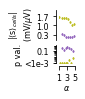

In [43]:
fig_alpha_dep, AX1 = figure(axes_extents=[[[1,3]], [[1,2]]], hspace=.4, figsize=(.5,.2))
for alpha, fn in zip(ALPHA[1:-1], FNS[1:-1]):
    cS, pS, cA, pA = analyze_granularity(filename=fn,
                                         NSI_levels = np.arange(int(NSI_max/NSI_bin))*NSI_bin,
                                         NEpisode_MIN=5,
                                         Nlevel_MIN=5,
                                         with_fig=False)

    if pS<1: # finite p-value
        AX1[0].plot([alpha], [-cS], 'd', color=Purple, ms=1.5)
        AX1[1].plot([alpha], [max([1e-3,pS])], 'd', color=Purple, ms=1.5)
    if pA<1:
        AX1[0].plot([alpha], [cA], 'd', color=Kaki, ms=1.5)
        AX1[1].plot([alpha], [max([1e-3,pA])], 'd', color=Kaki, ms=1.5)
set_plot(AX1[1], ylabel='p val.', yscale='log',
         yticks=[1e-3, 1e-1], yticks_labels=['<1e-3', '0.1'], ylim=[9e-4,1.5],
         xlabel='$\\alpha$', xticks=[1,3,5])
set_plot(AX1[0], ['left'], ylabel=r'$\| \langle$s$\rangle_{cells} \| $'+'\n (mV/$\mu$V)', yticks=[.3, 1., 1.7], ylim=[-0.1,2.2])    

In [44]:
from graphs.plot_export import put_list_of_figs_to_svg_fig, export_as_png
put_list_of_figs_to_svg_fig([fig_single_cell1, fig_single_cell2, fig_granularity, fig_alpha_dep],
                            fig_name='Figures/Fig_Granularity.svg',
                            figsize=(0.65,1.),
                            Props={'XCOORD':[35, 35, 40, 200],
                                   'YCOORD':[0, 125, 270, 260],
                                   'XCOORD_LABELS':[0, 0, 0, 165, 165],
                                   'YCOORD_LABELS':[0, 120, 245, 245, 250],
                                   'LABELS':['a','b', 'c', 'd', 'e']}, visualize=False)

In [45]:
export_as_png(os.getcwd()+'/Figures/Fig_Granularity.svg', dpi=200)

In [431]:
from IPython.display import Image
#Image(filename='paper/Figures/Fig_Granularity.png', width=300)

/Users/yzerlaut/anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/yzerlaut/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/yzerlaut/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/yzerlaut/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/yzerlaut/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0


13


14


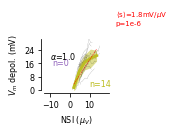

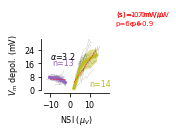

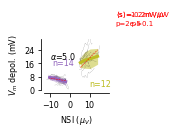

In [278]:
FIGS = []
# for i in range(len(ALPHA))[1:-1]:
for i in [0,5,-1]:
    a, fn = ALPHA[i], FNS[i]
    fig0, FF = analyze_granularity(filename=fn,
                                           NSI_levels = np.linspace(1e-3, 15, 30),
                                           NEpisode_MIN=5,
                                           loc_stat_S=(1.1,1.3),
                                           loc_stat_A=(1.1,1.3),
                                   figure_options={'left':0.2, 'bottom':0.2, 'top':.95, 'figsize':(.12,0.07)})
    plt.gca().annotate('$\\alpha$='+str(round(a, 1)), (.08,.6), xycoords='axes fraction', fontsize=FONTSIZE)
    FIGS.append(fig0)

In [280]:
from graphs.plot_export import put_list_of_figs_to_svg_fig, export_as_png
put_list_of_figs_to_svg_fig(FIGS,
                            fig_name='paper/Figures/Fig_Supp_Granularity.svg',
                            figsize=(0.6,0.35),
                            Props={'XCOORD':list(40+np.arange(4)*120),
                                   'YCOORD':list(np.ones(4)*20),
                                   'XCOORD_LABELS':list(6+np.arange(4)*120),
                                   'YCOORD_LABELS':[0, 0, 0, 0],
                                   'LABELS':['a', 'b', 'c', 'd']}, visualize=False)
export_as_png(os.getcwd()+'/paper/Figures/Fig_Supp_Granularity.svg', dpi=200)

# Analysis of source of cell-to-network correlations: role of fluctuations in network states

In [182]:
####################################################                               
# Correlation analysis: analyzing and saving output
####################################################
                                
mean_nsi, std_nsi, std_pos_nsi, fraction_lf, ccpLFP, ccVext = [], [], [], [], [], []
mean_nsi_lf, std_nsi_lf, mean_pos_nsi = [], [], []
# now loop over cells
for i, data in enumerate(DATA):
    x = data['NSI'][data['NSI_validated']]
    mean_nsi.append(np.mean(x))
    std_nsi.append(np.std(x))
    mean_pos_nsi.append(np.mean(x[x>0]))
    std_pos_nsi.append(np.std(x[x>0]))
    fraction_lf.append(np.sum((data['NSI_validated']) & (data['NSI']<0))/len(x))
    mean_nsi_lf.append(np.mean(x[x<0]))
    std_nsi_lf.append(np.std(x[x<0]))
    ccpLFP.append(data['cc-Vm-pLFP'])
    ccVext.append(np.abs(data['cc-Vm-LFP']))
np.save('cortical_arousal_index/data/final_correl.npy',
        [mean_nsi, std_nsi, std_pos_nsi, fraction_lf, ccpLFP, ccVext,
         mean_nsi_lf, std_nsi_lf, mean_pos_nsi])

In [2]:
######## output data
mean_nsi, std_nsi, std_pos_nsi, fraction_lf, ccpLFP, ccVext,\
    mean_nsi_lf, std_nsi_lf, mean_pos_nsi = np.load('cortical_arousal_index/data/final_correl.npy')

Text(43.4923,50,'std_pos_nsi,std_pos_nsi,std_pos_nsi')

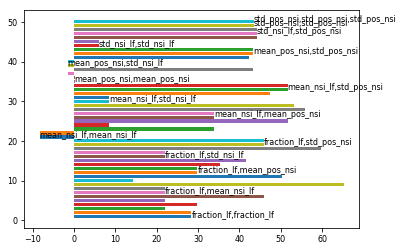

In [31]:
import statsmodels.formula.api as smf
import pandas
keys = ['fraction_lf', 'mean_nsi', 'mean_nsi_lf', 'mean_pos_nsi',
       'std_nsi', 'std_nsi_lf', 'std_pos_nsi']                                
keys = ['fraction_lf', 'mean_nsi_lf', 'mean_pos_nsi',
       'std_nsi_lf', 'std_pos_nsi']                                
data = pandas.DataFrame({'mean_nsi':mean_nsi, 'std_nsi':std_nsi, 'std_pos_nsi':np.log(std_pos_nsi),
                         'fraction_lf':fraction_lf, 'mean_nsi_lf':mean_nsi_lf, 'std_nsi_lf':std_nsi_lf, 'mean_pos_nsi':mean_pos_nsi,
                         'cc': ccpLFP})
ii=0
import itertools                                
for i in range(len(keys)):
    for j in range(i, len(keys)):
        model1 = smf.ols("cc ~ "+keys[i]+" + "+keys[j], data).fit()
        ii+=1
        val = 100*model1.rsquared_adj                        
        plt.barh([ii], [val])
        plt.annotate(keys[i]+','+keys[j], [val, ii], fontsize=8)
        for k in range(j, len(keys)):
            model1 = smf.ols("cc ~ "+keys[i]+" + "+keys[j]+" + "+keys[k], data).fit()
            ii+=1
            val = 100*model1.rsquared_adj                        
            plt.barh([ii], [val])
plt.annotate(keys[i]+','+keys[j]+','+keys[k], [val, ii], fontsize=8)

## Full linear model (all components)                                

In [42]:
data = pandas.DataFrame({'mean_nsi':mean_nsi, 'std_nsi':std_nsi, 'std_pos_nsi':std_pos_nsi,
                         'fraction_lf':fraction_lf, 'mean_nsi_lf':mean_nsi_lf, 'std_nsi_lf':std_nsi_lf, 'mean_pos_nsi':mean_pos_nsi,
                         'cc': ccpLFP})
model = smf.ols("cc ~ std_nsi + mean_nsi + std_pos_nsi + fraction_lf + mean_nsi_lf + std_nsi_lf + mean_pos_nsi", data).fit()
print(model.summary())
update_study_output('rsquared_full_regression_model', round(100.*model.rsquared_adj,2))
# update_study_output('pvalue_full_regression_model', str(eval("%.1e" % (model.f_pvalue))))                                
update_study_output('pvalue_full_regression_model', sci_str(model.f_pvalue,1))                                

/Users/yzerlaut/anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


                            OLS Regression Results                            
Dep. Variable:                     cc   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     5.167
Date:                Sun, 30 Dec 2018   Prob (F-statistic):             0.0314
Time:                        21:56:45   Log-Likelihood:                 19.440
No. Observations:                  14   AIC:                            -22.88
Df Residuals:                       6   BIC:                            -17.77
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.6147      0.496      1.239   

## Three components model

In [43]:
data = pandas.DataFrame({'mean_nsi':mean_nsi, 'std_nsi':std_nsi, 'std_pos_nsi':np.log(std_pos_nsi),
                         'fraction_lf':fraction_lf, 'mean_nsi_lf':mean_nsi_lf, 'std_nsi_lf':std_nsi_lf, 'mean_pos_nsi':mean_pos_nsi,
                         'cc': ccpLFP})
model3 = smf.ols("cc ~ fraction_lf + std_pos_nsi + std_nsi_lf", data).fit()
print(model3.summary())
update_study_output('rsquared_3_factor_model', round(100.*model3.rsquared_adj,2))
# update_study_output('pvalue_3_factor_model', str(eval("%.1e" % (model3.f_pvalue))))
update_study_output('pvalue_3_factor_model', sci_str(model3.f_pvalue,1))

/Users/yzerlaut/anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


                            OLS Regression Results                            
Dep. Variable:                     cc   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     7.456
Date:                Sun, 30 Dec 2018   Prob (F-statistic):            0.00656
Time:                        21:56:55   Log-Likelihood:                 14.013
No. Observations:                  14   AIC:                            -20.03
Df Residuals:                      10   BIC:                            -17.47
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.5894      0.136      4.322      

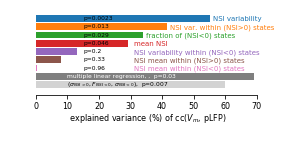

In [49]:
fig_bars, ax = figure(figsize=(2.,1.2), right=.99, left=0.1)
COLORS = [Blue, Orange, Green, Red, Purple, Brown, Pink]
LABELS=['NSI variability', 'NSI var. within (NSI>0) states',
        'fraction of (NSI<0) states', 'mean NSI',
        'NSI variability within (NSI<0) states', 'NSI mean within (NSI>0) states',
        'NSI mean within (NSI<0) states']
LABELS2=['$\sigma_{NSI}$', '$\sigma_{NSI>0}$', '$F_{NSI<0}$', '$\mu_{NSI}$', '$\sigma_{NSI<0}$', '$\mu_{NSI>0}$', '$\mu_{NSI<0}$']
for i, x in zip(np.arange(len(std_nsi)),
                [std_nsi, std_pos_nsi, fraction_lf, mean_nsi, 
                 std_nsi_lf, mean_pos_nsi, mean_nsi_lf]):
    data = pandas.DataFrame({'x':x, 'z': ccpLFP})
    model0 = smf.ols("z ~ x", data).fit()
    val = 100*model0.rsquared
    update_study_output('rsquared_'+LABELS2[i], round(val,2))
    # update_study_output('pvalue_'+LABELS2[i], str(eval("%.3e" % (model0.pvalues.x))))
    update_study_output('pvalue_'+LABELS2[i], sci_str(model0.pvalues.x,1))
    if val<1:
        val += .5 # just to see at least the line of the bar
    ax.barh([-i], [val], color=COLORS[i])
    ax.annotate(LABELS[i], (np.max([val, 30])+1,-i-.3), color=COLORS[i], fontsize=FONTSIZE-1)
    ax.annotate(LABELS2[i], (-1, -i-.3), color=COLORS[i], fontsize=FONTSIZE-1, ha='right')
    # if model0.pvalues.x<0.05:
    #     ax.annotate('p='+sci_str(model0.pvalues.x,1), (15,-i-.2), color='k', fontsize=FONTSIZE-2)
    # else:
    #     ax.annotate('p='+sci_str(model0.pvalues.x,1), (15,-i-.2), color='k', fontsize=FONTSIZE-2)
    ax.annotate('p='+str(eval("%.1e" % (model0.pvalues.x))), (15,-i-.2), color='k', fontsize=FONTSIZE-2)
# full model
ax.barh([-i-1], [100.*model.rsquared_adj], color=Grey)
ax.annotate('multiple linear regression, ,  p=%.2f' % model.f_pvalue, (10,-i-1.2), color='w', fontsize=FONTSIZE-2)
# ax.barh([-i-1], [100.*model3.rsquared_adj], color='k', alpha=.7)
# ax.annotate('($\sigma_{NSI>0}$, $F_{NSI<0}$, $\sigma_{NSI<0}$),  p=%.3f' % model3.f_pvalue, (10,-i-1.2), color='w', fontsize=FONTSIZE-2)
ax.barh([-i-2], [100.*model3.rsquared_adj], color='lightgray') 
ax.annotate('($\sigma_{NSI>0}$, $F_{NSI<0}$, $\sigma_{NSI<0}$),  p=%.3f' % model3.f_pvalue, (10,-i-2.2), color='k', fontsize=FONTSIZE-2)
set_plot(ax, ['bottom'], xlabel=' explained variance (%) of cc($V_m$, pLFP)',
         xlim=[0,70],
         xticks=[0,10,20,30,40,50,60,70])

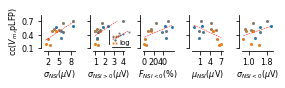

In [29]:
colormap = get_linear_colormap(Blue, Orange)
# Correlation between 
fig1, AX = figure(axes=(1, 5), figsize=(.5,.7))
# now loop over cells
ax1_bis = plt.axes([0.36,0.56,.06,.2])
cc_rank = np.argsort(ccpLFP)
# for k, i in enumerate(np.arange(len(mean_nsi))[cc_ordered]):
for k in cc_rank:
    AX[0].plot([std_nsi[k]], [ccpLFP[k]], 'o', color=colormap(k/(len(ccpLFP)-1)), ms=2)
    AX[1].plot([std_pos_nsi[k]], [ccpLFP[k]], 'o', color=colormap(k/(len(ccpLFP)-1)), ms=2)
    ax1_bis.plot([np.log(std_pos_nsi[k])], [ccpLFP[k]], 'o', color=colormap(k/(len(ccpLFP)-1)), ms=1)
    AX[2].plot([100.*fraction_lf[k]], [ccpLFP[k]], 'o', color=colormap(k/(len(ccpLFP)-1)), ms=2)
    AX[3].plot([mean_nsi[k]], [ccpLFP[k]], 'o', color=colormap(k/(len(ccpLFP)-1)), ms=2)
    AX[4].plot([std_nsi_lf[k]], [ccpLFP[k]], 'o', color=colormap(k/(len(ccpLFP)-1)), ms=2)
from scipy.stats import pearsonr
for x, ax in zip([std_nsi, std_pos_nsi, 100.*fraction_lf, mean_nsi, std_nsi_lf], AX):
    c, p = pearsonr(x, ccpLFP)
    if ax==AX[1]:
        ax.plot([x.min(), 3.4], np.polyval(np.polyfit(x, ccpLFP, 1),[x.min(), 3.4]), 'r--', lw=0.5)
    else:
        ax.plot([x.min(), x.max()], np.polyval(np.polyfit(x, ccpLFP, 1),[x.min(), x.max()]), 'r--', lw=0.5)
x = np.log(std_pos_nsi)
ax1_bis.plot([x.min(), x.max()], np.polyval(np.polyfit(x, ccpLFP, 1),[x.min(), x.max()]), 'r--', lw=0.5)
ax1_bis.annotate('log', (0.45,.0), xycoords='axes fraction', fontsize=FONTSIZE-1)
set_plot(ax1_bis, yticks=[], xticks=[])    
set_plot(AX[0], xlabel='$\sigma_{NSI}$($\mu$V)', ylabel='cc($V_m$,pLFP)', yticks=[0.1,0.4,0.7], xticks=[2,5,8], ylim=[0.1,0.85])
set_plot(AX[1], xlabel='$\sigma_{NSI>0}$($\mu$V)', yticks=[0.1,0.4,0.7], yticks_labels=[], xticks=[1, 2, 3, 4], ylim=[0.1,0.85])
set_plot(AX[2], xlabel='$F_{NSI<0}$(%)', yticks=[0.1,0.4,0.7], yticks_labels=[], ylim=[0.1,0.85], xticks=[0,20,40])
set_plot(AX[3], xlabel='$\mu_{NSI}$($\mu$V)', yticks=[0.1,0.4,0.7], yticks_labels=[], ylim=[0.1,0.85], xticks=[1, 4, 7])
set_plot(AX[4], xlabel='$\sigma_{NSI<0}$($\mu$V)', yticks=[0.1,0.4,0.7], yticks_labels=[], xticks=[1, 1.8], ylim=[0.1,0.85])

In [28]:
from graphs.plot_export import put_list_of_figs_to_svg_fig, export_as_png
put_list_of_figs_to_svg_fig([fig_bars, fig1],
                            fig_name='Figures/Fig_Explained_Correl.svg',
                            figsize=(0.45,0.3),
                            Props={'XCOORD':[0, 25],
                                   'YCOORD':[10, 130],
                                   'LABELS':['a','b'],
                                   'XCOORD_LABELS':[0, 0],
                                   'YCOORD_LABELS':[0, 120]},
                            visualize=False)

# Full Dataset Analysis

In [1]:
# ORDERING THE DATASET ACCORDING TO CORRELATIONS
%run cortical_arousal_index/exp_data.py
DATASET = get_one_dataset('../sparse_vs_balanced/sparse_vs_balanced/data/Wild_Type')

OUTPUT = dict(np.load('cortical_arousal_index/data/final_smooth.npz'))
mean_Output = np.mean(OUTPUT['CROSS_CORRELS'], axis=-1)
NORM = np.zeros(OUTPUT['CROSS_CORRELS'].shape)
Tsmooth = 1e3*OUTPUT['T_SMOOTH']
order = np.argsort(np.mean(OUTPUT['CROSS_CORRELS'], axis=0))
#print(OUTPUT['FILENAMES'][order]) 
iordered = np.empty(len(DATASET), dtype=np.int)
for i, cell in enumerate(DATASET):
    i0 = np.argwhere(cell['files'][0].replace('../', '../../')==OUTPUT['FILENAMES'][order])[0][0]
    iordered[i0] = i
DATASET_ORDERED = []
for i in range(len(DATASET)):
    DATASET_ORDERED.append(DATASET[iordered[i]])
    #print(DATASET_ORDERED[i]['files'][0])
DATASET = DATASET_ORDERED # OVERWRITING DATASET WITH ITS ORDER VERSION
#update_study_output('Ncells', str(len(DATASET)))
#np.savez('paper/paper.npz', **STUDY_OUTPUT) # saved like this !    

In [3]:
%run cortical_arousal_index/exp_data.py
DATASET = get_one_dataset('../sparse_vs_balanced/sparse_vs_balanced/data/Wild_Type')

### Ocurrence of the different states

In [147]:
Fraction_of_Rhythmic = []
Fraction_of_NonRhythmic = []
for i in range(len(DATASET)):
    Fraction_of_Rhythmic.append(100*np.sum((DATA[i]['NSI']<0) & DATA[i]['NSI_validated'])/np.sum(DATA[i]['NSI_validated']))
    Fraction_of_NonRhythmic.append(100*np.sum((DATA[i]['NSI']>0) & DATA[i]['NSI_validated'])/np.sum(DATA[i]['NSI_validated']))
update_study_output('occurence_of_rhythmic', str(round(np.mean(Fraction_of_Rhythmic),1))+'$\pm$'+str(round(np.std(Fraction_of_Rhythmic),1)))
update_study_output('occurence_of_nonrhythmic', str(round(np.mean(Fraction_of_NonRhythmic),1))+'$\pm$'+str(round(np.std(Fraction_of_NonRhythmic),1)))
update_study_output('min_occurence_of_rhythmic', str(round(np.min(Fraction_of_Rhythmic),1)))
update_study_output('max_occurence_of_rhythmic', str(round(np.max(Fraction_of_Rhythmic),1)))
update_study_output('n_fraction_below_2', str(np.sum(np.array(Fraction_of_Rhythmic)<2)))
update_study_output('n_fraction_above_35', str(np.sum(np.array(Fraction_of_Rhythmic)>35)))
print('mean occurence', str(round(np.mean(Fraction_of_Rhythmic),2))+'$\pm$'+str(round(np.std(Fraction_of_Rhythmic),2)), '%')

mean occurence 18.86$\pm$15.87 %


### Mean NSI levels across states

In [126]:
from scipy.stats import skew
Mean_NSI_of_Rhythmic, Std_NSI_of_Rhythmic, Skew_NSI_of_Rhythmic = [], [], []
Mean_NSI_of_NonRhythmic, Std_NSI_of_NonRhythmic, Skew_NSI_of_NonRhythmic = [], [], []
Max_NSI_of_Rhythmic = []
Max_NSI_of_NonRhythmic = []
for i in range(len(DATASET)):
    Mean_NSI_of_Rhythmic.append(np.mean(-DATA[i]['NSI'][(DATA[i]['NSI']<0) & DATA[i]['NSI_validated']]))
    Mean_NSI_of_NonRhythmic.append(np.mean(DATA[i]['NSI'][(DATA[i]['NSI']>0) & DATA[i]['NSI_validated']]))
    Std_NSI_of_Rhythmic.append(np.std(-DATA[i]['NSI'][(DATA[i]['NSI']<0) & DATA[i]['NSI_validated']]))
    Std_NSI_of_NonRhythmic.append(np.std(DATA[i]['NSI'][(DATA[i]['NSI']>0) & DATA[i]['NSI_validated']]))
    Skew_NSI_of_Rhythmic.append(skew(-DATA[i]['NSI'][(DATA[i]['NSI']<0) & DATA[i]['NSI_validated']]))
    Skew_NSI_of_NonRhythmic.append(skew(DATA[i]['NSI'][(DATA[i]['NSI']>0) & DATA[i]['NSI_validated']]))
    Max_NSI_of_Rhythmic.append(np.max(-DATA[i]['NSI'][(DATA[i]['NSI']<0) & DATA[i]['NSI_validated']]))
    Max_NSI_of_NonRhythmic.append(np.max(DATA[i]['NSI'][(DATA[i]['NSI']>0) & DATA[i]['NSI_validated']]))

update_study_output('mean_NSI_of_rhythmic', str(round(np.mean(Mean_NSI_of_Rhythmic),2))+'$\pm$'+str(round(np.std(Mean_NSI_of_Rhythmic),2)))
update_study_output('mean_NSI_of_nonrhythmic', str(round(np.mean(Mean_NSI_of_NonRhythmic),2))+'$\pm$'+str(round(np.std(Mean_NSI_of_NonRhythmic),2)))
update_study_output('pvalue_mean_NSI', sci_str(ttest_rel(Mean_NSI_of_NonRhythmic, np.abs(Mean_NSI_of_Rhythmic)).pvalue,1))
update_study_output('max_NSI_of_rhythmic', str(round(np.mean(Max_NSI_of_Rhythmic),2))+'$\pm$'+str(round(np.std(Max_NSI_of_Rhythmic),2)))
update_study_output('max_NSI_of_nonrhythmic', str(round(np.mean(Max_NSI_of_NonRhythmic),2))+'$\pm$'+str(round(np.std(Max_NSI_of_NonRhythmic),2)))
update_study_output('pvalue_max_NSI', sci_str(ttest_rel(Max_NSI_of_NonRhythmic, np.abs(Max_NSI_of_Rhythmic)).pvalue,1))
update_study_output('std_NSI_of_rhythmic', str(round(np.mean(Std_NSI_of_Rhythmic),2))+'$\pm$'+str(round(np.std(Std_NSI_of_Rhythmic),2)))
update_study_output('std_NSI_of_nonrhythmic', str(round(np.mean(Std_NSI_of_NonRhythmic),2))+'$\pm$'+str(round(np.std(Std_NSI_of_NonRhythmic),2)))
update_study_output('pvalue_std_NSI', sci_str(ttest_rel(Std_NSI_of_NonRhythmic, np.abs(Std_NSI_of_Rhythmic)).pvalue,1))
update_study_output('skew_NSI_of_rhythmic', str(round(np.mean(Skew_NSI_of_Rhythmic),2))+'$\pm$'+str(round(np.std(Skew_NSI_of_Rhythmic),2)))
update_study_output('skew_NSI_of_nonrhythmic', str(round(np.mean(Skew_NSI_of_NonRhythmic),2))+'$\pm$'+str(round(np.std(Skew_NSI_of_NonRhythmic),2)))
update_study_output('pvalue_skew_NSI', sci_str(ttest_rel(Skew_NSI_of_NonRhythmic, np.abs(Skew_NSI_of_Rhythmic)).pvalue,1))

### Getting the correlation between the pLFP level and the power of the [2,5]Hz oscillation within NSI>0 states

In [38]:
from scipy.stats import ttest_rel
CCs_pLFP_lfPow = []
for i in range(len(DATASET)):
    cond = DATA[i]['NSI_validated'] & (DATA[i]['NSI']>0)
    CCs_pLFP_lfPow.append(np.corrcoef(DATA[i]['pLFP_sliding_mean'][cond], DATA[i]['pLFP_max_low_freqs_power'][cond])[0,1])
update_study_output('CCs_pLFP_lfPow_in_NR', str(round(np.mean(CCs_pLFP_lfPow),2))+'$\pm$'+str(round(np.std(CCs_pLFP_lfPow),2)))
update_study_output('pvalue_CCs_pLFP_lfPow_in_NR', sci_str(ttest_rel(CCs_pLFP_lfPow, np.zeros(len(CCs_pLFP_lfPow))).pvalue,1))
print('mean correlation coef.', str(round(np.mean(CCs_pLFP_lfPow),2))+'$\pm$'+str(round(np.std(CCs_pLFP_lfPow),2)))
print('pvalue', sci_str(ttest_rel(CCs_pLFP_lfPow, np.zeros(len(CCs_pLFP_lfPow))).pvalue,1))

mean correlation coef. 0.39$\pm$0.16
pvalue 6.6e-7


### Analyzing the comparison between NSI_pLFP and NSI_Vm

In [223]:
P0 = []
for k, i in enumerate(np.arange(len(DATA))[cc_ordered]):
    P0.append(DATA[i]['p0'])
print('p0:', round(np.mean(P0),2), '+/-', round(np.std(P0),2))
update_study_output('p0_over_cells', str(round(np.mean(P0),2))+'$\pm$'+str(round(np.std(P0),2)))
update_study_output('p_noise_for_accuracy', round(np.mean(P0),2))
update_study_output('Vm_noise_for_accuracy', 2.)

p0: 2.85 +/- 0.73


In [334]:
P1, P2, NOISE = [], [], []
pLFP_tol, Vm_noise_tol = 2.85, 2.
pLFP_tol_strict, Vm_noise_tol_strict = 1, 1 #1.5*DATA[i]['p0'], 0.
for k, i in enumerate(np.arange(len(DATA))[cc_ordered]):
    P1.append(get_correct_percentage(DATA[i], pLFP_tol=pLFP_tol, Vm_noise_tol=Vm_noise_tol)[0])
    P2.append(get_correct_percentage(DATA[i], pLFP_tol=pLFP_tol_strict, Vm_noise_tol=Vm_noise_tol_strict)[0])
    NOISE.append(DATA[i]['p0'])
print('final percentage correct:', round(np.mean(P1),1), round(np.std(P1),1))
print('final percentage correct strict:', round(np.mean(P2),1), round(np.std(P2),1))
update_study_output('matching_percentage_NSI_pLFP_Vm', str(round(np.mean(P1),1))+'$\pm$'+str(round(np.std(P1),1)))
update_study_output('matching_percentage_NSI_pLFP_Vm_strict', str(round(np.mean(P2),1))+'$\pm$'+str(round(np.std(P2),1)))
update_study_output('p_noise_for_accuracy', pLFP_tol)
update_study_output('Vm_noise_for_accuracy', Vm_noise_tol)
update_study_output('p_noise_for_accuracy_strict', pLFP_tol_strict)
update_study_output('Vm_noise_for_accuracy_strict', Vm_noise_tol_strict)

/Users/yzerlaut/anaconda/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/yzerlaut/anaconda/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/yzerlaut/anaconda/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/yzerlaut/anaconda/lib/python3.5/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


final percentage correct: 79.7 10.2
final percentage correct strict: 57.2 15.1


In [227]:
# correct percentages over all cells
wrong_r_r, true_r_r, wrong_r_nr, wrong_nr_nr, wrong_nr_r, all_ep = 0, 0, 0, 0, 0, 0
mean_nsi_wrong_nr_r, mean_nsi_true_r_r = [], []
for k, i in enumerate(np.arange(len(DATA))[cc_ordered]):
    correct_cond, _, _ = get_accepted_samples(DATA[i], pLFP_tol=pLFP_tol, Vm_noise_tol=Vm_noise_tol)
    cond = DATA[i]['NSI_validated']
    wrong_r_r += np.sum(np.invert(correct_cond) & (DATA[i]['NSI'][cond]<0) & (DATA[i]['Vm_NSI'][cond]<0))
    true_r_r += np.sum(correct_cond & (DATA[i]['NSI'][cond]<0) & (DATA[i]['Vm_NSI'][cond]<0))
    wrong_r_nr += np.sum(np.invert(correct_cond) & (DATA[i]['NSI'][cond]<0) & (DATA[i]['Vm_NSI'][cond]>0))
    wrong_nr_nr += np.sum(np.invert(correct_cond) & (DATA[i]['NSI'][cond]>0) & (DATA[i]['Vm_NSI'][cond]>0))
    wrong_nr_r += np.sum(np.invert(correct_cond) & (DATA[i]['NSI'][cond]>0) & (DATA[i]['Vm_NSI'][cond]<0))
    all_ep += np.sum(cond)
    mean_wrong = np.mean(DATA[i]['pLFP_max_low_freqs_power'][cond][np.invert(correct_cond) & (DATA[i]['NSI'][cond]>0) & (DATA[i]['Vm_NSI'][cond]<0)])
    mean_true = np.mean(DATA[i]['pLFP_max_low_freqs_power'][cond][correct_cond & (DATA[i]['NSI'][cond]<0) & (DATA[i]['Vm_NSI'][cond]<0)])
    if (mean_wrong<np.inf) & (mean_true<np.inf):
        mean_nsi_wrong_nr_r.append(mean_wrong)
        mean_nsi_true_r_r.append(mean_true)
    
print('total number of episodes across cells:', wrong_r_r+wrong_r_nr+wrong_nr_nr+wrong_nr_r)
update_study_output('misclassification_pLFP_R_Vm_R', str(round(100*wrong_r_r/(wrong_r_r+wrong_r_nr+wrong_nr_nr+wrong_nr_r),1)))
update_study_output('misclassification_pLFP_R_Vm_NR', str(round(100*wrong_r_nr/(wrong_r_r+wrong_r_nr+wrong_nr_nr+wrong_nr_r),1)))
update_study_output('misclassification_pLFP_NR_Vm_NR', str(round(100*wrong_nr_nr/(wrong_r_r+wrong_r_nr+wrong_nr_nr+wrong_nr_r),1)))
update_study_output('misclassification_pLFP_NR_Vm_R', str(round(100*wrong_nr_r/(wrong_r_r+wrong_r_nr+wrong_nr_nr+wrong_nr_r),1)))
update_study_output('misclassification_pLFP_NR_Vm_R_total', str(round(100*wrong_nr_r/all_ep, 1)))
update_study_output('misclassification_pLFP_NR_Vm_NR_total', str(round(100*wrong_nr_nr/all_ep, 1)))
update_study_output('misclassification_pLFP_R_Vm_R_total', str(round(100*wrong_r_r/all_ep, 1)))
update_study_output('misclassification_pLFP_R_Vm_NR_total', str(round(100*wrong_r_nr/all_ep, 1)))
update_study_output('pLFP_low_freq_pow_for_true_rhythmic', str(round(np.mean(mean_nsi_true_r_r),1))+'$\pm$'+str(round(np.std(mean_nsi_true_r_r),1)))
update_study_output('pLFP_low_freq_pow_for_wrong_nonrhythmic', str(round(np.mean(mean_nsi_wrong_nr_r),1))+'$\pm$'+str(round(np.std(mean_nsi_wrong_nr_r),1)))
update_study_output('pvalue_low_freq_pow_for_wrong_nonrhythmic', sci_str(ttest_rel(mean_nsi_true_r_r, mean_nsi_wrong_nr_r).pvalue,1))
update_study_output('n_low_freq_pow_for_wrong_nonrhythmic', str(int(len(mean_nsi_true_r_r))))

/Users/yzerlaut/anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/yzerlaut/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


total number of episodes across cells: 3542


/Users/yzerlaut/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


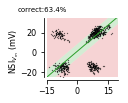

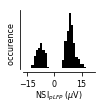

In [187]:
from scipy.optimize import minimize

def make_check_plot(data,
                    xlim=[-15,20], ylim=[-25,35],
                    noise_factor=0,
                    pLFP_tol=2.85,
                    Vm_noise_tol=2):
    fig, ax = figure()
    if noise_factor>0:
        pLFP_tol = noise_factor*data['p0'] # else given value
    x, y = np.array(data['NSI'][data['NSI_validated']]), np.array(data['Vm_NSI'][data['NSI_validated']])
    ax.plot(x[::2], y[::2], 'k.', ms=0.5)
    ax.plot(xlim, ylim, 'w.', ms=0.005) # just ot have the limits on all plots
    correct_percent, func, p = get_correct_percentage(data, pLFP_tol=pLFP_tol, Vm_noise_tol=Vm_noise_tol)       
    ax.plot(xlim, func(np.array(xlim), p), '-', lw=1, color=Green)
    ax.annotate('correct:'+str(round(correct_percent,1))+'%', (-.4, 1.1), xycoords='axes fraction', fontsize=FONTSIZE-1)
    ax.fill_between([2*xlim[0], 2*xlim[1]],
                    func(np.array([2*xlim[0]-pLFP_tol, 2*xlim[1]-pLFP_tol]), p)-Vm_noise_tol,
                    func(np.array([2*xlim[0]+pLFP_tol, 2*xlim[1]+pLFP_tol]), p)+Vm_noise_tol,
                    color=Green, alpha=.2, lw=0)
    y1, y2 = ax.get_ylim()                             
    ax.fill_between([2*xlim[0]+pLFP_tol, 2*xlim[1]], y1*np.ones(2),
                    func(np.array([2*xlim[0], 2*xlim[1]-pLFP_tol]), p)-Vm_noise_tol,
                    color=Red, alpha=.2, lw=0)
    ax.fill_between([xlim[0]-pLFP_tol, xlim[1]], y2*np.ones(2),
                    func(np.array([xlim[0], xlim[1]+pLFP_tol]), p)+Vm_noise_tol,
                    color=Red, alpha=.2, lw=0)
    set_plot(ax, ylabel='NSI$_{V_m}$ (mV)', xlim=xlim, ylim=ylim, xticks=[-15,0,15],yticks=[-20,0,20])
    ax.set_ylabel('NSI$_{V_m}$ (mV)    ', labelpad=-1)
    if last_one:
        ax.set_xlabel('NSI$_{pLFP}$ ($\mu$V)', labelpad=1)
    return fig, ax, correct_percent

# prepare histogram
def make_hist(data,
              xlim=[-15,20],
              Nbin=30,
              color='k',
              last_one=False):
    bins=np.linspace(*xlim, Nbin)
    fig, ax = figure()
    ax.hist(data['NSI'][data['NSI_validated']], bins=bins, normed=True, lw=0, facecolor=color)
    set_plot(ax, ylabel='occurence   ', yticks=[], xticks=[-15, 0 , 15])
    ax.set_xlabel('NSI$_{pLFP}$ ($\mu$V)', labelpad=1)
    return fig

make_check_plot(DATA[0], pLFP_tol=3., Vm_noise_tol=2);
make_hist(DATA[0]);

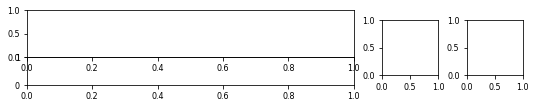

In [232]:

#axNSI = plt.subplot2grid((15, 7), (), colspan=4, rowspan=3)
                

In [127]:
from cortical_arousal_index.plots import *

# FIGS1, FIGS2, FIGS3 = [], [], []
# P1, P2 = [], []
# now loop over cells
# for k, i in enumerate(np.arange(len(DATA))[cc_ordered]):
#     fig_cell, _ = show_raw_data_large_scale(DATA[i], tstart=30, twidth=60, subsampling=1000,
#                                          Tbar=1, NSI_bar=20, NSI_bar_loc=(2,0))
#     fig_cell.suptitle('Cell '+str(k+1)+', cc($V_m$,pLFP) ='+str(round(DATA[i]['cc-Vm-pLFP'],2)),
#                       color=colormap(k/(len(order)-1.)), fontsize=FONTSIZE)
#     fig_cell2 = make_hist(DATA[i], color=colormap(k/(len(DATA)-1.)))
#     fig_cell3, _, percent1 = make_check_plot(DATA[i])
#     P1.append(percent1)
#     FIGS1.append(fig_cell)
#     FIGS2.append(fig_cell2)    
#     FIGS3.append(fig_cell3)    

In [229]:
print('final percentage correct:', round(np.mean(P1),1), round(np.std(P1),1))

final percentage correct: 79.6 10.6


## Making the figure for all cells

In [369]:
N_For_All_cells_Fig = np.array([13,12,11,9,8,5,3,0])
PARAMS = [{} for i in range(len(N_For_All_cells_Fig))]
FIGS1 = [None for i in range(len(N_For_All_cells_Fig))]
FIGS2 = [None for i in range(len(N_For_All_cells_Fig))]
FIGS3 = [None for i in range(len(N_For_All_cells_Fig))]
length = 60.
colormap = get_linear_colormap('r', 'b')

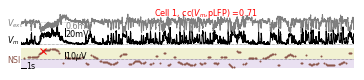

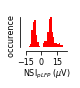

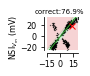

In [370]:
k = 0
i0 = N_For_All_cells_Fig[k]
PARAMS[k] = {'tstart':5., 'Tbar':1, 'subsampling':100,
              'Vm_bar':20, 'LFP_loc':-30, 'Vm_bar_loc':(8,-65), 
             'LFP_bar':0.6, 'NSI_bar':10, 'NSI_bar_loc':(8,2),
             'fig_options':{'figsize':(.6,.07), 'hspace':0.01, 'left':.12, 'bottom':0.01, 'right':.999}}
fig_cell, AX = show_raw_data_large_scale(DATA[i0], **PARAMS[k], twidth=length);
AX[0][0].annotate('Cell '+str(len(DATA)-i0)+', cc($V_m$,pLFP) ='+str(round(DATA[i0]['cc-Vm-pLFP'],2)), (.4,.91),
                  color=colormap(cc_ordered[i0]/(len(DATA)-1.)), fontsize=FONTSIZE, xycoords='axes fraction')
cond0, _, _ = get_accepted_samples(DATA[i0])
cond1 = np.invert(cond0)
cond2 = cond1 & (DATA[i0]['sbsmpl_t'][DATA[i0]['NSI_validated']]>PARAMS[k]['tstart']) &\
    (DATA[i0]['sbsmpl_t'][DATA[i0]['NSI_validated']]<PARAMS[k]['tstart']+length)
xx, yy, tt = DATA[i0]['NSI'][DATA[i0]['NSI_validated']][cond2], DATA[i0]['Vm_NSI'][DATA[i0]['NSI_validated']][cond2],\
    DATA[i0]['sbsmpl_t'][DATA[i0]['NSI_validated']][cond2]
ii = np.argwhere(xx*yy>0).flatten()[:1]
AX[1][0].plot(tt[ii], xx[ii], 'rx', ms=6)
FIGS1[k] = fig_cell
FIGS2[k] = make_hist(DATA[i0],
                     xlim=[-15,25],
                     color=colormap(cc_ordered[i0]/(len(DATA)-1.)))
fig_check, ax, _ = make_check_plot(DATA[i0])
ax.plot(xx[ii], yy[ii], 'rx', ms=6)
FIGS3[k] = fig_check

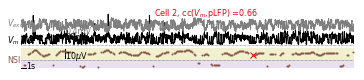

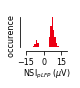

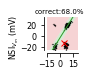

In [371]:
k = 1
i0 = N_For_All_cells_Fig[k]
PARAMS[k] = {'tstart':5., 'Tbar':1, 'subsampling':100,
              'Vm_bar':20, 'Vm_bar_loc':(8,-65), 'LFP_loc':-20,
             'LFP_bar':0.4, 'NSI_bar':10,  'NSI_bar_loc':(8,2),
             'fig_options':{'figsize':(.6,.07), 'hspace':0.01, 'left':.12, 'bottom':0.01, 'right':.999}}
fig_cell, AX = show_raw_data_large_scale(DATA[i0], **PARAMS[k], twidth=length);
AX[0][0].annotate('Cell '+str(len(DATA)-i0)+', cc($V_m$,pLFP) ='+str(round(DATA[i0]['cc-Vm-pLFP'],2)), (.4,.91),
                  color=colormap(cc_ordered[i0]/(len(DATA)-1.)), fontsize=FONTSIZE, xycoords='axes fraction')
cond0, _, _ = get_accepted_samples(DATA[i0])
cond1 = np.invert(cond0)
cond2 = cond1 & (DATA[i0]['sbsmpl_t'][DATA[i0]['NSI_validated']]>PARAMS[k]['tstart']) &\
    (DATA[i0]['sbsmpl_t'][DATA[i0]['NSI_validated']]<PARAMS[k]['tstart']+length)
xx, yy, tt = DATA[i0]['NSI'][DATA[i0]['NSI_validated']][cond2], DATA[i0]['Vm_NSI'][DATA[i0]['NSI_validated']][cond2],\
    DATA[i0]['sbsmpl_t'][DATA[i0]['NSI_validated']][cond2]
ii = np.argwhere((xx*yy<0) & (tt>PARAMS[k]['tstart']+40)).flatten()[:1]
AX[1][0].plot(tt[ii], xx[ii], 'rx', ms=6)
FIGS1[k] = fig_cell
FIGS2[k] = make_hist(DATA[i0], color=colormap(cc_ordered[i0]/(len(DATA)-1.)))
fig_check, ax, _ = make_check_plot(DATA[i0])
ax.plot(xx[ii], yy[ii], 'rx', ms=6)
FIGS3[k] = fig_check

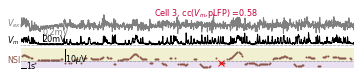

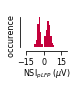

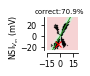

In [372]:
k = 2
i0 = N_For_All_cells_Fig[k]
PARAMS[k] = {'tstart':5., 'Tbar':1, 'subsampling':100,
              'Vm_bar':20, 'Vm_bar_loc':(4,-69), 'LFP_loc':-20,
             'LFP_bar':0.2, 'NSI_bar':10,  'NSI_bar_loc':(8,0),
             'fig_options':{'figsize':(.6,.07), 'hspace':0.01, 'left':.12, 'bottom':0.01, 'right':.999}}
fig_cell, AX = show_raw_data_large_scale(DATA[i0], **PARAMS[k], twidth=length);
AX[0][0].annotate('Cell '+str(len(DATA)-i0)+', cc($V_m$,pLFP) ='+str(round(DATA[i0]['cc-Vm-pLFP'],2)), (.4,.91),
                  color=colormap(cc_ordered[i0]/(len(DATA)-1.)), fontsize=FONTSIZE, xycoords='axes fraction')
cond0, _, _ = get_accepted_samples(DATA[i0])
cond1 = np.invert(cond0)
cond2 = cond1 & (DATA[i0]['sbsmpl_t'][DATA[i0]['NSI_validated']]>PARAMS[k]['tstart']) &\
    (DATA[i0]['sbsmpl_t'][DATA[i0]['NSI_validated']]<PARAMS[k]['tstart']+length)
xx, yy, tt = DATA[i0]['NSI'][DATA[i0]['NSI_validated']][cond2], DATA[i0]['Vm_NSI'][DATA[i0]['NSI_validated']][cond2],\
    DATA[i0]['sbsmpl_t'][DATA[i0]['NSI_validated']][cond2]
ii = np.argwhere((xx*yy>0) & (tt>PARAMS[k]['tstart']+28)).flatten()[1]
AX[1][0].plot(tt[ii], xx[ii], 'rx', ms=6)
FIGS1[k] = fig_cell
FIGS2[k] = make_hist(DATA[i0], color=colormap(cc_ordered[i0]/(len(DATA)-1.)))
fig_check, ax, _ = make_check_plot(DATA[i0])
ax.plot(xx[ii], yy[ii], 'rx', ms=6)
FIGS3[k] = fig_check

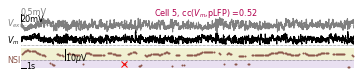

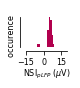

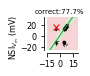

In [373]:
k = 3
i0 = N_For_All_cells_Fig[k]

PARAMS[k] = {'tstart':5., 'Tbar':1, 'subsampling':100,
              'Vm_bar':20, 'Vm_bar_loc':(0,-10), 'LFP_loc':-20,
             'LFP_bar':0.5, 'NSI_bar':10,  'NSI_bar_loc':(8,0),
             'fig_options':{'figsize':(.6,.07), 'hspace':0.01, 'left':.12, 'bottom':0.01, 'right':.999}}
fig_cell, AX = show_raw_data_large_scale(DATA[i0], **PARAMS[k], twidth=length);
AX[0][0].annotate('Cell '+str(len(DATA)-i0)+', cc($V_m$,pLFP) ='+str(round(DATA[i0]['cc-Vm-pLFP'],2)), (.4,.91),
                  color=colormap(cc_ordered[i0]/(len(DATA)-1.)), fontsize=FONTSIZE, xycoords='axes fraction')
cond0, _, _ = get_accepted_samples(DATA[i0])
cond1 = np.invert(cond0)
cond2 = cond1 & (DATA[i0]['sbsmpl_t'][DATA[i0]['NSI_validated']]>PARAMS[k]['tstart']) &\
    (DATA[i0]['sbsmpl_t'][DATA[i0]['NSI_validated']]<PARAMS[k]['tstart']+length)
xx, yy, tt = DATA[i0]['NSI'][DATA[i0]['NSI_validated']][cond2], DATA[i0]['Vm_NSI'][DATA[i0]['NSI_validated']][cond2],\
    DATA[i0]['sbsmpl_t'][DATA[i0]['NSI_validated']][cond2]
ii = np.argwhere((xx*yy<0) & (xx<0) & (tt>PARAMS[k]['tstart']+10)).flatten()[0]
AX[1][0].plot(tt[ii], xx[ii], 'rx', ms=6)
FIGS1[k] = fig_cell
FIGS2[k] = make_hist(DATA[i0], color=colormap(cc_ordered[i0]/(len(DATA)-1.)))
fig_check, ax, _ = make_check_plot(DATA[i0])
ax.plot(xx[ii], yy[ii], 'rx', ms=6)
FIGS3[k] = fig_check

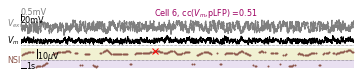

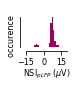

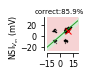

In [374]:
k = 4
i0 = N_For_All_cells_Fig[k]
PARAMS[k] = {'tstart':5., 'Tbar':1, 'subsampling':100,
              'Vm_bar':20, 'Vm_bar_loc':(0,-30), 'LFP_loc':-40,
             'LFP_bar':0.5, 'NSI_bar':10,  'NSI_bar_loc':(3,2),
             'fig_options':{'figsize':(.6,.07), 'hspace':0.01, 'left':.12, 'bottom':0.01, 'right':.999}}
fig_cell, AX = show_raw_data_large_scale(DATA[i0], **PARAMS[k], twidth=length);
AX[0][0].annotate('Cell '+str(len(DATA)-i0)+', cc($V_m$,pLFP) ='+str(round(DATA[i0]['cc-Vm-pLFP'],2)), (.4,.91),
                  color=colormap(cc_ordered[i0]/(len(DATA)-1.)), fontsize=FONTSIZE, xycoords='axes fraction')
cond0, _, _ = get_accepted_samples(DATA[i0])
cond1 = np.invert(cond0)
cond2 = cond1 & (DATA[i0]['sbsmpl_t'][DATA[i0]['NSI_validated']]>PARAMS[k]['tstart']) &\
    (DATA[i0]['sbsmpl_t'][DATA[i0]['NSI_validated']]<PARAMS[k]['tstart']+length)
xx, yy, tt = DATA[i0]['NSI'][DATA[i0]['NSI_validated']][cond2], DATA[i0]['Vm_NSI'][DATA[i0]['NSI_validated']][cond2],\
    DATA[i0]['sbsmpl_t'][DATA[i0]['NSI_validated']][cond2]
ii = np.argwhere((xx*yy>0) & (xx>0) & (tt>PARAMS[k]['tstart']+10)).flatten()
AX[1][0].plot(tt[ii], xx[ii], 'rx', ms=6)
FIGS1[k] = fig_cell
FIGS2[k] = make_hist(DATA[i0], color=colormap(cc_ordered[i0]/(len(DATA)-1.)))
fig_check, ax, _ = make_check_plot(DATA[i0])
ax.plot(xx[ii], yy[ii], 'rx', ms=6)
FIGS3[k] = fig_check

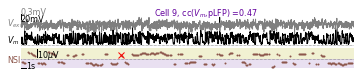

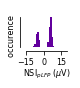

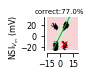

In [375]:
k = 5
i0 = N_For_All_cells_Fig[k]
PARAMS[k] = {'tstart':5., 'Tbar':1, 'subsampling':100,
              'Vm_bar':20, 'Vm_bar_loc':(0,-10), 'LFP_loc':-20,
             'LFP_bar':0.3, 'NSI_bar':10,  'NSI_bar_loc':(3,2),
             'fig_options':{'figsize':(.6,.07), 'hspace':0.01, 'left':.12, 'bottom':0.01, 'right':.999}}
fig_cell, AX = show_raw_data_large_scale(DATA[i0], **PARAMS[k], twidth=length);
AX[0][0].annotate('Cell '+str(len(DATA)-i0)+', cc($V_m$,pLFP) ='+str(round(DATA[i0]['cc-Vm-pLFP'],2)), (.4,.91),
                  color=colormap(cc_ordered[i0]/(len(DATA)-1.)), fontsize=FONTSIZE, xycoords='axes fraction')
cond0, _, _ = get_accepted_samples(DATA[i0])
cond1 = np.invert(cond0)
cond2 = cond1 & (DATA[i0]['sbsmpl_t'][DATA[i0]['NSI_validated']]>PARAMS[k]['tstart']) &\
    (DATA[i0]['sbsmpl_t'][DATA[i0]['NSI_validated']]<PARAMS[k]['tstart']+length)
xx, yy, tt = DATA[i0]['NSI'][DATA[i0]['NSI_validated']][cond2], DATA[i0]['Vm_NSI'][DATA[i0]['NSI_validated']][cond2],\
    DATA[i0]['sbsmpl_t'][DATA[i0]['NSI_validated']][cond2]
ii = np.argwhere((xx*yy<0) & (xx>0) & (tt>PARAMS[k]['tstart']+17)).flatten()[0]
AX[1][0].plot(tt[ii], xx[ii], 'rx', ms=6)
FIGS1[k] = fig_cell
FIGS2[k] = make_hist(DATA[i0], color=colormap(cc_ordered[i0]/(len(DATA)-1.)))
fig_check, ax, _ = make_check_plot(DATA[i0])
ax.plot(xx[ii], yy[ii], 'rx', ms=6)
FIGS3[k] = fig_check

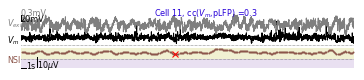

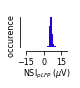

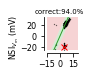

In [376]:
k = 6
i0 = N_For_All_cells_Fig[k]
PARAMS[k] = {'tstart':5., 'Tbar':1, 'subsampling':100,
              'Vm_bar':20, 'Vm_bar_loc':(0,-10), 'LFP_loc':-20,
             'LFP_bar':0.3, 'NSI_bar':10,  'NSI_bar_loc':(3,-8),
             'fig_options':{'figsize':(.6,.07), 'hspace':0.01, 'left':.12, 'bottom':0.01, 'right':.999}}
fig_cell, AX = show_raw_data_large_scale(DATA[i0], **PARAMS[k], twidth=length);
AX[0][0].annotate('Cell '+str(len(DATA)-i0)+', cc($V_m$,pLFP) ='+str(round(DATA[i0]['cc-Vm-pLFP'],2)), (.4,.91),
                  color=colormap(cc_ordered[i0]/(len(DATA)-1.)), fontsize=FONTSIZE, xycoords='axes fraction')
cond0, _, _ = get_accepted_samples(DATA[i0])
cond1 = np.invert(cond0)
cond2 = cond1 & (DATA[i0]['sbsmpl_t'][DATA[i0]['NSI_validated']]>PARAMS[k]['tstart']) &\
    (DATA[i0]['sbsmpl_t'][DATA[i0]['NSI_validated']]<PARAMS[k]['tstart']+length)
xx, yy, tt = DATA[i0]['NSI'][DATA[i0]['NSI_validated']][cond2], DATA[i0]['Vm_NSI'][DATA[i0]['NSI_validated']][cond2],\
    DATA[i0]['sbsmpl_t'][DATA[i0]['NSI_validated']][cond2]
ii = np.argwhere((xx*yy<0) & (xx>0) & (tt>PARAMS[k]['tstart']+17)).flatten()[0]
AX[1][0].plot(tt[ii], xx[ii], 'rx', ms=6)
FIGS1[k] = fig_cell
FIGS2[k] = make_hist(DATA[i0], color=colormap(cc_ordered[i0]/(len(DATA)-1.)))
fig_check, ax, _ = make_check_plot(DATA[i0])
ax.plot(xx[ii], yy[ii], 'rx', ms=6)
FIGS3[k] = fig_check

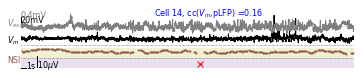

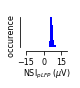

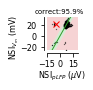

In [377]:
k = 7
i0 = N_For_All_cells_Fig[k]
PARAMS[k] = {'tstart':20., 'Tbar':1, 'subsampling':100,
              'Vm_bar':20, 'Vm_bar_loc':(0,-5), 'LFP_loc':-20,
             'LFP_bar':0.4, 'NSI_bar':10,  'NSI_bar_loc':(3,-8),
             'fig_options':{'figsize':(.6,.07), 'hspace':0.01, 'left':.12, 'bottom':0.01, 'right':.999}}
fig_cell, AX = show_raw_data_large_scale(DATA[i0], **PARAMS[k], twidth=length);
AX[0][0].annotate('Cell '+str(len(DATA)-i0)+', cc($V_m$,pLFP) ='+str(round(DATA[i0]['cc-Vm-pLFP'],2)), (.4,.91),
                  color=colormap(cc_ordered[i0]/(len(DATA)-1.)), fontsize=FONTSIZE, xycoords='axes fraction')
cond0, _, _ = get_accepted_samples(DATA[i0])
cond1 = np.invert(cond0)
cond2 = cond1 & (DATA[i0]['sbsmpl_t'][DATA[i0]['NSI_validated']]>PARAMS[k]['tstart']) &\
    (DATA[i0]['sbsmpl_t'][DATA[i0]['NSI_validated']]<PARAMS[k]['tstart']+length)
xx, yy, tt = DATA[i0]['NSI'][DATA[i0]['NSI_validated']][cond2], DATA[i0]['Vm_NSI'][DATA[i0]['NSI_validated']][cond2],\
    DATA[i0]['sbsmpl_t'][DATA[i0]['NSI_validated']][cond2]
ii = np.argwhere((xx<0) & (tt>PARAMS[k]['tstart'])).flatten()[0]
AX[1][0].plot(tt[ii], xx[ii], 'rx', ms=6)
FIGS1[k] = fig_cell
FIGS2[k] = make_hist(DATA[i0], color=colormap(cc_ordered[i0]/(len(DATA)-1.)), last_one=True)
fig_check, ax, _ = make_check_plot(DATA[i0], last_one=True)
ax.plot(xx[ii], yy[ii], 'rx', ms=6)
FIGS3[k] = fig_check

In [316]:
FIGS1 = [fig_cell1 for i in range(3)]                
from graphs.plot_export import put_list_of_figs_to_svg_fig, export_as_png
put_list_of_figs_to_svg_fig(FIGS1,
                            fig_name='Figures/Fig_All_cells.svg',
                            figsize=(0.8,0.1*len(FIGS1)),
                            Props={'XCOORD':[0 for i in range(len(FIGS1))],
                                   'YCOORD':[70*i for i in range(len(FIGS1))]},
                            visualize=False)
#plt.close('all')

In [317]:
export_as_png(os.getcwd()+'/Figures/Fig_All_cells.svg', dpi=200)

In [378]:
from graphs.plot_export import put_list_of_figs_to_svg_fig, export_as_png
put_list_of_figs_to_svg_fig(FIGS1+FIGS2+FIGS3,
                            fig_name='paper/Figures/Fig_All_cells.svg',
                            figsize=(0.8,0.1*len(FIGS1)),
                            Props={'XCOORD':[0 for i in range(len(FIGS1))]+\
                                   [348 for i in range(len(FIGS2))]+\
                                   [440 for i in range(len(FIGS3))],
                                   'YCOORD':[70*i for i in range(len(FIGS1))]+\
                                   [70*i+6 for i in range(len(FIGS3))]+\
                                   [70*i+5 for i in range(len(FIGS2))],
                                   'LABELS':['a','b','c'],
                                   'XCOORD_LABELS':[-15,350,415],
                                   'YCOORD_LABELS':[-8,-8,-8]},
                            visualize=False)
#plt.close('all')

In [379]:
export_as_png(os.getcwd()+'/paper/Figures/Fig_All_cells.svg', dpi=200)

In [200]:
from IPython.display import Image
#Image(filename='paper/Figures/Fig_All_cells.png', width=300)

## Making the supplementary figure for all remaining cells

In [359]:
#N_For_All_cells_Fig = np.array([13,12,11,9,8,5,3,0]
N_For_All_cells_Supp_Fig = np.array([10, 7, 6, 4, 2, 1])
PARAMS = [{} for i in range(len(N_For_All_cells_Supp_Fig))]
FIGS1 = [None for i in range(len(N_For_All_cells_Supp_Fig))]
FIGS2 = [None for i in range(len(N_For_All_cells_Supp_Fig))]
FIGS3 = [None for i in range(len(N_For_All_cells_Supp_Fig))]
length = 60.

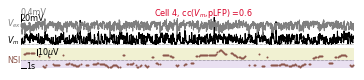

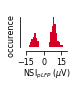

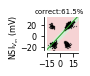

In [360]:
k = 0
i0 = N_For_All_cells_Supp_Fig[k]
PARAMS[k] = {'tstart':20., 'Tbar':1, 'subsampling':100,
              'Vm_bar':20, 'Vm_bar_loc':(0,-5), 'LFP_loc':-20,
             'LFP_bar':0.4, 'NSI_bar':10,  'NSI_bar_loc':(3,10),
             'fig_options':{'figsize':(.6,.07), 'hspace':0.01, 'left':.12, 'bottom':0.01, 'right':.999}}
fig_cell, AX = show_raw_data_large_scale(DATA[i0], **PARAMS[k], twidth=length);
AX[0][0].annotate('Cell '+str(len(DATA)-i0)+', cc($V_m$,pLFP) ='+str(round(DATA[i0]['cc-Vm-pLFP'],2)), (.4,.91),
                  color=colormap(cc_ordered[i0]/(len(DATA)-1.)), fontsize=FONTSIZE, xycoords='axes fraction')
FIGS1[k] = fig_cell
FIGS2[k] = make_hist(DATA[i0], color=colormap(cc_ordered[i0]/(len(DATA)-1.)), last_one=True)
fig_check, ax, _ = make_check_plot(DATA[i0])
FIGS3[k] = fig_check

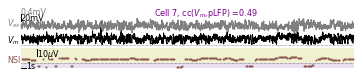

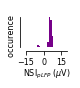

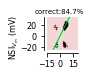

In [361]:
k = 1
i0 = N_For_All_cells_Supp_Fig[k]
PARAMS[k] = {'tstart':20., 'Tbar':1, 'subsampling':100,
              'Vm_bar':20, 'Vm_bar_loc':(0,-5), 'LFP_loc':-20,
             'LFP_bar':0.4, 'NSI_bar':10,  'NSI_bar_loc':(3,10),
             'fig_options':{'figsize':(.6,.07), 'hspace':0.01, 'left':.12, 'bottom':0.01, 'right':.999}}
fig_cell, AX = show_raw_data_large_scale(DATA[i0], **PARAMS[k], twidth=length);
AX[0][0].annotate('Cell '+str(len(DATA)-i0)+', cc($V_m$,pLFP) ='+str(round(DATA[i0]['cc-Vm-pLFP'],2)), (.4,.91),
                  color=colormap(cc_ordered[i0]/(len(DATA)-1.)), fontsize=FONTSIZE, xycoords='axes fraction')
FIGS1[k] = fig_cell
FIGS2[k] = make_hist(DATA[i0], color=colormap(cc_ordered[i0]/(len(DATA)-1.)))
fig_check, ax, _ = make_check_plot(DATA[i0])
FIGS3[k] = fig_check

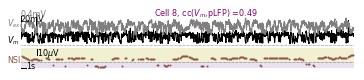

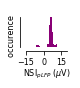

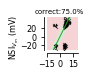

In [362]:
k = 2
i0 = N_For_All_cells_Supp_Fig[k]
PARAMS[k] = {'tstart':0., 'Tbar':1, 'subsampling':100,
              'Vm_bar':20, 'Vm_bar_loc':(0,-5), 'LFP_loc':-20,
             'LFP_bar':0.4, 'NSI_bar':10,  'NSI_bar_loc':(3,10),
             'fig_options':{'figsize':(.6,.07), 'hspace':0.01, 'left':.12, 'bottom':0.01, 'right':.999}}
fig_cell, AX = show_raw_data_large_scale(DATA[i0], **PARAMS[k], twidth=length);
AX[0][0].annotate('Cell '+str(len(DATA)-i0)+', cc($V_m$,pLFP) ='+str(round(DATA[i0]['cc-Vm-pLFP'],2)), (.4,.91),
                  color=colormap(cc_ordered[i0]/(len(DATA)-1.)), fontsize=FONTSIZE, xycoords='axes fraction')
FIGS1[k] = fig_cell
FIGS2[k] = make_hist(DATA[i0], color=colormap(cc_ordered[i0]/(len(DATA)-1.)))
fig_check, ax, _ = make_check_plot(DATA[i0], ylim=[-30, 45])
FIGS3[k] = fig_check

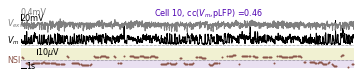

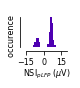

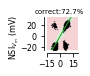

In [363]:
k = 3
i0 = N_For_All_cells_Supp_Fig[k]
PARAMS[k] = {'tstart':20., 'Tbar':1, 'subsampling':100,
              'Vm_bar':20, 'Vm_bar_loc':(0,-5), 'LFP_loc':-20,
             'LFP_bar':0.4, 'NSI_bar':10,  'NSI_bar_loc':(3,10),
             'fig_options':{'figsize':(.6,.07), 'hspace':0.01, 'left':.12, 'bottom':0.01, 'right':.999}}
fig_cell, AX = show_raw_data_large_scale(DATA[i0], **PARAMS[k], twidth=length);
AX[0][0].annotate('Cell '+str(len(DATA)-i0)+', cc($V_m$,pLFP) ='+str(round(DATA[i0]['cc-Vm-pLFP'],2)), (.4,.91),
                  color=colormap(cc_ordered[i0]/(len(DATA)-1.)), fontsize=FONTSIZE, xycoords='axes fraction')
FIGS1[k] = fig_cell
FIGS2[k] = make_hist(DATA[i0], color=colormap(cc_ordered[i0]/(len(DATA)-1.)))
fig_check, ax, _ = make_check_plot(DATA[i0], ylim=[-25, 35])
FIGS3[k] = fig_check

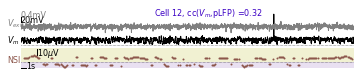

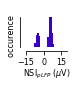

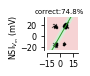

In [364]:
k = 4
i0 = N_For_All_cells_Supp_Fig[k]
PARAMS[k] = {'tstart':20., 'Tbar':1, 'subsampling':100,
              'Vm_bar':20, 'Vm_bar_loc':(0,-5), 'LFP_loc':-20,
             'LFP_bar':0.4, 'NSI_bar':10,  'NSI_bar_loc':(3,10),
             'fig_options':{'figsize':(.6,.07), 'hspace':0.01, 'left':.12, 'bottom':0.01, 'right':.999}}
fig_cell, AX = show_raw_data_large_scale(DATA[i0], **PARAMS[k], twidth=length);
AX[0][0].annotate('Cell '+str(len(DATA)-i0)+', cc($V_m$,pLFP) ='+str(round(DATA[i0]['cc-Vm-pLFP'],2)), (.4,.91),
                  color=colormap(cc_ordered[i0]/(len(DATA)-1.)), fontsize=FONTSIZE, xycoords='axes fraction')
FIGS1[k] = fig_cell
FIGS2[k] = make_hist(DATA[i0], color=colormap(cc_ordered[i0]/(len(DATA)-1.)))
fig_check, ax, _ = make_check_plot(DATA[i0])
FIGS3[k] = fig_check

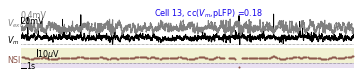

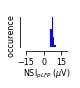

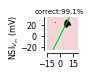

In [365]:
k = 5
i0 = N_For_All_cells_Supp_Fig[k]
PARAMS[k] = {'tstart':20., 'Tbar':1, 'subsampling':100,
              'Vm_bar':20, 'Vm_bar_loc':(0,-5), 'LFP_loc':-20,
             'LFP_bar':0.4, 'NSI_bar':10,  'NSI_bar_loc':(3,10),
             'fig_options':{'figsize':(.6,.07), 'hspace':0.01, 'left':.12, 'bottom':0.01, 'right':.999}}
fig_cell, AX = show_raw_data_large_scale(DATA[i0], **PARAMS[k], twidth=length);
AX[0][0].annotate('Cell '+str(len(DATA)-i0)+', cc($V_m$,pLFP) ='+str(round(DATA[i0]['cc-Vm-pLFP'],2)), (.4,.91),
                  color=colormap(cc_ordered[i0]/(len(DATA)-1.)), fontsize=FONTSIZE, xycoords='axes fraction')
FIGS1[k] = fig_cell
FIGS2[k] = make_hist(DATA[i0], color=colormap(cc_ordered[i0]/(len(DATA)-1.)))
fig_check, ax, _ = make_check_plot(DATA[i0])
FIGS3[k] = fig_check

In [366]:
from graphs.plot_export import put_list_of_figs_to_svg_fig, export_as_png
put_list_of_figs_to_svg_fig(FIGS1+FIGS3+FIGS2,
                            fig_name='paper/Figures/Fig_All_cells_supp.svg',
                            figsize=(0.8,0.1*len(FIGS1)),
                            Props={'XCOORD':[0 for i in range(len(FIGS1))]+\
                                   [375 for i in range(len(FIGS2))]+\
                                   [430 for i in range(len(FIGS3))],
                                   'YCOORD':[70*i for i in range(len(FIGS1))]+\
                                   [70*i+9 for i in range(len(FIGS3))]+\
                                   [70*i+5 for i in range(len(FIGS2))],
                                   'LABELS':['a','b','c'],
                                   'XCOORD_LABELS':[-15,350,430],
                                   'YCOORD_LABELS':[-8,-8,-8]},
                            visualize=False)
#plt.close('all')

In [125]:
export_as_png(os.getcwd()+'/paper/Figures/Fig_All_cells_supp.svg', dpi=200)

In [20]:
from IPython.display import Image
#Image(filename='paper/Figures/Fig_All_cells_supp.png', width=300)

# Correlation analysis

In [62]:
colormap = get_linear_colormap(Blue, Red)

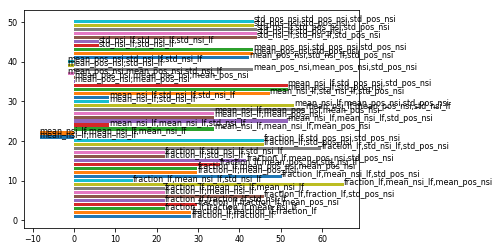

/Users/yzerlaut/anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


                            OLS Regression Results                            
Dep. Variable:                     cc   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     4.634
Date:                Thu, 20 Dec 2018   Prob (F-statistic):             0.0403
Time:                        18:18:27   Log-Likelihood:                 18.792
No. Observations:                  14   AIC:                            -21.58
Df Residuals:                       6   BIC:                            -16.47
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.7108      0.603      1.179   

/Users/yzerlaut/anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


                            OLS Regression Results                            
Dep. Variable:                     cc   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     7.456
Date:                Thu, 20 Dec 2018   Prob (F-statistic):            0.00656
Time:                        18:18:29   Log-Likelihood:                 14.013
No. Observations:                  14   AIC:                            -20.03
Df Residuals:                      10   BIC:                            -17.47
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.5894      0.136      4.322      

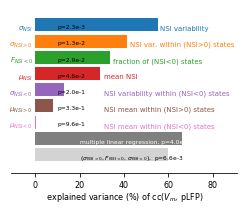

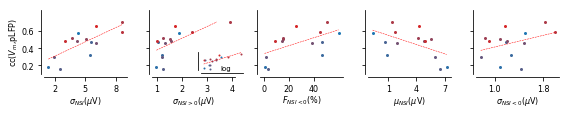

In [11]:


#plt.close('all')

In [12]:
export_as_png(os.getcwd()+'/paper/Figures/Fig_Explained_Correl.svg', dpi=200)

In [357]:
from IPython.display import Image
#Image(filename='paper/Figures/Fig_Explained_Correl.png', width=300)

# Limitations

In [1]:
# let's do the same based on the Vm recordings and compare the two
%run cortical_arousal_index/exp_data.py
DATASET = get_one_dataset('../sparse_vs_balanced/sparse_vs_balanced/data/Wild_Type')

/Users/yzerlaut/anaconda/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
## LOAD ALL DATASET
DATA = []
for i in np.arange(len(DATASET)):
    data = load_data(DATASET[i]['files'][0], args, full_processing=True)
    # compute the Network State Index
    functions.compute_Network_State_Index(data, key='sbsmpl_Vm', target_key='Vm_NSI', p0_key='p0_Vm',
                                          Tstate=args.Tstate,
                                          Var_criteria=1000, # NOT USED, WE USE THE VALIDATION OF pLFP !!
                                          alpha=args.alpha,
                                          T_sliding_mean=args.T_sliding_mean)
    
    DATA.append(data)
    # DATA[i]['cc-Vm-LFP'] = np.corrcoef(DATA[i]['sbsmpl_Vm'], DATA[i]['sbsmpl_Extra'])[0,1]
    # DATA[i]['cc-Vm-pLFP'] = np.corrcoef(DATA[i]['sbsmpl_Vm'], DATA[i]['pLFP'])[0,1]        

correct fraction: 69
0 correl: (0.5077627788077339, 8.344748326802096e-71)
correct fraction: 71
1 correl: (0.5384134711434053, 1.3825211610790765e-189)
correct fraction: 74
2 correl: (0.7354057304088462, 1.8478842184900618e-244)
correct fraction: 86
3 correl: (0.41323829227211517, 4.8890537439428056e-46)


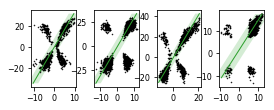

In [24]:
noise_factor = 1.

from scipy.stats import pearsonr
import matplotlib.patches as patches
fig, AX = figure(figsize=(.15*len(DATA), 0.14), axes=(1, len(DATA)))
for i in range(len(DATA)):
def make_check_plot(data, xlim=[-15,15], ylim=[-20,30]):
    pLFP_tol = noise_factor+data['p0']
    x, y = np.array(data['NSI'][data['NSI_validated']]), np.array(data['Vm_NSI'][data['NSI_validated']])
    AX[0][i].plot(x, y, 'ko', ms=0.5)
    pol = np.polyfit(x[(x*y)>=0], y[(x*y)>=0], 1)
    AX[0][i].plot(xlim, np.polyval(pol, xlim), '-', lw=1, color=Green)
    AX[0][i].add_patch(patches.Polygon(xy=list(zip([xlim[0]-pLFP_tol, xlim[0]+pLFP_tol,
                                                    xlim[1]+pLFP_tol, xlim[1]-pLFP_tol],
                                                   np.polyval(pol, [xlim[0], xlim[0], xlim[1], xlim[1]]))),
                                       fill=True, color=Green, lw=0, alpha=.2))
    correct_cond = (y>=np.polyval(pol, x-pLFP_tol)) & (y<=np.polyval(pol, x+pLFP_tol))
    print('correct fraction:', round(100.*len(x[correct_cond])/len(x),1))
    print(i, 'correl:', pearsonr(x, y))

0 correl: (0.4578803972522619, 2.4557673611416968e-57)
1 correl: (0.5620058450568272, 2.4633297386657988e-208)
2 correl: (0.6821686064412424, 6.882594701143787e-201)
3 correl: (0.40375986190517477, 3.2259803416851213e-43)


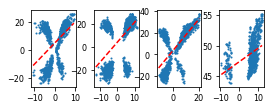

In [16]:
from scipy.stats import pearsonr
fig, AX = figure(figsize=(.15*len(DATA), 0.14), axes=(1, len(DATA)))
for i in range(len(DATA)):
    x, y = np.array(DATA[i]['NSI'][DATA[i]['NSI_validated']]), np.array(DATA[i]['Vm_NSI'][DATA[i]['NSI_validated']])
    AX[0][i].plot(x, y, 'o', ms=0.5)
    AX[0][i].plot([x.min(), x.max()], np.polyval(np.polyfit(x, y, 1), [x.min(), x.max()]), 'r--')
    print(i, 'correl:', pearsonr(x, y))

# Wavelet analysis

In [22]:
"""
Wavelet functions can be found in the 'functions' module
"""
from cortical_arousal_index.functions import *

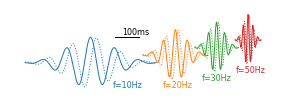

In [23]:
fig1, ax = figure(figsize=(.46,.1), bottom=0.02, left=0.02)     
for i, f, xshift, xshift2, yshift2, yshift in zip(
        range(4), [10., 20,  30., 50.],
        [0, 3.5, 5.2, 6.5],
        [0.9, 3., 4.6, 6],
        [0., 0., 0.3, .6],
        np.arange(4)*.3):
    t, wvl = get_Morlet_of_right_size(f, 1e-3, with_t=True)
    ax.plot(t+.1*xshift, yshift+np.real(wvl),
         c='C'+str(i), lw=1)
    ax.plot(t+.1*xshift, yshift+np.imag(wvl), c='C'+str(i), ls=':',
            lw=1)
    ax.annotate('f='+str(int(f))+'Hz', (.1*xshift2, yshift2-1), color='C'+str(i), fontsize=FONTSIZE)
ax.plot([.1,.2], [1,1], 'k-', lw=1)
ax.annotate('100ms', (.13, 1.1), fontsize=FONTSIZE)    
set_plot(plt.gca(), [])
fig1.savefig('paper/Figures/wavelets_vis.svg')

## Finding the right normalization for CWT

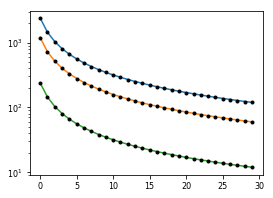

In [24]:
# let's check that the norm matches the numerical estimate

def norm_constant_num(freq, dt, w0=6.):
    Tmax = Morlet_Wavelet_Decay(freq, w0=w0)
    t = np.arange(-int(Tmax/dt), int(Tmax/dt)+1)*dt
    return np.abs(np.dot(np.cos(2.*np.pi*freq*t),\
                         np.conj(get_Morlet_of_right_size(freq, dt, w0=w0))))

fig, ax = figure(figsize=(.6,.3))
for dt in [1e-4, 2e-4, 1e-3]:
    ax.semilogy([norm_constant_th(f, dt, w0=6.) for f in np.linspace(5, 100, 30)])
    ax.semilogy([norm_constant_num(f, dt, w0=6.) for f in np.linspace(5, 100, 30)], 'ko', ms=3)

In [25]:
noise_level = 0.
nfreq = 100

# temporal sampling
dt, tstop = 1e-3, 2.1
t = np.arange(int(tstop/dt))*dt

# ### artificially generated signal, transient oscillations
freq1, onset1, width1, amp1 = 40., 200e-3, 50e-3, 2.
freq2, onset2, width2, amp2 = 10., 700e-3, 150e-3, 2.
freq3, onset3, width3, amp3 = 60., 1200e-3, 50e-3, 2.
freq4, onset4, width4, amp4 = 40., 1700e-3, 150e-3, 1.
baseline = 0.
data  = baseline+\
    amp1*np.cos(2*np.pi*freq1*t)*np.exp(-(t-onset1)**2/2./width1**2)+\
    amp2*np.cos(2*np.pi*freq2*t)*np.exp(-(t-onset2)**2/2./width2**2)+\
    amp3*np.cos(2*np.pi*freq3*t)*np.exp(-(t-onset3)**2/2./width3**2)+\
    amp4*np.cos(2*np.pi*freq4*t)*np.exp(-(t-onset4)**2/2./width4**2)

# ### adding colored noise to test robustness
data += noise_level*np.convolve(np.exp(-np.arange(1000)*dt/400e-3),\
                    np.random.randn(len(t)), mode='same') # a slow one
data += noise_level*np.convolve(np.exp(-np.arange(1000)*dt/5e-3),\
                    np.random.randn(len(t)), mode='same') # a faster one

# Continuous Wavelet Transform analysis
freqs = np.linspace(1, 95, nfreq)
coefs = my_cwt(data, freqs, dt)

amp = np.abs(coefs)
cond = np.abs(coefs)<np.max(np.abs(coefs))*0.1
phase = np.angle(coefs)
phase[cond] = np.inf

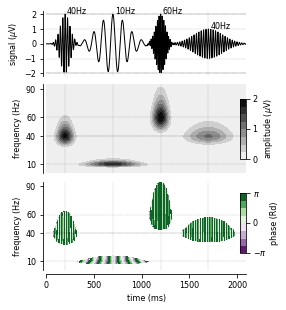

In [26]:
"""
a plot to illustrate the output of the wavelet analysis
"""
colormap=mpl.cm.binary
fig2, AX = figure(figsize=(0.46,0.36),
                 hspace=1.1, bottom=0.35, right=.9, left=.45,
                 axes_extents=[[[1,3]],[[1,4]], [[1,4]]])
# signal plot
plot(1e3*t, data, c='k', lw=1, ax=AX[0][0],\
     axes_args={'ylabel':'signal ($\mu$V)',
                'xlim':[1e3*t[0], 1e3*t[-1]],
                'yticks':baseline+np.arange(-2,3),
                'spines':['left']})
yyl = AX[0][0].get_ylim()
for f, a, tt in zip([freq1, freq2, freq3, freq4],\
                    [amp1, amp2, amp3, amp4],
                    [onset1, onset2, onset3, onset4]):
    AX[0][0].annotate(str(int(f))+'Hz', (1e3*tt+20, a+baseline), fontsize=FONTSIZE)
    AX[0][0].plot(1e3*tt+np.zeros(2), yyl, 'k:', lw=.2)
    for ax in [AX[1][0], AX[2][0]]:
        ax.plot(1e3*np.arange(2)*t[-1], [f, f], 'k:', lw=.2)
        ax.plot(1e3*tt+freqs*0, freqs, 'k:', lw=.2)
    AX[0][0].plot(1e3*np.arange(2)*t[-1], [a, a], 'k:', lw=.2)
    AX[0][0].plot(1e3*np.arange(2)*t[-1], [-a, -a], 'k:', lw=.2)

# time frequency power plot
c = AX[1][0].contourf(1e3*t, freqs, amp, cmap=colormap)
set_plot(AX[1][0], ['left'], xlim=[1e3*t[0], 1e3*t[-1]],
         ylabel='frequency (Hz)', yticks=[freq1, freq2, freq3, 90])

# inset with legend
acb = plt.axes([.85, .48, .02, .2])
cb = plt.colorbar(c, cax=acb, label='amplitude ($\mu$V)')
cb.set_ticks([0, 1, 2, 3])

# time frequency phase plot
c = AX[2][0].contourf(1e3*t, freqs, phase, cmap='PRGn')
set_plot(AX[2][0], xlim=[1e3*t[0], 1e3*t[-1]],
         xlabel='time (ms)', xticks=np.arange(5)*500,
         ylabel='frequency (Hz)', yticks=[freq1, freq2, freq3, 90])

# inset with legend
acb = plt.axes([.85, .17, .02, .2])
cb = plt.colorbar(c, cax=acb, label='phase (Rd)')
cb.set_ticks([-np.pi, 0, np.pi])
cb.set_ticklabels(['$-\pi$', '0', '$\pi$'])

In [28]:
from graphs.plot_export import put_list_of_figs_to_svg_fig
put_list_of_figs_to_svg_fig([fig1, fig2],
                            fig_name='paper/Figures/Fig_Wavelet_Demo.svg',
                            figsize=(0.335,0.34),
                            Props={'XCOORD':[-2,-5],
                                   'YCOORD':[-5,84],
                                   'XCOORD_LABELS':[-5, -5],
                                   'YCOORD_LABELS':[10, 78],
                                   'LABELS':['a','b']},
                            visualize=False)
export_as_png(os.getcwd()+'/paper/Figures/Fig_Wavelet_Demo.svg', dpi=100)

In [44]:
from IPython.display import Image
#Image(filename='paper/Figures/Fig_Wavelet_Demo.png', width=300)

# A quick draft of the analysis

In [370]:
"""
Loading a sample datafile for the awake
"""
from data_analysis.IO.load_data import load_file
data = load_file('../sparse_vs_balanced/'+\
                 'sparse_vs_balanced/data/Wild_Type/Cell14/17o27001.abf')
cond = (data[0]>100) & (data[0]<200)
data_awake={'t':data[0][cond], 'Vm':data[1][1][cond], 'Extra':data[1][0][cond]}
data_awake['dt'] = data_awake['t'][1]-data_awake['t'][0]

from graphs.my_graph import *
from scipy.integrate import cumtrapz

def get_max_of_hist(data, nbins=300, smoothing=2):
    """
    maybe need to get more complex to identify the first maximum
    (e.g. Up and Down states case) 
    """
    binsize = (data['pLFP'].max()-data['pLFP'].min())/nbins
    Hist, be = np.histogram(data['pLFP'],
                            bins=np.concatenate([
                                np.arange(-2*smoothing,0)*binsize+data['pLFP'].min(),
                                np.arange(nbins)*binsize+data['pLFP'].min(),
                                np.arange(0,2*smoothing)*binsize+data['pLFP'].max()
                            ]), normed=True)
    i0 = np.argmax(gaussian_smoothing(Hist,smoothing))
    data['max_of_hist']=be[i0+1]
    data['noise_estimate']=np.std(data['pLFP'][data['pLFP']<data['max_of_hist']])
    data['hist_amp']=Hist[i0]
    return {'max_of_hist':be[i0],
            'noise_estimate':be[i0]-data['pLFP'].min(),
            'hist_amp':Hist[i0]}

get_max_of_hist(data_awake)


(<matplotlib.figure.Figure at 0x1a0f85d6d8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a0f85dc50>)

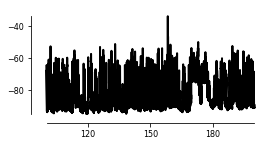

In [3]:
plot(data_awake['t'][::100], data_awake['Vm'][::100], fig_args=dict(figsize=(.6,.2)))

(<matplotlib.figure.Figure at 0x1a0f88ea58>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a0f881550>)

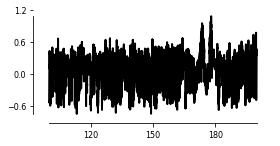

In [4]:
plot(data_awake['t'][::100], data_awake['Extra'][::100], fig_args=dict(figsize=(.6,.2)))

In [371]:
from data_analysis.processing.signanalysis import gaussian_smoothing

def preprocess_LFP(data,
                   freqs = np.linspace(50, 300, 5),
                   new_dt = 5e-3, smoothing=20e-3, pLFP_unit='$\mu$V'):
    """
    performs continuous wavelet transform
    """
    data['W'] = my_cwt(data['Extra'], freqs, data['dt'])
    data['pLFP_freqs'] = freqs
    W2 = np.abs(data['W']).mean(axis=0)
    isubsmpl = int(round(new_dt/data['dt']))
    data['pLFP'] = gaussian_smoothing(\
                                      np.reshape(W2[:int(len(W2)/isubsmpl)*isubsmpl],
                                                 (int(len(W2)/isubsmpl),isubsmpl)).mean(axis=1),
                                      int(smoothing/new_dt))
    
    data['pLFP_unit']=pLFP_unit
    if pLFP_unit=='$\mu$V':
        data['pLFP'] *= 1e3
        
    data['new_t'] = np.arange(len(data['pLFP']))*new_dt+data['t'][0]
    data['new_indices'] = np.arange(len(data['pLFP']))*isubsmpl
    data['new_Vm'] = data['Vm'][data['new_indices']]
    data['new_Extra'] = data['Extra'][data['new_indices']]
    
    data['new_dt'] = new_dt
    
preprocess_LFP(data_awake)        

### Illustrating the output of the analysis

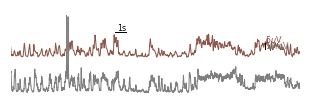

In [372]:
t0, width = 153.5, 25
spikes=-30
vm_color=Grey
pLFP_color=Brown
Vm_bar = 10
pLFP_bar=5
T_bar=1.
pLFP_loc=-45

cond = (data_awake['new_t']>t0) & (data_awake['new_t']<t0+width)
fig_with_pLFP, ax = figure(figsize=(.5,.15), left=.01, bottom=.1)
ax = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
ax.plot(data_awake['new_t'][cond],
        data_awake['pLFP'][cond].mean()+data_awake['pLFP'][cond]/pLFP_bar*Vm_bar+pLFP_loc,
        '-', lw=1, color=pLFP_color)
cond = cond & (data_awake['new_Vm']<spikes)
ax.plot(data_awake['new_t'][cond], data_awake['new_Vm'][cond], '-', color=vm_color, lw=1)
cond0 = (data_awake['t']>t0) & (data_awake['t']<t0+width)
i0 = np.argwhere((data_awake['Vm'][cond0][1:]>spikes) & (data_awake['Vm'][cond0][:-1]<=spikes)).flatten()
for ii in i0:
    ax.plot(data_awake['t'][cond0][ii-100:ii+100], data_awake['Vm'][cond0][ii-100:ii+100], '-', color=vm_color, lw=1)
# ax.plot([data_awake['new_t'][cond][0], data_awake['new_t'][cond][-1]], pLFP_loc*np.ones(2), ':', color=pLFP_color, lw=1)
# ax.plot([data_awake['new_t'][cond][0], data_awake['new_t'][cond][-1]], -50*np.ones(2), ':', color=vm_color, lw=1)
# Tbar
ax.plot([data_awake['new_t'][cond][0]+T_bar+8, data_awake['new_t'][cond][0]+2*T_bar+8], [10, 10], 'k-', lw=1)
ax.annotate(str(int(T_bar))+'s', (data_awake['new_t'][cond][0]+T_bar+8+.2, 11), fontsize=FONTSIZE)
# Vm-LFP bar
ax.plot([data_awake['new_t'][cond][-1]-3*T_bar, data_awake['new_t'][cond][-1]-3*T_bar], [pLFP_loc/5, pLFP_loc/5-Vm_bar], 'k-', lw=1)
ax.annotate(str(int(Vm_bar))+'mV', (data_awake['new_t'][cond][-1]-3*T_bar, pLFP_loc/5-Vm_bar), fontsize=FONTSIZE, color=vm_color)
ax.annotate(str(int(pLFP_bar))+'$\mu$V', (data_awake['new_t'][cond][-1]-3*T_bar, pLFP_loc/5),
            fontsize=FONTSIZE, color=pLFP_color)
set_plot(ax, [], xlim=[data_awake['new_t'][cond][0], data_awake['new_t'][cond][-1]], xticks=[], yticks=[])

#fig.savefig(desktop+'fig.svg')

### Looking for the best frequency content

In [422]:
DISCRET = 6
WAVELET_NUM = 5
CENTER_FREQUENCIES = np.logspace(0,3,DISCRET)
BAND_LENGTH_FACTOR = np.linspace(1.01,4.,DISCRET)

CROSS_CORRELS = np.zeros((len(CENTER_FREQUENCIES), len(BAND_LENGTH_FACTOR)))

for i, cf in enumerate(CENTER_FREQUENCIES):
    for j, blf in enumerate(BAND_LENGTH_FACTOR):
        preprocess_LFP(data_awake, freqs=np.linspace(cf/blf, cf*blf, WAVELET_NUM))        
        CROSS_CORRELS[i,j] = np.abs(np.corrcoef(data_awake['new_Vm'], data_awake['pLFP']))[0,1]

/Users/yzerlaut/anaconda/lib/python3.5/site-packages/matplotlib/axes/_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


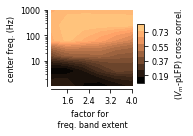

In [109]:
fig_optimum, ax = figure(right=.9)
p = plt.contourf(BAND_LENGTH_FACTOR, CENTER_FREQUENCIES,
                 np.array(CROSS_CORRELS),
                 levels=np.linspace(np.min(CROSS_CORRELS), np.max(CROSS_CORRELS),20),
                 cmap=copper)
ax.set_yscale('log')
set_plot(ax, xlabel='factor for \n freq. band extent', ylabel='center freq. (Hz)',
         yticks=[10,100,1000], yticks_labels=['10','100','1000'])
acb = plt.axes([.9,.35,.05,.5])
build_bar_legend(np.round(np.linspace(np.min(CROSS_CORRELS), np.max(CROSS_CORRELS),5),2),
                 acb, copper,
                 color_discretization=10,
                 label='($V_m$-pLFP) cross correl.')

### Looking for the optimal number of wavelets

In [124]:
WAVELET_NUM = np.concatenate([[1], np.arange(1, 6)*3])
CENTER_FREQUENCIES = 100
BAND_LENGTH_FACTOR = 2.

CROSS_CORRELS = np.zeros(len(WAVELET_NUM))
COMP_TIME = np.zeros(len(WAVELET_NUM))

import time
for i, wv in enumerate(WAVELET_NUM):
    start_time = time.time()
    preprocess_LFP(data_awake, freqs=np.linspace(CENTER_FREQUENCIES/BAND_LENGTH_FACTOR, CENTER_FREQUENCIES*BAND_LENGTH_FACTOR, wv))        
    COMP_TIME[i] = time.time() - start_time
    CROSS_CORRELS[i] = np.abs(np.corrcoef(data_awake['new_Vm'], data_awake['pLFP']))[0,1]

Text(0,0.5,'comp. time (s)')

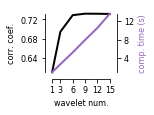

In [145]:
fig_comp_ressource, ax = figure(figsize=(.17,.12))
ax.plot(WAVELET_NUM, CROSS_CORRELS, color='k', lw=2)
ax2 = ax.twinx()
ax2.plot(WAVELET_NUM, COMP_TIME, color=Purple, lw=2)
set_plot(ax2, ['right'], xticks=WAVELET_NUM)
set_plot(ax, ['left', 'bottom'], ylabel='corr. coef.',
         xticks=WAVELET_NUM, xlabel='wavelet num.')
ax2.set_ylabel('comp. time (s)', color=Purple, fontsize=FONTSIZE)

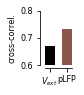

In [150]:
bottom=.6
fig_Vext_pLFP, ax = figure(figsize=(.08,.1))
ax.bar([0], [np.abs(np.corrcoef(data_awake['new_Vm'], data_awake['new_Extra']))[0,1]-bottom],
       bottom=bottom,width=.6, color='k')
ax.bar([1], [np.abs(np.corrcoef(data_awake['new_Vm'], data_awake['pLFP']))[0,1]-bottom],
       bottom=bottom, width=.6, color=Brown)
set_plot(ax, xticks=[0,1], xticks_labels=['$V_{ext}$', 'pLFP'], ylabel='cross-correl.', yticks=[.6,.7,.8])

In [155]:
from graphs.plot_export import put_list_of_figs_to_svg_fig
put_list_of_figs_to_svg_fig([fig_optimum, fig_comp_ressource, fig_Vext_pLFP,fig_with_pLFP],
                            fig_name='paper/Figures/Fig_pLFP_Comput.svg',
                            figsize=(0.5,0.2),
                            Props={'XCOORD':[0,200,340,10],
                                   'YCOORD':[10, 10, 130, 130],
                                   'LABELS':['a','b','d','c']},
                            visualize=True)

In [23]:
"""
Loading a sample datafile for the anesthetized
"""
from data_analysis.IO.load_data import load_file
data = load_file(home+'DATA/Data_Ste_Zucca/2017_04_04/14_40_12_CCLAMP-WITH-CORTEX-EXTRA.h5')
cond = (data['t']>300) & (data['t']<400)
data_anesth={'t':data['t'][cond], 'Vm':data['Vm'][cond], 'Extra':data['ExtraCort'][cond]}
data_anesth['dt'] = data_anesth['t'][1]-data_anesth['t'][0]

In [597]:
from data_analysis.processing.signanalysis import gaussian_smoothing

def preprocess_LFP(data,
                   freqs = np.linspace(50, 300, 5),
                   new_dt = 5e-3, smoothing=20e-3, pLFP_unit='$\mu$V'):
    """
    performs continuous wavelet transform
    """
    data['W'] = my_cwt(data['Extra'], freqs, data['dt'])
    data['pLFP_freqs'] = freqs
    W2 = np.abs(data['W']).mean(axis=0)
    isubsmpl = int(round(new_dt/data['dt']))
    data['pLFP'] = gaussian_smoothing(\
                                      np.reshape(W2[:int(len(W2)/isubsmpl)*isubsmpl],
                                                 (int(len(W2)/isubsmpl),isubsmpl)).mean(axis=1),
                                      int(smoothing/new_dt))
    
    data['pLFP_unit']=pLFP_unit
    if pLFP_unit=='$\mu$V':
        data['pLFP'] *= 1e3
        
    data['new_t'] = np.arange(len(data['pLFP']))*new_dt+data['t'][0]
    data['new_dt'] = new_dt
    
#preprocess_LFP(data_anesth)
preprocess_LFP(data_awake)        

In [373]:
def plot_three_quant(data, tstart=-np.inf, tend=np.inf):
    cond = (data['t']>tstart) & (data['t']<tend)
    fig, AX = figure(axes=(3,1),figsize=(1.6,.4), hspace=.01)
    plot(data['t'][cond], data['Extra'][cond], ax=AX[0][0],
         axes_args={'ylabel':'$V_{ext}$ (mV)',
                    'xlim':[data['t'][cond][0], data['t'][cond][-1]], 'spines':['left']});
    plot(data['t'][cond], data['Vm'][cond], ax=AX[1][0],
         axes_args={'xlabel':'time (s)', 'ylabel':'$V_m$ (mV)',
                    'xlim':[data['t'][cond][0], data['t'][cond][-1]], 'spines':['left']});
    cond = (data['new_t']>tstart) & (data['new_t']<tend)
    plot(data['new_t'][cond], data['pLFP'][cond], ax=AX[2][0],
         axes_args={'xlabel':'time (s)', 'ylabel':'pLFP ('+data['pLFP_unit']+')',
                    'xlim':[data['new_t'][cond][0], data['new_t'][cond][-1]]}, c=Red);

In [375]:
plot_three_quant(data_anesth)

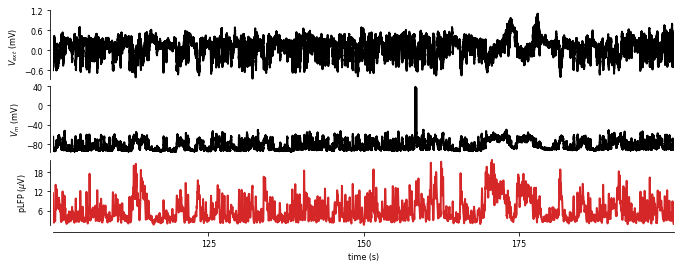

In [376]:
plot_three_quant(data_awake)

## Finding the level of ~quiescent activity

In [377]:
from graphs.my_graph import *
from scipy.integrate import cumtrapz

def get_max_of_hist(data, nbins=300, smoothing=2):
    """
    maybe need to get more complex to identify the first maximum
    (e.g. Up and Down states case) 
    """
    binsize = (data['pLFP'].max()-data['pLFP'].min())/nbins
    Hist, be = np.histogram(data['pLFP'],
                            bins=np.concatenate([
                                np.arange(-2*smoothing,0)*binsize+data['pLFP'].min(),
                                np.arange(nbins)*binsize+data['pLFP'].min(),
                                np.arange(0,2*smoothing)*binsize+data['pLFP'].max()
                            ]), normed=True)
    i0 = np.argmax(gaussian_smoothing(Hist,smoothing))
    data['max_of_hist']=be[i0+1]
    data['noise_estimate']=np.std(data['pLFP'][data['pLFP']<data['max_of_hist']])
    data['hist_amp']=Hist[i0]
    return {'max_of_hist':be[i0],
            'noise_estimate':be[i0]-data['pLFP'].min(),
            'hist_amp':Hist[i0]}

get_max_of_hist(data_awake)

{'hist_amp': 0.2362921240957489,
 'max_of_hist': 3.2418137739307555,
 'noise_estimate': 1.6929045034017143}

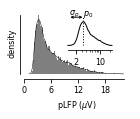

In [378]:
from graphs.my_graph import *
def show_histogram_of_pLFP(data, nbins=300, smoothing=2, XLIM=[3,24]):
    fig, ax = figure(figsize=(.19,.12), left=.4, bottom=1, right=1.1)
    hist(data['pLFP'], ax=ax, bins=nbins, normed=True, lw=0, facecolor=Grey)
    binsize = (data['pLFP'].max()-data['pLFP'].min())/nbins
    Hist, be = np.histogram(data['pLFP'],
                                     bins=np.concatenate([
                                         np.arange(-2*smoothing,0)*binsize+data['pLFP'].min(),
                                         np.arange(nbins)*binsize+data['pLFP'].min(),
                                         np.arange(0,2*smoothing)*binsize+data['pLFP'].max()
                                     ]), normed=True)
    result = get_max_of_hist(data, nbins=nbins, smoothing=smoothing)
    set_plot(ax, yticks=[],ylabel='density',
             xlabel='pLFP ('+data['pLFP_unit']+')')
    plot(.5*(be[1:]+be[:-1]), gaussian_smoothing(Hist,smoothing), ax=ax, lw=.5,
         axes_args={'yticks':[], 'ylabel':'density',
                    'xlabel':'pLFP ('+data['pLFP_unit']+')'})
    ax1 = plt.axes([0.5,0.6,0.42,0.32])
    ax1.plot(.5*(be[1:]+be[:-1]), gaussian_smoothing(Hist,smoothing), 'k-', lw=1)
    ax1.plot(result['max_of_hist']*np.ones(2), [0,1.1*result['hist_amp']], 'k:', lw=1)
    ax1.set_xscale('log')
    ax1.annotate(s='',
                 xy=(1.1*result['max_of_hist'],1.1*result['hist_amp']),
                 xytext=(result['max_of_hist']-1.2*result['noise_estimate'],1.1*result['hist_amp']),
                 arrowprops=dict(arrowstyle='<->, head_width=.1, head_length=0.2'))
    ax1.annotate('$p_0$', (result['max_of_hist'],1.18*result['hist_amp']), fontsize=FONTSIZE)
    ax1.annotate('$\sigma_p$', (result['max_of_hist']-2,1.18*result['hist_amp']), fontsize=FONTSIZE)
    set_plot(ax1,['bottom'],xlim=XLIM)
    set_plot(ax1,['bottom'],xlim=XLIM, yticks=[],xticks=[1,5], xticks_labels=['2','10'])
    # ax.legend(frameon=False, prop={'size':'x-small'})
    return fig

fig_hist = show_histogram_of_pLFP(data_awake, smoothing=3, XLIM=[1,24])
#fig_hist.savefig(desktop+'fig.png', dpi=300)
fig_hist.savefig(desktop+'fig.svg')

### Computing low-frequency fluctuations

In [379]:
def compute_low_freqs_var(data, freqs = np.logspace(np.log(1.)/np.log(10), 1, 40)):
    data['low_freqs'] = freqs
    data['W_low_freqs'] = my_cwt(data['pLFP'], freqs, data['new_dt'])    

#compute_low_freqs_var(data_anesth)    
compute_low_freqs_var(data_awake, freqs = np.linspace(1, 9, 40) )   

In [382]:
def compute_low_freqs_var(data, freqs = np.logspace(np.log(1.)/np.log(10), 1, 40)):
    data['low_freqs'] = freqs
    data['W_low_freqs'] = my_cwt(data['pLFP'], freqs, data['new_dt'])    

#compute_low_freqs_var(data_anesth)    
compute_low_freqs_var(data_awake, freqs = np.linspace(1, 9, 40) )   

def show_raw_data_large_scale(data,
                              Zooms=[],
                              Tbar=5, Tshift=0,
                              tstart=-np.inf, tend=np.inf):
    fig, AX = figure(axes=(2,1), figsize=(0.8,.1), hspace=0.01, left=.12, bottom=0.01, right=.999)
    cond = (data['t']>tstart) & (data['t']<tend)
    AX[0][0].plot(data['t'][cond][::100], data['Vm'][cond][::100], 'k-', lw=1)
    tstart = data['t'][cond][0]
    cond0 = (data['new_t']>tstart) & (data['new_t']<tend)
    AX[1][0].plot(data['new_t'][cond0], data['pLFP'][cond0], 'k-', lw=1, color=Brown)
    y20, y21 = AX[1][0].get_ylim()
    y10, y11 = AX[0][0].get_ylim()
    AX[1][0].annotate(str(Tbar)+'s', (tstart+Tbar, y20), fontsize=FONTSIZE)
    AX[1][0].plot([tstart,tstart+Tbar], y20*np.ones(2), 'k-', lw=1)
    for i, (z1, z2) in enumerate(Zooms):
        # AX[1][0].plot([z1, z2], y20*np.ones(2), '-', color=Grey)
        AX[1][0].annotate('('+str(i+1)+')', (z1, y21), color=Grey, fontsize=FONTSIZE)
        AX[1][0].fill_between([z1, z2], y20*np.ones(2), y21*np.ones(2), color='k', alpha=.1, lw=0)
        AX[0][0].fill_between([z1, z2], y10*np.ones(2), y11*np.ones(2), color='k', alpha=.1, lw=0)
    set_plot(AX[0][0], [],xlim=[data['t'][cond][0],data['t'][cond][-1]],
             ylabel='$V_m$')
    set_plot(AX[1][0], [],xlim=[data['new_t'][cond0][0],data['new_t'][cond0][-1]],
             ylabel='pLFP')
    return fig

def show_raw_LFP_and_pLFP(data, Zooms, pLFP_lim=[0,50],
                          Tbar=0.5, Tshift=.2, Tspace=.2, Vm_annot=-60.,
                          hspace=3., Alim=[0,20]):
    fig, AX = figure(axes_extents=[[[1,1]], [[1,1]], [[1,2]]],
                     figsize=(0.8,.2), hspace=.2, left=.35, bottom=.01, right=.95)
    tt=0
    for i, (z1, z2) in enumerate(Zooms):
        # AX[0][0].plot([tt, tt+z2-z1], Vm_annot*np.ones(2), '-', color=Grey, lw=.2)
        AX[0][0].annotate('('+str(i+1)+')', (tt, Vm_annot), color=Grey, fontsize=FONTSIZE)
        cond = (data['t']>z1) & (data['t']<z2)
        AX[0][0].plot(data['t'][cond][::4]-z1+tt, data['Vm'][cond][::4], 'k-', lw=1)
        cond = (data['new_t']>z1) & (data['new_t']<z2)
        AX[1][0].plot(data['new_t'][cond]-z1+tt, data['pLFP'][cond], '-', lw=1, color=Brown)
        c = AX[2][0].contourf(data['new_t'][cond]-z1+tt,
                              data['low_freqs'], np.abs(data['W_low_freqs'][:,cond]),
                              cmap=colormap, vmin=Alim[0], vmax=Alim[1])
        tt+=z2-z1+Tspace
    set_plot(AX[0][0], ['left'],xlim=[0, tt-Tspace], ylabel='$V_{m}$ (mV)')
    AX[1][0].plot([0, tt-Tspace],np.ones(2)*data['max_of_hist'], ':',c=Brown,lw=1)
    AX[1][0].annotate(str(int(1e3*Tbar))+'ms', (Tbar, pLFP_lim[1]), fontsize=FONTSIZE)
    AX[1][0].plot([Tbar, 2*Tbar], pLFP_lim[1]*np.ones(2), 'k-', lw=1)
    set_plot(AX[1][0], ['left'],xlim=[0, tt-Tspace],
             ylabel='pLFP ('+data['pLFP_unit']+')', ylim=pLFP_lim)
    # AX[2][0].set_yscale('log')
    set_plot(AX[2][0], ['left'], yticks=[2, 5, 8],
             ylabel='freq. (Hz)')
    acb = plt.axes([.92, .05, .01, .4])
    cb = build_bar_legend(np.round(np.linspace(*Alim, 7),0), acb, colormap,
                          label='pLFP amp. ($\mu$V)', color_discretization=30)
    return fig

Zooms=[x+np.arange(2)*2 for x in [129.7, 197.8, 115.5, 128, 189.6, 174.6]]
#Zooms=[x+np.arange(2)*2 for x in [198, 115.5, 128, 189.6, 174.6]]
fig_zoom = show_raw_LFP_and_pLFP(data_awake, Zooms, pLFP_lim=[0,20], Tshift=-4, Tspace=.25, Alim=[0,4.2])
fig_zoom.savefig(desktop+'fig.png', dpi=300)

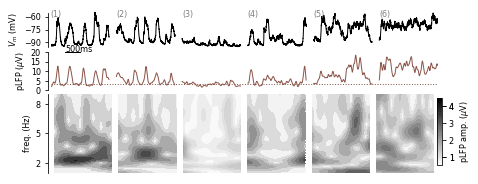

In [383]:
Zooms=[x+np.arange(2)*2 for x in [129.7, 197.8, 115.5, 128, 189.6, 174.6]]
#Zooms=[x+np.arange(2)*2 for x in [198, 115.5, 128, 189.6, 174.6]]
fig_zoom = show_raw_LFP_and_pLFP(data_awake, Zooms, pLFP_lim=[0,20], Tshift=-4, Tspace=.25, Alim=[0,4.2])
fig_zoom.savefig(desktop+'fig.png', dpi=300)

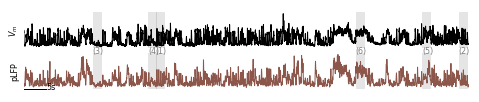

In [384]:
fig_full = show_raw_data_large_scale(data_awake, Zooms=Zooms, Tshift=-5)
#fig_full.savefig(desktop+'fig.png', dpi=300)

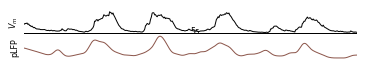

In [340]:
t0, length = 198, 2
fig_full = show_raw_data_large_scale(data_awake, tstart=t0, tend=t0+length, Zooms=[], Tshift=-5)

In [406]:
from graphs.plot_export import put_list_of_figs_to_svg_fig
put_list_of_figs_to_svg_fig([fig_full, fig_zoom],
                            fig_name='paper/Figures/Fig_Various_States.svg',
                            figsize=(0.6,0.23),
                            Props={'XCOORD':[10,0],
                                   'YCOORD':[-5,85],
                                   'XCOORD_LABELS':[-10, -10],
                                   'YCOORD_LABELS':[0, 80],
                                   'LABELS':['a','b']},
                            visualize=True)

## The cortical activation index

In [385]:
def compute_CAI(data, threshold_factor=2., band=[1,5], smoothing=100e-3, window=300e-3):
    print(data['noise_estimate'])
    threshold = threshold_factor*data['noise_estimate']
    freqs_cond = (data['low_freqs']>=band[0]) & (data['low_freqs']<=band[1])
    low_freq_pow = gaussian_smoothing(np.max(np.abs(data['W_low_freqs'])[freqs_cond, :], axis=0), int(smoothing/data['new_dt']))
    mean_pLFP = gaussian_smoothing(\
                          np.abs(data['pLFP']-data['max_of_hist']),
                          int(smoothing/data['new_dt']))
    iwindow = int(window/data['new_dt'])
    print(iwindow)
    CAI = np.zeros(len(data['new_t']))
    for i in range(len(data['new_t'])):
        p_mean = np.mean(low_freq_pow[np.max([i-iwindow, 0]):np.min([i+iwindow, len(data['new_t'])])])
        if p_mean>threshold:
           CAI[i] = -p_mean 
        else:
           CAI[i] = mean_pLFP[i]
    # low_freq_cond = (low_freq_pow>threshold)
    # CAI[low_freq_cond] = -gaussian_smoothing(low_freq_pow, int(smoothing/data['new_dt']))[low_freq_cond]
    # CAI[np.invert(low_freq_cond)] = gaussian_smoothing(\
    #                       np.abs(data['pLFP']-data['max_of_hist']),
    #                       int(smoothing/data['new_dt']))[np.invert(low_freq_cond)]
    data['CAI'] = CAI/data['noise_estimate']

compute_CAI(data_awake)

0.3590884435508372
60


0.3590884435508372
60


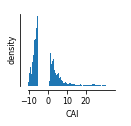

In [386]:
compute_CAI(data_awake, threshold_factor=5.)
fig_hist, ax = figure()
ax.hist(data_awake['CAI'], bins=200, normed=True);
set_plot(ax, ylabel='density', xlabel='CAI', xticks=-10+np.arange(4)*10, yticks=[])
fig_hist.savefig(desktop+'hist.svg')

0.3590884435508372
60


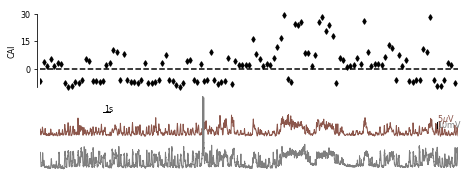

In [387]:
t0, width = 135, 60
spikes=-30
vm_color=Grey
pLFP_color=Brown
Vm_bar = 10
pLFP_bar=5
T_bar=1.
pLFP_loc=-45

def plot_CAI():
    cond = (data_awake['new_t']>t0) & (data_awake['new_t']<t0+width)
    # fig_with_pLFP, AX = figure(axes=(2,1), figsize=(.5,.15), left=.01, bottom=.1)
    fig_with_pLFP, AX = figure(axes=(2,1), figsize=(.8,.2), bottom=.01, left=.3, hspace=0.01)
    ax = AX[1][0]
    ax.plot(data_awake['new_t'][cond],
            data_awake['pLFP'][cond].mean()+data_awake['pLFP'][cond]/pLFP_bar*Vm_bar+pLFP_loc,
            '-', lw=1, color=pLFP_color)
    cond = cond & (data_awake['new_Vm']<spikes)
    ax.plot(data_awake['new_t'][cond], data_awake['new_Vm'][cond], '-', color=vm_color, lw=1)
    cond0 = (data_awake['t']>t0) & (data_awake['t']<t0+width)
    i0 = np.argwhere((data_awake['Vm'][cond0][1:]>spikes) & (data_awake['Vm'][cond0][:-1]<=spikes)).flatten()
    for ii in i0:
        ax.plot(data_awake['t'][cond0][ii-100:ii+100], data_awake['Vm'][cond0][ii-100:ii+100], '-', color=vm_color, lw=1)
    # Tbar
    ax.plot([data_awake['new_t'][cond][0]+T_bar+8, data_awake['new_t'][cond][0]+2*T_bar+8], [10, 10], 'k-', lw=1)
    ax.annotate(str(int(T_bar))+'s', (data_awake['new_t'][cond][0]+T_bar+8+.2, 11), fontsize=FONTSIZE)
    # Vm-LFP bar
    ax.plot([data_awake['new_t'][cond][-1]-3*T_bar, data_awake['new_t'][cond][-1]-3*T_bar],
                          [pLFP_loc/5, pLFP_loc/5-Vm_bar], 'k-', lw=1)
    ax.annotate(str(int(Vm_bar))+'mV', (data_awake['new_t'][cond][-1]-3*T_bar, pLFP_loc/5-Vm_bar), fontsize=FONTSIZE, color=vm_color)
    ax.annotate(str(int(pLFP_bar))+'$\mu$V', (data_awake['new_t'][cond][-1]-3*T_bar, pLFP_loc/5),
                fontsize=FONTSIZE, color=pLFP_color)
    set_plot(ax, [], xlim=[data_awake['new_t'][cond][0], data_awake['new_t'][cond][-1]], yticks=[])
    AX[0][0].plot(data_awake['new_t'][cond][::100], data_awake['CAI'][cond][::100], 'kd', ms=4)
    AX[0][0].plot([data_awake['new_t'][cond][0],data_awake['new_t'][cond][-1]],
                          np.zeros(2), 'k--')
    set_plot(AX[0][0], ['left'], xlim=[data_awake['new_t'][cond][0], data_awake['new_t'][cond][-1]],
                          ylabel='CAI')
    return fig_with_pLFP

compute_CAI(data_awake, threshold_factor=5.8)
fig_with_pLFP = plot_CAI()
#fig_with_pLFP.savefig(desktop+'raw.svg')

# Designing the Real-Time analysis of network states based on the LFP

In [354]:
#######################################################################
## Exporting a sample LFP datafile for the Real-Time troubleshooting ##
#######################################################################
from data_analysis.IO.load_data import load_file
data = load_file('../sparse_vs_balanced/sparse_vs_balanced/data/Wild_Type/Cell14/17o27001.abf')
t, Vm, Extra = data[0], data[1][1], data[1][0]
dt = t[1]-t[0]
new_dt = 5e-4 # 10kHz sampling
idt = int(new_dt/dt)
print(idt)
# cond = (t>120) & (t<200)
cond = (t>160) & (t<170)
Signal = 1e-3*Extra[cond][::idt] # subsampling and in V
#np.savetxt('/Users/yzerlaut/DATA/Awake_LFP_sample.dat', Signal, fmt='%.7e')

10


In [355]:
# let's write a nasty loop version of the wavelet transform

freq = 200. # Hz
w0 = 6.
Tmax = 2**.5 * (w0/(np.pi*freq))
N_length_wvlt = int(2*Tmax/new_dt)
Slow_Time_Scale = 20e-3
ist = int(Slow_Time_Scale/new_dt)

def new_Morlet_Wavelet_TF(real, imag, X, it, f, new_dt, N):
    n = (w0/2./np.sqrt(2.*np.pi)/f)*(1.+np.exp(-w0**2./2.))
    wv = np.exp(-0.5 * (((2.*np.pi*f*(it-N/2)*new_dt)/w0) ** 2))
    real += X*wv*np.cos(2. * np.pi * f * (it-N/2) * new_dt)/n*new_dt
    imag += -X*wv*np.sin(2. * np.pi * f * (it-N/2) * new_dt)/n*new_dt
    return real, imag
    
# LFP_vector = np.zeros(N_length_wvlt)
LFP_vector = np.zeros(1000)
WT = 0*Signal

mean_LFP_last, mean_pLFP = 0, 0
TT, PLFP = [], []
for i in np.arange(len(Signal)):
    wvlt_tf, mean_LFP_new = 0, 0
    real, imag = 0, 0
    for j in np.arange(N_length_wvlt-1,0,-1):
        LFP_vector[j] = LFP_vector[j-1]
        real, imag = new_Morlet_Wavelet_TF(real, imag,
                                           LFP_vector[j]-mean_LFP_last,
                                           j, freq, new_dt, N_length_wvlt)
        mean_LFP_new += LFP_vector[j]/N_length_wvlt
        
    LFP_vector[0] = Signal[i] # and we take the last recorded value
    mean_LFP_last = mean_LFP_new    
    # # we store its norm
    WT[i] = np.sqrt(real**2+imag**2)
    mean_pLFP += WT[i]/ist
    if (i%ist==0):
        PLFP.append(mean_pLFP)
        TT.append(i)
        mean_pLFP = 0

In [347]:
freq = 200. # Hz
w0 = 6.
Tmax = 2**.5 * (w0/(np.pi*freq))
N_length_wvlt = int(2*Tmax/new_dt)
print(N_length_wvlt)

270


In [356]:
coefs = my_cwt(Signal, [freq], new_dt)
amp = np.abs(coefs)

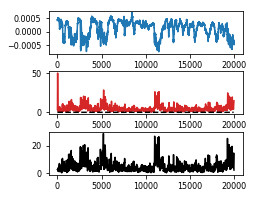

In [357]:
fig, AX = figure(axes=(3,1), figsize=(.5,.3))
AX[0][0].plot(Signal);
AX[1][0].plot(1e6*gaussian_smoothing(WT, 5), color=Red);
AX[1][0].plot(TT, 1e3*np.array(PLFP), 'k--')
AX[2][0].plot(1e6*gaussian_smoothing(amp[0,:], 5), color='k');

In [20]:

def show_Vm_pLFP_spectrogram(data, tstart=-np.inf, tend=np.inf):
    fig, AX = figure(axes_extents=[[[1,1]],[[1,1]],[[1,2]],[[1,2]]],figsize=(0.6,.6), hspace=0.01)
    cond = (data['t']>tstart) & (data['t']<tend)
    plot(data['t'][cond], data['Vm'][cond], ax=AX[0][0], lw=1,
         axes_args={'spines':['left'],'xlim':[data['t'][cond][0],data['t'][cond][-1]], 'ylabel':'$V_m$ (mV)'})
    cond = (data['new_t']>tstart) & (data['new_t']<tend)
    ax=AX[1][0].plot(data['new_t'][cond], data['new_t'][cond]*0+data['max_of_hist'], 'k:', lw=0.5)
    plot(data['new_t'][cond], data['pLFP'][cond], ax=AX[1][0], c=Brown, lw=1,
         axes_args={'spines':['left'],'xlim':[data['new_t'][cond][0],data['new_t'][cond][-1]],
                    'ylabel':'pLFP ('+data['pLFP_unit']+')'})
    c = AX[2][0].contourf(data['new_t'][cond], data['low_freqs'], np.abs(data['W_low_freqs'][:,cond]),
                          cmap=colormap)
    AX[2][0].set_yscale('log')
    set_plot(AX[2][0], ['left'], yticks=[0.1, 0.2, 0.5, 1, 2, 5, 10], ylim=[0.1, 10],
             yticks_labels=['', '0.2', '0.5', '1', '2', '5', ''], ylabel='freq. (Hz)')
    c = AX[3][0].contourf(data['new_t'][cond], data['low_freqs'], np.angle(data['W_low_freqs'][:,cond]), cmap='PRGn')
    AX[3][0].set_yscale('log')
    set_plot(AX[3][0], yticks=[0.1, 0.2, 0.5, 1, 2, 5, 10], ylim=[0.1, 10],
             yticks_labels=['', '0.2', '0.5', '1', '2', '5', ''], ylabel='freq. (Hz)')


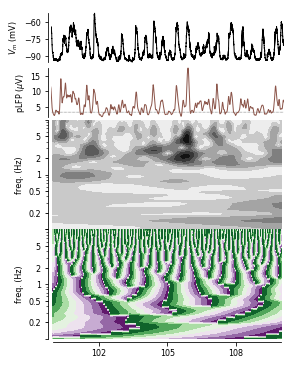

In [22]:
show_Vm_pLFP_spectrogram(data_awake, tstart=50, tend=110)
#show_Vm_pLFP_spectrogram(data_awake)

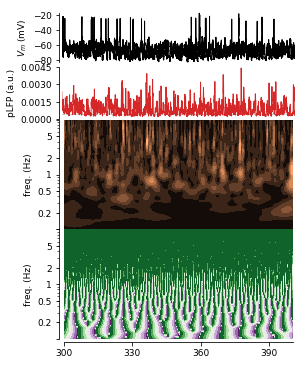

In [459]:
show_Vm_pLFP_spectrogram(data_anesth)

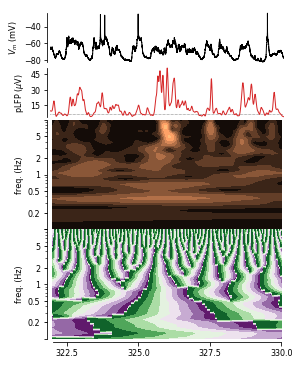

In [39]:
show_Vm_pLFP_spectrogram(data_anesth, tstart=322, tend=330)

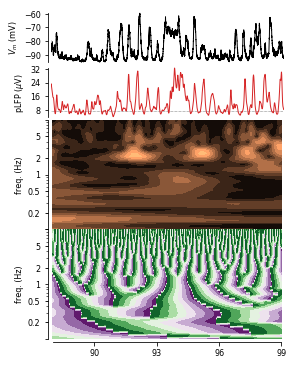

In [40]:
show_Vm_pLFP_spectrogram(data_awake, tstart=88, tend=99)

## Finding the level of ~quiescent activity

Idea: we look for the strongly oscillating samples and we take the
level found in the down phase of those

In [63]:
from graphs.my_graph import *
from scipy.integrate import cumtrapz

def compute_threshold_for_highly_oscill_act(data, threshold=0.95):
    hist, bins = np.histogram(np.abs(data['W_low_freqs']).mean(axis=0), 1000, normed=True)
    return bins[1:][np.argmin((cumtrapz(hist, bins[1:])-threshold)**2)]

def plot_histogram_of_low_freq_power(data, threshold=0.99):
    CUMPROD, BINS = [], []
    for i in range(len(data['low_freqs'])):
        hist, bins = np.histogram(np.abs(data['W_low_freqs'][i,:]), 100, normed=True)
        CUMPROD.append(cumtrapz(hist, bins[1:]))
        BINS.append(bins[2:])
    # plot(X=BINS, Y=CUMPROD, ax=plt.gca(), lw=1, bar_legend_args={}, bar_label='freq')
    plot(X=BINS, Y=CUMPROD, ax=plt.gca(), lw=1)
    hist, bins = np.histogram(np.abs(data['W_low_freqs']).mean(axis=0), 10000, normed=True)
    plot(bins[2:], cumtrapz(hist, bins[1:]), ax=plt.gca(), c='k', lw=3)
    thresh = compute_threshold_for_highly_oscill_act(data, threshold=threshold)
    plt.plot([0, thresh, thresh], [threshold, threshold, 0], 'k--')

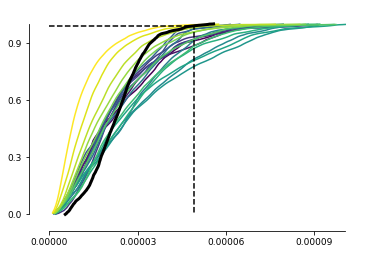

In [64]:
plot_histogram_of_low_freq_power(data_awake)

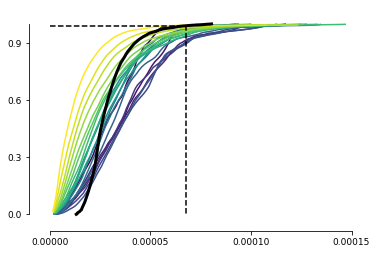

In [65]:
plot_histogram_of_low_freq_power(data_anesth)

In [622]:
def find_times_of_low_phase(data, power_threshold=0.99, phase_extent=np.pi/12):

    pow_thresh = data['max_of_hist'] #compute_threshold_for_highly_oscill_act(data, threshold=power_threshold)
    times, indices = [], []
    for i in range(len(data['new_t'])):
        # find freq of max power
        i0 = np.argmax(np.abs(data['W_low_freqs'][:,i]))
        # if np.abs(np.angle(data['W_low_freqs'][i0,i]))>np.pi/2.:
        cond = (np.abs(np.angle(data['W_low_freqs'][i0,i]))<phase_extent) and\
            (np.abs(data['W_low_freqs'][i0,i])>pow_thresh)
        if cond:
            indices.append(i)
            times.append(data['new_t'][i])
    data['ind_low_phase'] = indices
    data['times_low_phase'] = times

find_times_of_low_phase(data_anesth)
find_times_of_low_phase(data_awake)

In [623]:
def comparison_plot(data):
    figure()
    plt.bar([0], np.mean(data['pLFP']), yerr=np.std(data['pLFP']), color='grey')
    plt.bar([1], np.mean(data['pLFP'][data['ind_low_phase']]),\
            yerr=np.std(data['pLFP'][data['ind_low_phase']]), color=Brown)

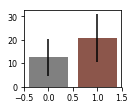

In [624]:
find_times_of_low_phase(data_anesth, phase_extent=np.pi/100., power_threshold=0.99)
comparison_plot(data_anesth)

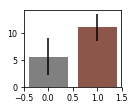

In [625]:
find_times_of_low_phase(data_awake, phase_extent=np.pi/1000., power_threshold=0.9999)
comparison_plot(data_awake)

In [626]:
def see_low_times_of_low_phase_with_Vm(data, zoom=[-np.inf, np.inf]):
    fig, ax = figure(figsize=(1,.3))[1][0][0]
    cond = (data['t']>zoom[0]) & (data['t']<zoom[1])
    plot(data['t'][cond][::10], data['Vm'][cond][::10], lw=1, ax=ax)
    cond = (data['new_t'][data['ind_low_phase']]>zoom[0]) & (data['new_t'][data['ind_low_phase']]<zoom[1])
    scatter(data['new_t'][data['ind_low_phase']][cond],\
            -80.*np.ones(len(np.array(data['ind_low_phase'])[cond])), color=Red, ax=ax)

TypeError: 'AxesSubplot' object does not support indexing

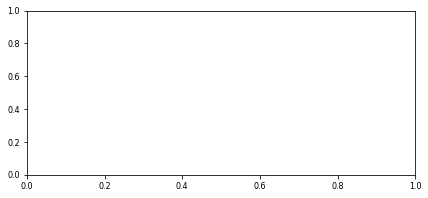

TypeError: 'AxesSubplot' object does not support indexing

In [627]:
see_low_times_of_low_phase_with_Vm(data_anesth, zoom=[320, 340])

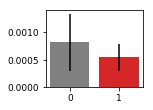

In [458]:
find_times_of_low_phase(data_anesth)
comparison_plot(data_anesth)

In [252]:
power_bins = np.digitize(np.abs(W).mean(axis=0), 100)

In [1]:
hist(np.abs(W).mean(axis=0))

In [206]:
freqs

array([  0.1       ,   0.1274275 ,   0.16237767,   0.20691381,
         0.26366509,   0.33598183,   0.42813324,   0.54555948,
         0.6951928 ,   0.88586679,   1.12883789,   1.43844989,
         1.83298071,   2.33572147,   2.97635144,   3.79269019,
         4.83293024,   6.15848211,   7.8475997 ,  10.        ])

(<matplotlib.figure.Figure at 0x1a119f3e10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a9d280dd8>)

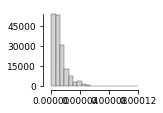

In [204]:
hist(np.abs(W[-1,:]))

(<matplotlib.figure.Figure at 0x1a1047fa90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1042b898>)

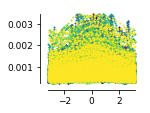

In [200]:
scatter(X=np.angle(W), Y=[data_awake['hGamma_Act'] for i in range(len(W))], ms=1)

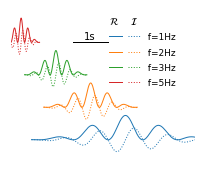

In [303]:
# ewrwkejr
def Custom_Wavelet(t, f, w0=6.):
    x = 2*np.pi*f*t
    output = np.exp(1j * x)
    output = (np.exp(1j * x)+1)/2.*np.exp(-0.5 * ((x/w0) ** 2)) * np.pi ** (-0.25)
    # return (np.real(output)+.5)/2. # note the minus sign to have the 0 phase at bottom
    # return np.real(output)**2 # note the minus sign to have the 0 phase at bottom
    return output # note the minus sign to have the 0 phase at bottom

def Custom_Wavelet_Decay(f, w0=6.):
    return 2 ** .5 * (w0/(np.pi*f))

def from_fourier_to_morlet(freq):
    x = np.linspace(0.1/freq, 2.*freq, 1e3)
    return x[np.argmin((x-freq*(1-np.exp(-freq*x)))**2)]
    
def get_Custom_of_right_size(f, dt, w0=6, with_t=False):
    Tmax = Custom_Wavelet_Decay(f, w0=w0)
    t = np.arange(-int(Tmax/dt), int(Tmax/dt))*dt
    if with_t:
        return t, Custom_Wavelet(t, f, w0=w0)
    else:
        return Custom_Wavelet(t, f, w0=w0)

fig, ax = figure(figsize=(.32,.2), bottom=0.02, left=0.02)     
for i, f in enumerate([1., 2,  3., 5.]):
    t, wvl = get_Custom_of_right_size(f, 0.01, with_t=True)
    plot(t-i, i+np.real(wvl),
         c='C'+str(i), ax=ax, lw=1,
         label='  f='+str(int(f))+'Hz')
    plot(t-i, i+np.imag(wvl), c='C'+str(i), ls=':',
         ax=ax, lw=1,label=' ')
# ax.legend(frameon=False, loc=1)
ax.plot([-1.5,-.5], [3., 3.], 'k-', lw=1)
ax.annotate('1s', (-1.2, 3.1))    
ax.grid('on')
set_plot(plt.gca(), [], ylim=[-1,4], xlim=[-i-.3,2])

LABELS = [ax.lines[i].get_label() for i in range(len(ax.lines))]
leg = plt.legend(ax.lines[0:-1:2]+ax.lines[1::2], LABELS[1:-1:2]+LABELS[::2],
                 loc=(.5,.5), frameon=False,
             title=r'$\mathcal{R}$    $\mathcal{I}$            ',  
             ncol=2, numpoints=3, handletextpad=-0.2, labelspacing=0.7, columnspacing=0.001)
#save_on_desktop(fig, figname='fig.png')

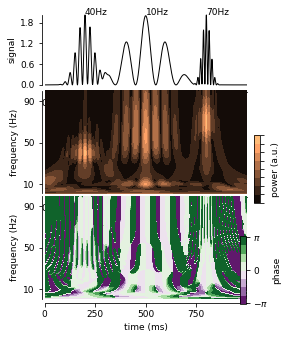

In [315]:
from scipy import signal
def my_custom_transform(data, frequencies, dt):
    
    output = np.zeros([len(frequencies), len(data)], dtype=np.complex)

    for ind, freq in enumerate(frequencies):
        # wavelet_data = np.conj(get_Custom_of_right_size(freq, dt))
        wavelet_data = get_Custom_of_right_size(freq, dt)
        # the wavelets have different integrals
        # conv_number compensates for the number of summed points (i.e. also integral of wavelet)
        conv_number = signal.convolve(np.ones(len(data))+0.*1j, np.ones(len(wavelet_data)),
                                      mode='same')
        # the sliding mean that depends on the frequency
        sliding_mean = signal.convolve(data+0.*1j, np.ones(len(wavelet_data)),
                                       mode='same')/conv_number
        # the final convolution
        output[ind, :] = signal.convolve(data-sliding_mean+0.*1j, wavelet_data,
                                         mode='same')/conv_number
    return output
    
def illustration_plot(t, freqs, data,
                      coefs, phase, dt,
                      tstop, freq1, freq2, freq3,
                      phase_colormap='PRGn',
                      power_colormap=copper):
    """
    a plot to illustrate the output of the wavelet analysis
    """
    fig, AX = figure(figsize=(0.46,0.4),
                     hspace=0.05, wspace=0.01, bottom=0.35, right=.9, left=.43,
                     axes_extents=[[[1,3]],[[1,4]], [[1,4]]])
    # signal plot
    plot(1e3*t, data, c='k', lw=1, ax=AX[0][0],\
         axes_args={'ylabel':'signal', 'xlim':[1e3*t[0], 1e3*t[-1]]})
    for f, tt in zip([freq2, freq1, freq3], [200,500,800]):
        AX[0][0].annotate(str(int(f))+'Hz', (tt, data.max()), fontsize=FONTSIZE)

    # time frequency power plot
    c = AX[1][0].contourf(1e3*t, freqs, coefs, cmap=copper)
    set_plot(AX[1][0], xlim=[1e3*t[0], 1e3*t[-1]],
             ylabel='frequency (Hz)', yticks=[10, 50, 90])
    # inset with legend
    acb = plt.axes([.9, .4, .02, .2])
    cb = plt.colorbar(c, cax=acb, label='power (a.u.)')
    cb.set_ticklabels([])

    # time frequency phase plot
    c = AX[2][0].contourf(1e3*t, freqs, phase, cmap=phase_colormap)
    set_plot(AX[2][0], xlim=[1e3*t[0], 1e3*t[-1]],
             ylabel='frequency (Hz)', yticks=[10, 50, 90],
             xlabel='time (ms)')
    # inset with legend
    acb = plt.axes([.85, .1, .02, .2])
    cb = plt.colorbar(c, cax=acb, label='phase')
    cb.set_ticks([-np.pi, 0, np.pi])
    cb.set_ticklabels(['$-\pi$', '0', '$\pi$'])
    return fig

noise_level = 0.
nfreq = 100

# temporal sampling
dt, tstop = 1e-4, 1.
t = np.arange(int(tstop/dt))*dt

# ### artificially generated signal, transient oscillations
freq1, width1, freq2, width2, freq3, width3 = 10., 100e-3, 40., 40e-3, 70., 20e-3
data  = (1+np.cos(2*np.pi*freq1*t))*np.exp(-(t-.5)**2/2./width1**2)+\
        (1+np.cos(2*np.pi*freq2*t))*np.exp(-(t-.2)**2/2./width2**2)+\
        (1+np.cos(2*np.pi*freq3*t))*np.exp(-(t-.8)**2/2./width3**2)

# ### adding colored noise to test robustness
data += noise_level*np.convolve(np.exp(-np.arange(1000)*dt/400e-3),\
                    np.random.randn(len(t)), mode='same') # a slow one
data += noise_level*np.convolve(np.exp(-np.arange(1000)*dt/5e-3),\
                    np.random.randn(len(t)), mode='same') # a faster one

# Continuous Wavelet Transform analysis
freqs = np.linspace(1, 100, nfreq)
coefs = my_custom_transform(data, freqs, dt)

phase = np.angle(coefs)
# cond = np.abs(coefs)<np.max(np.abs(coefs))*0.1
# phase[cond] = np.inf
fig = illustration_plot(t, freqs, data, np.abs(coefs), phase, dt, tstop, freq1, freq2, freq3);
#save_on_desktop(fig, figname='fig.png')

/Users/yzerlaut/anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/yzerlaut/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


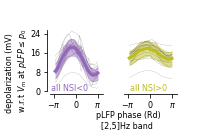

In [118]:
OUTPUT = dict(np.load('cortical_arousal_index/data/final_depol.npz'))
fig_comp_Vm, AX = figure(axes=(1,2), figsize=(.75,1.))
from scipy.stats import ttest_rel, ttest_ind

NEpisode_MIN = 3
with_single_cell_traces, lw = True, 0.1

# phase plot --- SYNCH CASE ----
Phase_Depol = [[] for k in range(len(OUTPUT['PHASE'][0]))]
Cell_Mean = []
for i in range(len(OUTPUT['FILENAMES'])):
    V0 = OUTPUT['VM_ASYNCH_LEVELS'][i][-1] # stored Vm level at pLFP<=p0
    cond = np.isfinite(OUTPUT['VM_PHASE_LEVELS'][i])
    Cell_Mean.append(np.mean(OUTPUT['VM_PHASE_LEVELS'][i][cond])-V0)
    for p, v in zip(OUTPUT['PHASE'][i][cond], OUTPUT['VM_PHASE_LEVELS'][i][cond]):
        i0 = np.argmin(np.abs(p-OUTPUT['PHASE'][0]))
        Phase_Depol[i0].append(v-V0)
    if with_single_cell_traces:
        AX[0].plot(OUTPUT['PHASE'][i][cond], OUTPUT['VM_PHASE_LEVELS'][i][cond]-V0, 'k-', lw=lw)
mean, std = [], []
for j in range(len(OUTPUT['PHASE'][0])):
    mean.append(np.mean(Phase_Depol[j]))                                  
    std.append(np.std(Phase_Depol[j]))                                  
AX[0].plot(OUTPUT['PHASE'][0], mean, lw=3, color=Purple)
AX[0].fill_between(OUTPUT['PHASE'][0], np.array(mean)+np.array(std),
                      np.array(mean)-np.array(std), color=Purple, alpha=.5, lw=0)

# phase plot --- ASYNCH CASE ----
Phase_Depol = [[] for k in range(len(OUTPUT['PHASE_ASYNCH'][0]))]
Cell_Mean = []
for i in range(len(OUTPUT['FILENAMES'])):
    V0 = OUTPUT['VM_ASYNCH_LEVELS'][i][-1]
    cond = np.isfinite(OUTPUT['VM_PHASE_LEVELS_ASYNCH'][i])
    Cell_Mean.append(np.mean(OUTPUT['VM_PHASE_LEVELS_ASYNCH'][i][cond])-V0)
    for p, v in zip(OUTPUT['PHASE_ASYNCH'][i][cond], OUTPUT['VM_PHASE_LEVELS_ASYNCH'][i][cond]):
        i0 = np.argmin(np.abs(p-OUTPUT['PHASE_ASYNCH'][0]))
        Phase_Depol[i0].append(v-V0)
    if with_single_cell_traces:
        AX[1].plot(OUTPUT['PHASE_ASYNCH'][i][cond], OUTPUT['VM_PHASE_LEVELS_ASYNCH'][i][cond]-V0, 'k-', lw=lw)
mean, std = [], []
for j in range(len(OUTPUT['PHASE_ASYNCH'][0])):
    mean.append(np.mean(Phase_Depol[j]))                                  
    std.append(np.std(Phase_Depol[j]))                                  
AX[1].plot(OUTPUT['PHASE_ASYNCH'][0], mean, lw=3, color=Kaki)
AX[1].fill_between(OUTPUT['PHASE_ASYNCH'][0], np.array(mean)+np.array(std),
                      np.array(mean)-np.array(std), color=Kaki, alpha=.5, lw=0)

ymax = max([AX[0].get_ylim()[1], AX[1].get_ylim()[1]])-1
AX[0].annotate('all NSI<0', (-1.1*np.pi, 0), color=Purple, fontsize=FONTSIZE)
AX[1].annotate('all NSI>0', (-0.9*np.pi, 0), color=Kaki, fontsize=FONTSIZE)
for ax in [AX[0], AX[1]]:
    ax.plot([0], [ymax], 'w.', ms=1e-3)
    ax.plot(ax.get_xlim(), [0,0], ':', color=Brown, lw=1)
set_plot(AX[0], ylabel='depolarization (mV)          \n w.r.t $V_m$ at $pLFP \leq p_0$         ',
         xlabel='', ylim=[0,ymax], xticks=[-np.pi,0,np.pi],
         xticks_labels=['$-\pi$', '0', '$\pi$'])
set_plot(AX[1], ['bottom'],
         xlabel='pLFP phase (Rd)                  \n[2,5]Hz band                   ',
         ylim=[0,ymax], xticks=[-np.pi,0,np.pi],
         xticks_labels=['$-\pi$', '0', '$\pi$'])

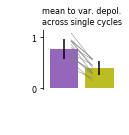

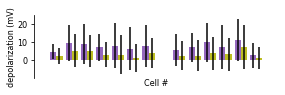

In [117]:
##################################################################################
## Analysis of the single-cycle reliability of phase-dependent depolarizations ###
##################################################################################


from scipy.stats import ttest_rel

OUTPUT = dict(np.load('cortical_arousal_index/data/final_depol.npz'))
fig, ax3 = figure()
fig, ax4 = figure(figsize=(2.5,1))
mean_to_var_S, mean_to_var_A, Depol_S, sDepol_S, Depol_A, sDepol_A = [], [], [], [], [], []
for i in range(len(OUTPUT['FILENAMES'])):
    condA = np.isfinite(OUTPUT['DVM_0PI_ASYNCH'][i])
    condS = np.isfinite(OUTPUT['DVM_0PI_SYNCH'][i])
    if (len(OUTPUT['DVM_0PI_SYNCH'][i][condS])>1) and (len(OUTPUT['DVM_0PI_ASYNCH'][i][condA])>1):
        mean_to_var_A.append(np.mean(OUTPUT['DVM_0PI_ASYNCH'][i][condA])/np.std(OUTPUT['DVM_0PI_ASYNCH'][i][condA]))
        Depol_A.append(np.mean(OUTPUT['DVM_0PI_ASYNCH'][i][condA]))
        sDepol_A.append(np.std(OUTPUT['DVM_0PI_ASYNCH'][i][condA]))
        mean_to_var_S.append(np.mean(OUTPUT['DVM_0PI_SYNCH'][i][condS])/np.std(OUTPUT['DVM_0PI_SYNCH'][i][condS]))
        Depol_S.append(np.mean(OUTPUT['DVM_0PI_SYNCH'][i][condS]))
        sDepol_S.append(np.std(OUTPUT['DVM_0PI_SYNCH'][i][condS]))
        ax3.plot([0.2,0.8], [mean_to_var_S[-1], mean_to_var_A[-1]], '-', lw=0.5, color=Grey)
        ax4.bar([i], [Depol_S[-1]], yerr=[sDepol_S[-1]], color=Purple, width=.4)
        ax4.bar([i+.4], [Depol_A[-1]], yerr=[sDepol_A[-1]], color=Kaki, width=.4)
update_study_output('mean_depol_from_0_to_pi_asynch', str(round(np.mean(Depol_A),1))+'$\pm$'+str(round(np.std(Depol_A),1)))
update_study_output('pvalue_mean_depol_from_0_to_pi_asynch', sci_str(ttest_rel(Depol_A, np.zeros(len(Depol_A))).pvalue, rounding=1))
update_study_output('std_depol_from_0_to_pi_asynch', str(round(np.mean(sDepol_A),1))+'$\pm$'+str(round(np.std(sDepol_A),1)))
update_study_output('mean_to_var_depol_from_0_to_pi_asynch', str(round(np.mean(mean_to_var_A),2))+'$\pm$'+str(round(np.std(mean_to_var_A),2)))
update_study_output('mean_depol_from_0_to_pi_synch', str(round(np.mean(Depol_S),1))+'$\pm$'+str(round(np.std(Depol_S),1)))
update_study_output('pvalue_mean_depol_from_0_to_pi_synch', sci_str(ttest_rel(Depol_S, np.zeros(len(Depol_S))).pvalue, rounding=1))
update_study_output('std_depol_from_0_to_pi_synch', str(round(np.mean(sDepol_S),1))+'$\pm$'+str(round(np.std(sDepol_S),1)))
update_study_output('mean_to_var_depol_from_0_to_pi_synch', str(round(np.mean(mean_to_var_S),2))+'$\pm$'+str(round(np.std(mean_to_var_S),2)))
update_study_output('pval_mean_to_var_depol_from_0_to_pi', sci_str(ttest_rel(mean_to_var_S, mean_to_var_A).pvalue, rounding=1))
ax3.bar([0], np.mean(mean_to_var_S), yerr=np.std(mean_to_var_S), color=Purple)
ax3.bar([1], np.mean(mean_to_var_A), yerr=np.std(mean_to_var_A), color=Kaki)
ax3.annotate('p='+\
             sci_str(ttest_rel(mean_to_var_S, mean_to_var_A).pvalue, rounding=0),(0.7,-1.), fontsize=FONTSIZE)
ax3.set_title('mean to var. depol.\nacross single cycles', fontsize=FONTSIZE)
set_plot(ax3, ['left'], yticks=[0,1])
set_plot(ax4, ['left'], ylabel='depolarization (mV)', xlabel='Cell #')




## Commands runned on server to get the results

In [84]:
Script = """# first the wavelet scan
# python exp_data.py -tdw -f data/trial30.npz --discretization 30 --parallelize --subsampling_period 1e-3 
# then the smoothing scan
python exp_data.py -tds -if data/trial30.npz -f data/smooth30.npz --parallelize --discretization 40 --subsampling_period 1e-3 
"""
f = open('cortical_arousal_index/bash_scripts/wavelet_scan.sh', 'w')
f.write(Script)
f.close()

In [4]:
Script = """# the alpha scan
python exp_data.py -tda -f data/final_alpha.npz --parallelize --discretization 40 --subsampling_period 1e-3 --alpha_min 1. --alpha_max 7.
"""
f = open('cortical_arousal_index/bash_scripts/alpha_scan.sh', 'w')
f.write(Script)
f.close()

In [5]:
Script = """# the link between the depolarization level and the pLFP signal
python exp_data.py -gpl -f data/final_depol.npz --parallelize
"""
f = open('cortical_arousal_index/bash_scripts/depol.sh', 'w')
f.write(Script)
f.close()

In [31]:
# the impact of alpha on the granularity of the classification
ALPHA = np.round(np.linspace(1,5,10),2)
Script = ''
for s, c in zip(np.array(100.*ALPHA, dtype=int), ALPHA):
    print('sget data/final_depol_alpha'+str(s)+'.npz')
    Script+='python exp_data.py -gpl -f data/final_depol_alpha'+str(s)+'.npz --parallelize --alpha '+str(c)+'\n'
f = open('cortical_arousal_index/bash_scripts/granularity_and_alpha.sh', 'w')
f.write(Script)
f.close()                          

sget data/final_depol_alpha100.npz
sget data/final_depol_alpha144.npz
sget data/final_depol_alpha189.npz
sget data/final_depol_alpha233.npz
sget data/final_depol_alpha278.npz
sget data/final_depol_alpha322.npz
sget data/final_depol_alpha367.npz
sget data/final_depol_alpha411.npz
sget data/final_depol_alpha455.npz
sget data/final_depol_alpha500.npz


In [170]:
cat cortical_arousal_index/bash_scripts/granularity_and_alpha.sh

python exp_data.py -gpl -f data/final_depol_alpha100.npz --parallelize --alpha 1.0
python exp_data.py -gpl -f data/final_depol_alpha144.npz --parallelize --alpha 1.44
python exp_data.py -gpl -f data/final_depol_alpha189.npz --parallelize --alpha 1.89
python exp_data.py -gpl -f data/final_depol_alpha233.npz --parallelize --alpha 2.33
python exp_data.py -gpl -f data/final_depol_alpha278.npz --parallelize --alpha 2.78
python exp_data.py -gpl -f data/final_depol_alpha322.npz --parallelize --alpha 3.22
python exp_data.py -gpl -f data/final_depol_alpha367.npz --parallelize --alpha 3.67
python exp_data.py -gpl -f data/final_depol_alpha411.npz --parallelize --alpha 4.11
python exp_data.py -gpl -f data/final_depol_alpha455.npz --parallelize --alpha 4.56
python exp_data.py -gpl -f data/final_depol_alpha500.npz --parallelize --alpha 5.0


# Time scale 

In [ ]:
%run cortical_arousal_index/exp_data.py
# loading a reduced dataset per cell
DATA = []
for i in np.arange(1, 15):
    data = dict(np.load('cortical_arousal_index/data/reduced_data_cell_'+str(i)+'.npz'))
    DATA.append(data)

In [26]:
DT, mCC, sCC = [], [], []
for idt in [1,2,5,10,20]:
    DT.append(1e3*(data['sbsmpl_t'][::idt][1]-data['sbsmpl_t'][::idt][0]))
    cc = []
    for data in DATA:
        cc.append(np.corrcoef(data['NSI'][data['NSI_validated']][::idt], data['Vm_NSI'][data['NSI_validated']][::idt])[0,1])
    mCC.append(np.mean(cc))
    sCC.append(np.std(cc))
    

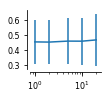

In [27]:
fig, ax = figure()
ax.errorbar(DT, mCC, yerr=sCC)
set_plot(ax, xscale='log')